# Library Imports

In [145]:
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import janitor
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import duckdb
import re
import requests
from dotenv import dotenv_values
import shelve
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np
from tabulate import tabulate
import hashlib
from IPython.display import IFrame, display, HTML

pio.renderers.default = 'iframe'  # or 'iframe' or 'plotly_mimetype'
%matplotlib inline

# Ensure Plotly renders properly
# pio.renderers.default = 'notebook'  # For Jupyter Notebook (use 'notebook_connected' for JupyterLab)

# Disable LaTeX parsing globally
mpl.rcParams['text.usetex'] = False

In [146]:
# You can install these libraries if you haven't already:
!pip install pandas geopandas matplotlib pyjanitor plotly bokeh duckdb python-dotenv tabulate


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Create a lookup dictionary to rename columns based on the Census Table ID
table_id_lookup ={
    'S1901': "income",
    'S1501': "educational_attainment",
    'B15001': "sex_by_age_by_educational_attainment",
    'B02001': "race"   
}

In [7]:
# List of columns to exclude from processing (e.g., 'GEO_ID', 'Name', etc.)
exclude_columns = ['geography', 'geographic_area_name']

# Get the list of columns to process by filtering out the excluded columns
# columns_to_process = income_data_cleaned.columns.difference(exclude_columns)

# Directory Setup

In [5]:
# Get the current working directory
#current_dir = Path.cwd()
current_dir = Path("C:/Users/lover/Documents/Github/Oakland_Air_Quality/")

print(current_dir)

C:\Users\lover\Documents\Github\Oakland_Air_Quality


# Function Definitions

## epoch_to_year

In [9]:
# Function to convert epoch to year
def epoch_to_year(epoch_time):
    return datetime.utcfromtimestamp(epoch_time).year

## extract_year_from_filename

In [10]:
# Function to extract the year from a filename
def extract_year_from_filename(file_name):
    # Use a regex to search for a 4-digit year in the file name
    # match = re.search(r'ACSST5Y(\d{4})', file_name)
    match = re.search(r'.*(\d{4})\.', file_name)
    if match:
        return int(match.group(1))  # Return the year as an integer
    else:
        raise ValueError(f"Year not found in file name: {file_name}")

# Example usage
file_name = 'ACSST5Y2018.S1901-Data.csv'
year = extract_year_from_filename(file_name)
print(f"Extracted year: {year}")


Extracted year: 2018


## extract_table_id_from_filename

In [11]:
# Function to extract the year from a filename
def extract_table_id_from_filename(file_name):
    # Use a regex to search for a 4-digit year in the file name
    match = re.search(r'\.(\w+\d+)-Data\.csv$', file_name)
    
    if match:
        return (match.group(1))  # Return the table ID
    else:
        raise ValueError(f"Table ID not found in file name: {file_name}")

# Example usage
# file_name = 'ACSST5Y2018.S1901-Data.csv'
# file_name = 'ACSDT5Y2019.B02001-Data.csv'
file_name = 'ACSDT5Y2018.B02001-Data.csv'
table_id = extract_table_id_from_filename(file_name)
print(f"Extracted Table ID: {table_id}")


Extracted Table ID: B02001


## clean_column_names

In [12]:
# Define the function to reduce the number of '!!!' occurrences in the column names
def clean_column_names(col):
    # Reduce consecutive occurrences of '!' to a single '!'
    col = re.sub(r'!{2,}', '_', col)  # Replace two or more exclamation marks with one
    return col


## prefix_column_names_with_table_id

In [13]:
# Define the function to reduce the number of '!!!' occurrences in the column names
def prefix_column_names_with_table_id(col, table_id):
    # Reduce consecutive occurrences of '!' to a single '!'
    col = table_id_lookup[table_id] +  '_' + col  # Replace two or more exclamation marks with one
    return col

col_test = "foobar_income"
test_table_id =  'B02001'
print(prefix_column_names_with_table_id(col_test, test_table_id))


race_foobar_income


## clean_special_chars

In [14]:
# Define the function to reduce the number of '!!!' occurrences in the column names
def clean_special_chars(col):
    # Reduce consecutive occurrences of '!' to a single '!'
    col = re.sub(r'!{2,}', '_', col)  # Replace two or more exclamation marks with one
    col = re.sub(r'\$', '', col) # Replace '$'
    return col


## remove_unnamed_columns

In [15]:
# Define the function to reduce the number of '!!!' occurrences in the column names
def remove_unnamed_columns(col):
    # Reduce consecutive occurrences of '!' to a single '!'
    col = re.match(r'!{2,}', '_', col)  # Replace two or more exclamation marks with one
    return col


## process_column

In [16]:
# Define a function to process each column (this avoids using an explicit for loop)
def process_column(col_name):
    print(f'Column: {col_name}')
    # Create a truncated DataFrame with just the GEO_ID and the current column
    truncated_df = income_data_cleaned[['geography', 'geographic_area_name', col_name]]
    print(f'Created truncated_df')
    truncated_df.head()
    
    # Merge this truncated DataFrame with the geographic data (shapefile)
    merged_df = geo_data.merge(truncated_df, left_on='AFFGEOID', right_on='geography')
    
    # Store the merged DataFrame in the dictionary using the column name as the key
    merged_data_dict[col_name] = merged_df

## convert_to_numeric

In [146]:
# Define a function that attempts to convert a column to numeric
def convert_to_numeric(df, column):
    try:
        # Convert to numeric
        df[column.name] = pd.to_numeric(column, errors='coerce')  # Convert non-numeric to NaN
        print(f"Converted {column.name} to numeric")
    except Exception as e:
        print(f"Error processing {column.name}: {e}")

## cleanse_df

In [147]:
def cleanse_df(df):
    # Use the clean_names() function from pyjanitor to automatically clean column names
    df = df.clean_names()
   
    # Remove columns that are prefixed with 'Unnamed'
    df = df.loc[:, ~df.columns.str.startswith('unnamed')]
    
    # Remove bangs
    df.columns = df.columns.to_series().apply(clean_special_chars)

    # Columns to ignore when doing numeric conversion
    cols_to_ignore = ['geography', 'geographic_area_name']
    # Apply the function to all columns except the ones you want to omit (in-place)
    for col in df.columns:
        if col not in cols_to_ignore:
            convert_to_numeric(df, df[col])
    
    return(df)
    

## generate_census_histograms

In [784]:
# Function to generate plotly histograms and render inline
def generate_census_histograms(column_of_interest, start_year=2018, end_year=2023, con=con):
    # Initialize a list to store figures, checksums, and filenames
    html_filenames = []
    html_folder = "images"
    
    # Manually invoke the plot for each year
    for year in range(start_year, end_year):
        
        # Fetch the data for the specific year
        my_results_df = get_sensor_counts_per_tract_by_year(con, column_of_interest, year)
    
        # Ensure the data is unique and limit the columns displayed
        display_columns_df = my_results_df[['geographic_area_name', 'sensor_count', column_of_interest]].copy()
        display_columns_df = display_columns_df.sort_values(by='sensor_count', ascending=False).copy()

        my_col_numpy = display_columns_df[column_of_interest].to_numpy()
        
        # Manually calculate the histogram bins and counts using NumPy
        hist_values, bin_edges = np.histogram(my_col_numpy, bins='auto')

        # Calculate percentages for each bin relative to the total number of data points
        total_count = np.sum(hist_values)
        percentages = 100 * hist_values / total_count
        
        # Center the bin edges for the hover text (midpoints of bins)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        # Stack percentages and bin edges for customdata
        customdata = np.stack((percentages, bin_edges[:-1], bin_edges[1:]), axis=-1)
        
        # Create the histogram figure
        fig = go.Figure(data=[go.Bar(
            x=bin_centers,
            y=hist_values,
            customdata=customdata,  # Use percentages and bin ranges for hover
            hovertemplate='Bin Range: %{customdata[1]:.2f} - %{customdata[2]:.2f}<br>'  # Bin range
                          '%{y} items (<b>%{customdata[0]:.2f}%</b> of total)<extra></extra>'
        )])

        # Title and layout
        fig.update_layout(
            title=f"{year}: Sensor Count vs {column_of_interest.replace('_', ' ').title()}",
            xaxis_title=column_of_interest.replace('_', ' ').title(),
            yaxis_title="Sensor Count",
            bargap=0.2
        )
        
        # Save the figure to HTML
        html_filename = f"./images/{column_of_interest}_histogram_{year}.html"
        fig.write_html(html_filename)  # Save figure to HTML file
        html_filenames.append(html_filename)
    
    # Iterate over the saved HTML files and display them inline
    for html_file in html_filenames:
        # Move the HTML files to the 'images' folder (if not already moved)
        new_path = os.path.join(html_folder, os.path.basename(html_file))
        
        # Display the HTML inline using IFrame
        print(f"Displaying {new_path}")
        display(IFrame(src=new_path, width=1000, height=800))

# Example of running the function for a specific column and year range
col = 'educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_or_higher'
generate_census_histograms(col, 2018, 2019)


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_or_higher_histogram_2018.html


# Initiate DuckDB connection

In [6]:
# Create path to DB
db_file = current_dir / 'data' / 'file.db'
# create a connection to a file called 'file.db'
con = duckdb.connect(db_file)

# Uncomment and use test code to confirm functionality. 
# -- create a table and load data into it
# con.sql("CREATE TABLE test (i INTEGER)")
# con.sql("INSERT INTO test VALUES (42)")
#  -- query the table
# con.table("test").show()

# Data Import

## Working Directories

In [152]:
# Set up our data and working directories
data_dir = current_dir / "data"
shape_files_dir = current_dir / "shape_files"

print(data_dir)

C:\Users\lover\Documents\Github\Oakland_Air_Quality\data


In [153]:
from pathlib import Path

# Full directory path where you want to list the files
# directory_path = Path("C:/Users/lover/Documents/Github/Oakland_Air_Quality/data")
directory_path = current_dir / "data"
# List all files in the directory
for file_path in directory_path.iterdir():
    if file_path.is_file():  # Ensure it's a file (not a directory)
        if re.search("\-Data\.csv$", file_path.name):
            print("File is a CSV")
            print(file_path.name)  # Print just the file name
            print(f"Year:{extract_year_from_filename(file_path.name)}\n")


File is a CSV
ACSDT5Y2018.B02001-Data.csv
Year:2018

File is a CSV
ACSDT5Y2018.B15001-Data.csv
Year:2018

File is a CSV
ACSDT5Y2019.B02001-Data.csv
Year:2019

File is a CSV
ACSDT5Y2019.B15001-Data.csv
Year:2019

File is a CSV
ACSDT5Y2020.B02001-Data.csv
Year:2020

File is a CSV
ACSDT5Y2020.B15001-Data.csv
Year:2020

File is a CSV
ACSDT5Y2021.B02001-Data.csv
Year:2021

File is a CSV
ACSDT5Y2021.B15001-Data.csv
Year:2021

File is a CSV
ACSDT5Y2022.B02001-Data.csv
Year:2022

File is a CSV
ACSDT5Y2022.B15001-Data.csv
Year:2022

File is a CSV
ACSST5Y2018.S1501-Data.csv
Year:2018

File is a CSV
ACSST5Y2018.S1901-Data.csv
Year:2018

File is a CSV
ACSST5Y2019.S1501-Data.csv
Year:2019

File is a CSV
ACSST5Y2019.S1901-Data.csv
Year:2019

File is a CSV
ACSST5Y2020.S1501-Data.csv
Year:2020

File is a CSV
ACSST5Y2020.S1901-Data.csv
Year:2020

File is a CSV
ACSST5Y2021.S1501-Data.csv
Year:2021

File is a CSV
ACSST5Y2021.S1901-Data.csv
Year:2021

File is a CSV
ACSST5Y2022.S1501-Data.csv
Year:2022

Fi

<>:9: DeprecationWarning:

invalid escape sequence \-

<>:9: DeprecationWarning:

invalid escape sequence \-

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2879909762.py:9: DeprecationWarning:

invalid escape sequence \-



## Setup Geographic Data

In [112]:
# Set up our geo data
geo_data = gpd.read_file(current_dir / 'shape_files' / 'cb_2018_06_tract_500k.shp')
geo_data.head()

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME LSAD   
0      06      009  000300  1400000US06009000300  06009000300        3   CT  \
1      06      011  000300  1400000US06011000300  06011000300        3   CT   
2      06      013  303102  1400000US06013303102  06013303102  3031.02   CT   
3      06      013  303202  1400000US06013303202  06013303202  3032.02   CT   
4      06      013  303203  1400000US06013303203  06013303203  3032.03   CT   

       ALAND  AWATER   
0  457009794  394122  \
1  952744514  195376   
2    6507019       0   
3    3725528       0   
4    6354210       0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## Create Merged Census Data 

In [154]:
# Create variable to store our yearly dataframes
all_census_dataframes = []

# Process all CSV data files
directory_path = current_dir / "data"
# List all files in the directory
for file_path in directory_path.iterdir():
    if file_path.is_file():  # Ensure it's a file (not a directory)
        if re.search("\-Data\.csv$", file_path.name):
            print(file_path.name)  # Print just the file name

            # Extract the year
            year = extract_year_from_filename(file_path.name)
            
            # Extract the table ID
            table_id = extract_table_id_from_filename(file_path.name)
            # print(f"Table id {table_id}")

            # Read in Census data
            input_census_data = pd.read_csv(file_path, header=1)
            # print(f" Income data {file_path} :\n {income_data.head(3)}")
            
            # Sanitize column names of df
            input_census_data = cleanse_df(input_census_data)

            # Rename columns prefixed with table ID using a list comprehension
            input_census_data.columns = [prefix_column_names_with_table_id(col, table_id) if col not in exclude_columns else col for col in input_census_data.columns]

            # Set the year column for all rows in the df
            input_census_data['year'] = year
            print(f"Year: {year}\nShape: {input_census_data.shape}")
            # print(f"Head data {income_data.head(3)}")
            all_census_dataframes.append(input_census_data)


# Concatenate all DataFrames vertically
merged_census_df = pd.concat(all_census_dataframes, axis=0, ignore_index=True, sort=False)

<>:9: DeprecationWarning:

invalid escape sequence \-

<>:9: DeprecationWarning:

invalid escape sequence \-

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:9: DeprecationWarning:

invalid escape sequence \-

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: Performa

ACSDT5Y2018.B02001-Data.csv
Converted estimate_total to numeric
Converted margin_of_error_total to numeric
Converted estimate_total_white_alone to numeric
Converted margin_of_error_total_white_alone to numeric
Converted estimate_total_black_or_african_american_alone to numeric
Converted margin_of_error_total_black_or_african_american_alone to numeric
Converted estimate_total_american_indian_and_alaska_native_alone to numeric
Converted margin_of_error_total_american_indian_and_alaska_native_alone to numeric
Converted estimate_total_asian_alone to numeric
Converted margin_of_error_total_asian_alone to numeric
Converted estimate_total_native_hawaiian_and_other_pacific_islander_alone to numeric
Converted margin_of_error_total_native_hawaiian_and_other_pacific_islander_alone to numeric
Converted estimate_total_some_other_race_alone to numeric
Converted margin_of_error_total_some_other_race_alone to numeric
Converted estimate_total_two_or_more_races to numeric
Converted margin_of_error_total

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Converted margin_of_error_female_moe_population_25_years_and_over_bachelors_degree_or_higher to numeric
Converted estimate_percent_female_population_25_years_and_over_bachelors_degree_or_higher to numeric
Converted margin_of_error_percent_female_moe_population_25_years_and_over_bachelors_degree_or_higher to numeric
Converted estimate_percent_population_25_years_and_over_population_25_to_34_years to numeric
Converted margin_of_error_percent_moe_population_25_years_and_over_population_25_to_34_years to numeric
Converted estimate_male_population_25_years_and_over_population_25_to_34_years to numeric
Converted margin_of_error_male_moe_population_25_years_and_over_population_25_to_34_years to numeric
Converted estimate_percent_male_population_25_years_and_over_population_25_to_34_years to numeric
Converted margin_of_error_percent_male_moe_population_25_years_and_over_population_25_to_34_years to numeric
Converted estimate_female_population_25_years_and_over_population_25_to_34_years to nume

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Converted estimate_total_age_by_educational_attainment_population_18_to_24_years to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years to numeric
Converted estimate_total_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate to numeric
Converted estimate_total_age_by_educational_attainment_population_18_to_24_years_high_school_graduate_includes_equivalency_ to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years_high_school_graduate_includes_equivalency_ to numeric
Converted estimate_total_age_by_educational_attainment_population_18_to_24_years_some_college_or_associates_degree to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years_some_college_or_associates_degree to numeric
Converted estimate_t

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



ACSST5Y2019.S1901-Data.csv
Converted estimate_households_total to numeric
Converted margin_of_error_households_total to numeric
Converted estimate_households_total_less_than_10_000 to numeric
Converted margin_of_error_households_total_less_than_10_000 to numeric
Converted estimate_households_total_10_000_to_14_999 to numeric
Converted margin_of_error_households_total_10_000_to_14_999 to numeric
Converted estimate_households_total_15_000_to_24_999 to numeric
Converted margin_of_error_households_total_15_000_to_24_999 to numeric
Converted estimate_households_total_25_000_to_34_999 to numeric
Converted margin_of_error_households_total_25_000_to_34_999 to numeric
Converted estimate_households_total_35_000_to_49_999 to numeric
Converted margin_of_error_households_total_35_000_to_49_999 to numeric
Converted estimate_households_total_50_000_to_74_999 to numeric
Converted margin_of_error_households_total_50_000_to_74_999 to numeric
Converted estimate_households_total_75_000_to_99_999 to numeri

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Converted margin_of_error_total_median_earnings_in_the_past_12_months_in_2021_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_bachelors_degree to numeric
Converted estimate_total_median_earnings_in_the_past_12_months_in_2021_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_graduate_or_professional_degree to numeric
Converted margin_of_error_total_median_earnings_in_the_past_12_months_in_2021_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_graduate_or_professional_degree to numeric
Converted estimate_percent_age_by_educational_attainment_population_18_to_24_years to numeric
Converted margin_of_error_percent_age_by_educational_attainment_population_18_to_24_years to numeric
Converted estimate_percent_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate to numeric
Converted margin_of_error_percent_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate to nu

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Converted estimate_total_age_by_educational_attainment_population_18_to_24_years to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years to numeric
Converted estimate_total_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate to numeric
Converted estimate_total_age_by_educational_attainment_population_18_to_24_years_high_school_graduate_includes_equivalency_ to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years_high_school_graduate_includes_equivalency_ to numeric
Converted estimate_total_age_by_educational_attainment_population_18_to_24_years_some_college_or_associates_degree to numeric
Converted margin_of_error_total_age_by_educational_attainment_population_18_to_24_years_some_college_or_associates_degree to numeric
Converted estimate_t

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\lover\AppData\Local\Temp\ipykernel_168508\2826588086.py:30: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [156]:
merged_census_df.tail()
# merged_years_df['year']
# Create a defragmented dataframe by copy()
merged_census_df = merged_census_df.copy()

In [262]:
# Try some test queries and plots from duckdb
duckdb.register("merged_census_view", merged_census_df)
#print(duckdb.sql("SELECT COUNT(*) FROM merged_df_view  WHERE geographic_area_name LIKE '%9819%' ").fetchall())

# Select data from the view
# print(duckdb.sql("SELECT geo FROM merged_df_view  WHERE geographic_area_name LIKE '%9819%' ").fetchall())
tract_9819_df = duckdb.query("SELECT geography, geographic_area_name, income_estimate_households_total, year FROM merged_census_view WHERE geographic_area_name LIKE '%9819%' LIMIT 1").fetchdf()

print(tract_9819_df)


# Test to see if we can see data for race
print(duckdb.sql("SELECT geographic_area_name, race_estimate_total_black_or_african_american_alone \
    FROM merged_census_view  \
    WHERE year = 2018 \
    AND race_estimate_total_black_or_african_american_alone > 0 "
    ).fetchall())

# Merge a single tract data with our geo data.
# merged_tract_data = geo_data.merge(tract_9819_df, left_on='AFFGEOID', right_on='geography')
# merged_tract_data.plot(column='estimate_households_total', legend=True)

# Grab for all tracts, but scope to a year
# est_hous_totals_2021_df = duckdb.query("SELECT geography, geographic_area_name, income_estimate_households_total, year FROM merged_census_view WHERE YEAR = '2019' ").fetchdf()
 
# merged_tract_data = geo_data.merge(est_hous_totals_2021_df, left_on='AFFGEOID', right_on='geography')
# merged_tract_data.plot(column='estimate_households_total', legend=True)



              geography                           geographic_area_name   
0  1400000US06001981900  Census Tract 9819, Alameda County, California  \

   income_estimate_households_total  year  
0                               NaN  2018  
[('Census Tract 4001, Alameda County, California', 128.0), ('Census Tract 4002, Alameda County, California', 59.0), ('Census Tract 4003, Alameda County, California', 380.0), ('Census Tract 4004, Alameda County, California', 229.0), ('Census Tract 4005, Alameda County, California', 990.0), ('Census Tract 4006, Alameda County, California', 360.0), ('Census Tract 4007, Alameda County, California', 1458.0), ('Census Tract 4008, Alameda County, California', 1049.0), ('Census Tract 4009, Alameda County, California', 765.0), ('Census Tract 4010, Alameda County, California', 2111.0), ('Census Tract 4011, Alameda County, California', 517.0), ('Census Tract 4012, Alameda County, California', 357.0), ('Census Tract 4013, Alameda County, California', 1244.0), ('Cen

In [157]:
# Create a proper duckdb table from the view of the merged census dataframe
con.execute("CREATE TABLE merged_census_table AS SELECT * FROM merged_census_df")

# Verify the table creation by querying it
result = con.execute("SELECT * FROM merged_census_table LIMIT 5").fetch_df()

# Print the result
print(result)

              geography                           geographic_area_name   
0  1400000US06001400100  Census Tract 4001, Alameda County, California  \
1  1400000US06001400200  Census Tract 4002, Alameda County, California   
2  1400000US06001400300  Census Tract 4003, Alameda County, California   
3  1400000US06001400400  Census Tract 4004, Alameda County, California   
4  1400000US06001400500  Census Tract 4005, Alameda County, California   

   race_estimate_total  race_margin_of_error_total   
0               3115.0                       219.0  \
1               2025.0                       110.0   
2               5000.0                       311.0   
3               3843.0                       366.0   
4               3786.0                       355.0   

   race_estimate_total_white_alone  race_margin_of_error_total_white_alone   
0                           2122.0                                   263.0  \
1                           1551.0                                   144.0

## Alter geographic_area_name fields to remove semicolons

In [1474]:
con.sql(""" UPDATE merged_census_table
        SET geographic_area_name = REPLACE(geographic_area_name, ';', ',');
        """
       )

# con.sql("""UPDATE merged_sensor_table
#         SET geographic_area_name = REPLACE(geographic_area_name, ';', ',');
#         """
#        )



In [264]:
# Search for the missing census tracts (if any)
print(duckdb.sql("SELECT DISTINCT geographic_area_name from merged_df_view where geographic_area_name LIKE '%4034%' ").fetchall())


[('Census Tract 4034.01, Alameda County, California',), ('Census Tract 4034.01; Alameda County; California',), ('Census Tract 4034.02, Alameda County, California',), ('Census Tract 4034.02; Alameda County; California',)]


In [ ]:
# Confirm the column names we have stored in our db
print(duckdb.sql("SELECT DISTINCT geographic_area_name from merged_df_view where geographic_area_name LIKE '%4034%' ").fetchall())

In [ ]:
# Temporarily set Pandas option to avoid truncating wide columns
pd.set_option('display.max_colwidth', None)

# Your code that relies on the setting (e.g., displaying a row's columns)
row_587 = merged_years_df.loc[587]
print(row_587.index)

# Now reset the option back to its default
pd.reset_option('display.max_colwidth')

# Accessing Purple Air Data API

We had been focusing on collapsing all the data into a _single_ table, the option of importing to Tableau in mind. We need to now integrate Purple Air Data, so we will access its data via
its API, using the following steps:
* Generate an API key to extract Purple Air sensor data.
* Store the API key in a localized `.env` file.
* * Validate API access using stored API key programmatically.
* * Ensure the credentials do not appear in notebook output.
* * Ensure API credentials are not stored in version control. 
* Create a "bounding box" to geographically map to our geo locations
* Associate sensors to a census tract in DuckDB.
* Plot sensors on maps with census data.

In [265]:
geo_data.head()

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME LSAD   
0      06      009  000300  1400000US06009000300  06009000300        3   CT  \
1      06      011  000300  1400000US06011000300  06011000300        3   CT   
2      06      013  303102  1400000US06013303102  06013303102  3031.02   CT   
3      06      013  303202  1400000US06013303202  06013303202  3032.02   CT   
4      06      013  303203  1400000US06013303203  06013303203  3032.03   CT   

       ALAND  AWATER                                           geometry  
0  457009794  394122  POLYGON ((-120.76399 38.21389, -120.76197 38.2...  
1  952744514  195376  POLYGON ((-122.50006 39.12232, -122.50022 39.1...  
2    6507019       0  POLYGON ((-121.72937 37.96884, -121.71409 37.9...  
3    3725528       0  POLYGON ((-121.72346 37.96161, -121.71672 37.9...  
4    6354210       0  POLYGON ((-121.74486 37.95681, -121.74425 37.9...

## Setup Bounding Box

In [266]:
# Infer the bounding box for API requests from our geo data

# Combine all census tracts uniquely. We can use our duckdb to isolate these uniquely.
census_tracts_df = con.execute("SELECT DISTINCT geography FROM merged_census_table ").fetchdf()

# Filter the GeoDataFrame to include only these census tracts
filtered_geo_df = geo_data[geo_data['AFFGEOID'].isin(census_tracts_df['geography'])]
# print(filtered_geo_df)

minx, miny, maxx, maxy = filtered_geo_df.total_bounds

# Output the bounding box
print(f"Bounding Box - Min Lon: {minx}, Min Lat: {miny}, Max Lon: {maxx}, Max Lat: {maxy}")

Bounding Box - Min Lon: -122.342253, Min Lat: 37.698695, Max Lon: -122.114797, Max Lat: 37.885438


In [ ]:
print(os.environ['PURPLEAIR_API_KEY'])

In [267]:
# Test our ability to load in .env for API key
config = dotenv_values(".env")
env_vars = os.environ
print(env_vars.keys())

# Can use iPython magic functions to load .env
# %load_ext dotenv
# %dotenv

KeysView(environ({'ALLUSERSPROFILE': 'C:\\ProgramData', 'APPDATA': 'C:\\Users\\lover\\AppData\\Roaming', 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'COMPUTERNAME': 'CYBERPOWER-1', 'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe', 'CONDA_DEFAULT_ENV': 'coursera_project', 'CONDA_EXE': 'C:\\ProgramData\\Anaconda3\\Scripts\\conda.exe', 'CONDA_PROMPT_MODIFIER': '(coursera_project) ', 'CONDA_PYTHON_EXE': 'C:\\ProgramData\\Anaconda3\\python.exe', 'CONDA_SHLVL': '1', 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData', 'EFC_11220': '1', 'FPS_BROWSER_APP_PROFILE_STRING': 'Internet Explorer', 'FPS_BROWSER_USER_PROFILE_STRING': 'Default', 'HOMEDRIVE': 'C:', 'HOMEPATH': '\\Users\\lover', 'LOCALAPPDATA': 'C:\\Users\\lover\\AppData\\Local', 'LOGONSERVER': '\\\\CYBERPOWER-1', 'NDI_RUNTIME_DIR_V2': 'C:\\Program Files\\NDI\\NDI 5 Tools\\Runtime', 'NDI_RUNTIME_DIR_

## Issue API Request for Purple Air Sensor Locations

In [156]:
# With our bounding box defined, we can send a targeted PurpleAir API request to obtain all sensors in the bounding box boundaries
PURPLE_API_ENDPOINT = 'https://api.purpleair.com/v1/sensors'
# Fields of interest
# name, model, latitude, longitude, altitude?, uptime, date_created, last_seen,
# position_rating
# location_type, 0 = outside, 1 = inside (do we care for now?)


import requests

# Your PurpleAir API key
api_key = os.environ['PURPLEAIR_API_KEY']

# Define the bounding box (example for San Francisco area)
nwlat = maxy  # North-west latitude
nwlng = minx  # North-west longitude
selat = miny  # South-east latitude
selng = maxx  # South-east longitude

# API endpoint
url = "https://api.purpleair.com/v1/sensors"

# Headers with API key
headers = {
    "X-API-Key": api_key
}

# Define query parameters for the API request
params = {
    "nwlng": nwlng,        # North-west longitude
    "nwlat": nwlat,        # North-west latitude
    "selng": selng,        # South-east longitude
    "selat": selat,        # South-east latitude
    "location_type": 0,    # Outdoor sensors
    #"fields": "sensor_index,name,latitude,longitude,pm2.5,temperature,humidity",  # Fields to retrieve
    "fields": "sensor_index,name,latitude,longitude,date_created,last_seen",  # Fields to retrieve
    "max_age": 3600        # Return only sensors that have reported in the last hour
}

# Make the API request
response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    print("Successfully retrieved sensor data.")
    # Access the sensor data
    for sensor in data.get("data", []):
        print(f"Sensor Name: {sensor[1]}, PM2.5: {sensor[5]}, Location: ({sensor[2]}, {sensor[3]})")
else:
    print(f"Failed to retrieve data: {response.status_code}")


Successfully retrieved sensor data.
Sensor Name: 1510872053, PM2.5: -122.15729, Location: (1726268045, Orinda)
Sensor Name: 1517976198, PM2.5: -122.289375, Location: (1726268021, Ecole Bilingue de Berkeley)
Sensor Name: 1528488345, PM2.5: -122.26612, Location: (1726268003, North Oakland IAQ house)
Sensor Name: 1531942762, PM2.5: -122.2266, Location: (1726267998, Hiller)
Sensor Name: 1533156019, PM2.5: -122.27175, Location: (1726267958, Harper House)
Sensor Name: 1533250376, PM2.5: -122.22653, Location: (1726267955, Hilltop)
Sensor Name: 1536016799, PM2.5: -122.16776, Location: (1726267946, Martha Rd.)
Sensor Name: 1536610315, PM2.5: -122.12302, Location: (1726268044, Boyer Circle)
Sensor Name: 1537319246, PM2.5: -122.18855, Location: (1726268010, Redwood Heights, Oakland)
Sensor Name: 1537384841, PM2.5: -122.24854, Location: (1726268062, Weather Tower)
Sensor Name: 1537844512, PM2.5: -122.21226, Location: (1726267980, Arden Pl)
Sensor Name: 1540329094, PM2.5: -122.21056, Location: (172

## Persist API Data Locally

In [157]:
# We persist the PurpleAir JSON data to avoid hitting the API unnecessarily.
# sensor_data = data

# with shelve.open('./data/my_shelf.db') as shelf:
#     # Store variables (assign them like dictionary values)
#     shelf['sensor_data'] = sensor_data


In [268]:
# Retrieve stored sensor data from our shelve
with shelve.open('./data/my_shelf.db') as shelf:
    sensor_data = shelf['sensor_data']

In [269]:
# Confirm our sensor data
# print(sensor_data)
# "fields": "sensor_index,name,latitude,longitude,date_created,last_seen"
for sensor in sensor_data['data']:
    # <field>: <index>
    # sensor_index: 0
    # date created: 1 
    # last_seen: 2
    # name: 3
    # latitude: 4
    # longitude: 5
    #print(sensor)
    print(f"Sensor Name: {sensor[3]}\n(Latitude: {sensor[4]} Longitude: {sensor[5]})\nCreation Date: {epoch_to_year(sensor[1])}\nLast Seen: {sensor[2]}")
    print()


Sensor Name: Orinda
(Latitude: 37.846275 Longitude: -122.15729)
Creation Date: 2017
Last Seen: 1726268045

Sensor Name: Ecole Bilingue de Berkeley
(Latitude: 37.85483 Longitude: -122.289375)
Creation Date: 2018
Last Seen: 1726268021

Sensor Name: North Oakland IAQ house
(Latitude: 37.84631 Longitude: -122.26612)
Creation Date: 2018
Last Seen: 1726268003

Sensor Name: Hiller
(Latitude: 37.853737 Longitude: -122.2266)
Creation Date: 2018
Last Seen: 1726267998

Sensor Name: Harper House
(Latitude: 37.85105 Longitude: -122.27175)
Creation Date: 2018
Last Seen: 1726267958

Sensor Name: Hilltop
(Latitude: 37.83431 Longitude: -122.22653)
Creation Date: 2018
Last Seen: 1726267955

Sensor Name: Martha Rd.
(Latitude: 37.87395 Longitude: -122.16776)
Creation Date: 2018
Last Seen: 1726267946

Sensor Name: Boyer Circle
(Latitude: 37.884678 Longitude: -122.12302)
Creation Date: 2018
Last Seen: 1726268044

Sensor Name: Redwood Heights, Oakland
(Latitude: 37.80103 Longitude: -122.18855)
Creation Date:

## Convert Sensor Data into DataFrame and GeoDataFrame

In [273]:
# Convert the JSON sensor data into a dataframe
sensor_data_df = pd.DataFrame(sensor_data['data'], columns=
                              ["sensor_index", "date_created", "last_seen",
                               "name", "latitude", "longitude"])

sensor_data_df.head()

sensor_index  date_created   last_seen                        name   
0          4389    1510872053  1726268045                      Orinda  \
1          7316    1517976198  1726268021  Ecole Bilingue de Berkeley   
2         11726    1528488345  1726268003     North Oakland IAQ house   
3         13517    1531942762  1726267998                      Hiller   
4         13907    1533156019  1726267958                Harper House   

    latitude   longitude  
0  37.846275 -122.157290  
1  37.854830 -122.289375  
2  37.846310 -122.266120  
3  37.853737 -122.226600  
4  37.851050 -122.271750

In [271]:
# Determine our coordinate reference system
print(geo_data.crs)

EPSG:4269


In [272]:
# Convert sensor data to GeoDataFrame (using WGS84, which is lat/lon)
sensor_data_gdf = gpd.GeoDataFrame(
    sensor_data_df, 
    geometry=gpd.points_from_xy(sensor_data_df.longitude, sensor_data_df.latitude),
    crs="EPSG:4326"  # Latitude/longitude (WGS84)
)


# Make sure both GeoDataFrames are in the same CRS
if geo_data.crs != sensor_data_gdf.crs:
    geo_data = geo_data.to_crs(sensor_data_gdf.crs)
# Perform a spatial join to associate each sensor with a census tract. 
sensors_within_tracts = gpd.sjoin(sensor_data_gdf, geo_data, how="left", predicate="within")

# Check the result
print(sensors_within_tracts)


     sensor_index  date_created   last_seen                        name   
0            4389    1510872053  1726268045                      Orinda  \
1            7316    1517976198  1726268021  Ecole Bilingue de Berkeley   
2           11726    1528488345  1726268003     North Oakland IAQ house   
3           13517    1531942762  1726267998                      Hiller   
4           13907    1533156019  1726267958                Harper House   
..            ...           ...         ...                         ...   
424        221573    1713278363  1726267765                Crestmont Dr   
425        225859    1716222982  1726267997        Benvenue and Woolsey   
426        235187    1722456716  1726267976                       Cañón   
427        238351    1723954327  1726268026                  Brandon St   
428        241449    1725643238  1726268009                      Hello!   

      latitude   longitude                     geometry  index_right STATEFP   
0    37.846275 -122

In [193]:
len(sensor_data_df)

429

In [194]:
sensors_within_tracts.columns

Index(['sensor_index', 'date_created', 'last_seen', 'name', 'latitude',
       'longitude', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER'],
      dtype='object')

# Test Plotting Sensor and Census Data

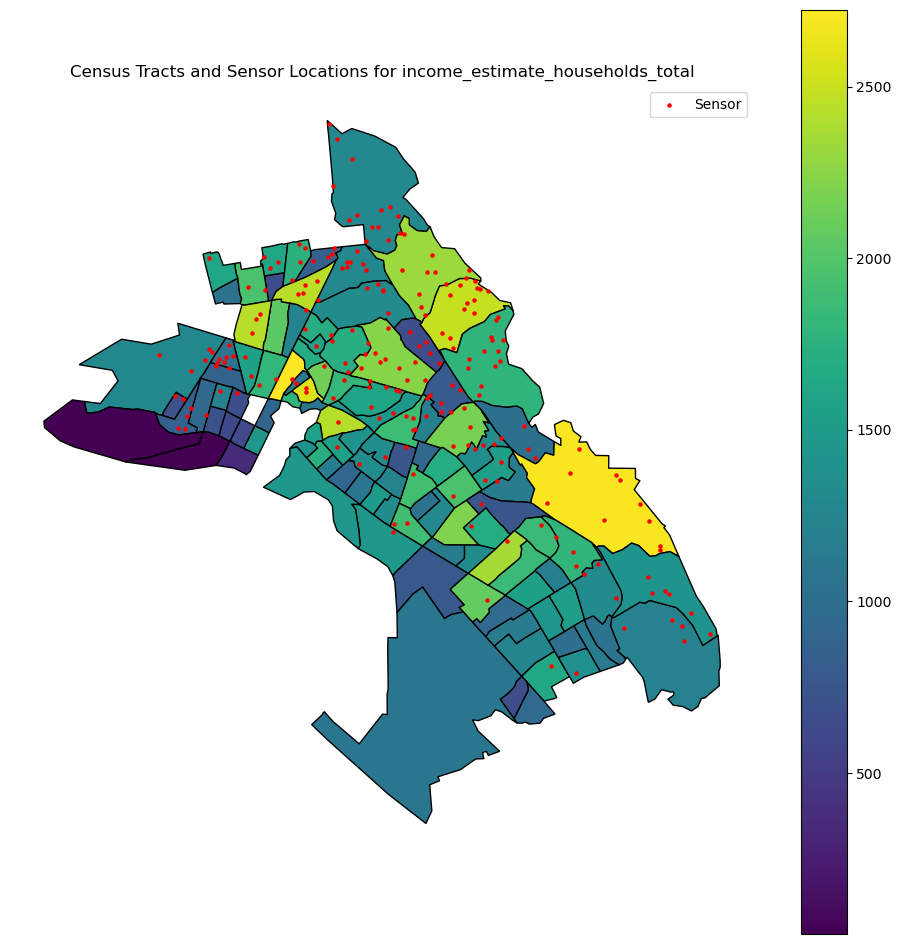

In [277]:
# Test plotting our graphs along with points representing sensors
# income_estimate_year_2018_df = duckdb.query("SELECT geography, geographic_area_name, income_estimate_households_total, \
#                              year FROM merged_census_view  WHERE year = 2018").fetchdf()

# Define the column of interest and year as parameters
column_of_interest = 'income_estimate_households_total'
# column_of_interest = 'income_estimate_families_total_100_000_to_149_999'
# Replace '$' with '\$' to escape LaTeX parsing in the column name
# column_for_plot = column_of_interest.replace('$', r'\$')
year_of_interest = 2018

# Parameterized DuckDB query
query = f"""
    SELECT geography, geographic_area_name, {column_of_interest}, year
    FROM merged_census_view
    WHERE year = {year_of_interest}
"""
# Execute the query
census_query_df = duckdb.query(query).fetchdf()

# Merge this truncated DataFrame with the geographic data (shapefile)
merged_data = geo_data.merge(census_query_df, left_on='AFFGEOID', right_on='geography')
# merged_data.plot(column='income_estimate_households_total', legend=True, figsize=(10, 10), cmap='OrRd')
# Plot the merged census tracts
ax = merged_data.plot(column=column_of_interest, 
                      legend=True,
                      figsize=(12, 12),
                      edgecolor='black')  # Add black edges for clarity)

# Step 1: Extract the relevant census tract GEOIDs (geography column) from merged_data
displayed_census_tracts = merged_data['geography'].unique()

# Step 2: Filter sensors that are within the displayed census tracts (using the 'geography' column)
sensors_within_bounds = sensors_within_tracts[sensors_within_tracts['AFFGEOID'].isin(displayed_census_tracts)]

# Plot sensor points on top of the census tract plot
sensors_within_bounds.plot(ax=ax, marker='o', color='red', markersize=5, label='Sensor')
# Set the title for the plot
plt.title(f"Census Tracts and Sensor Locations for {column_for_plot}", fontsize=12)

# Remove x and y axes
ax.set_axis_off()

# Show the plot with census tracts and sensors
plt.legend()
plt.show()

# Correlate Census and Sensor Data

In [216]:
census_query_df.head()

geography                           geographic_area_name   
0  1400000US06001400100  Census Tract 4001, Alameda County, California  \
1  1400000US06001400200  Census Tract 4002, Alameda County, California   
2  1400000US06001400300  Census Tract 4003, Alameda County, California   
3  1400000US06001400400  Census Tract 4004, Alameda County, California   
4  1400000US06001400500  Census Tract 4005, Alameda County, California   

   income_estimate_families_total_$100_000_to_$149_999  year  
0                                                NaN    2018  
1                                                NaN    2018  
2                                                NaN    2018  
3                                                NaN    2018  
4                                                NaN    2018

In [278]:
# Calculate the number of sensors in each census tract
sensor_counts = sensors_within_bounds.groupby('AFFGEOID').size().reset_index(name='sensor_count')

# Merge the sensor counts with the census data from DuckDB (e.g., median income)
# census_query_df = duckdb.query("SELECT geography, median_income FROM merged_census_view WHERE year = 2018").fetchdf()

# Merge sensor counts with the census data
sensor_and_census_merged_df = sensor_counts.merge(census_query_df, left_on='AFFGEOID', right_on='geography', how='left')

# Clean the DataFrame by dropping rows with NaN in 'income_estimate_households_total' and 'sensor_count'
#sensor_and_census_merged_df = sensor_and_census_merged_df.dropna(subset=['income_estimate_households_total, 'sensor_count'])

sensor_and_census_merged_df = sensor_and_census_merged_df.dropna(subset=[column_of_interest, 'sensor_count'])

# View the resulting DataFrame
print(sensor_and_census_merged_df.head())


                AFFGEOID  sensor_count             geography   
3   1400000US06001400100            14  1400000US06001400100  \
7   1400000US06001400200             4  1400000US06001400200   
11  1400000US06001400300             4  1400000US06001400300   
15  1400000US06001400400             4  1400000US06001400400   
19  1400000US06001400500             3  1400000US06001400500   

                             geographic_area_name   
3   Census Tract 4001, Alameda County, California  \
7   Census Tract 4002, Alameda County, California   
11  Census Tract 4003, Alameda County, California   
15  Census Tract 4004, Alameda County, California   
19  Census Tract 4005, Alameda County, California   

    income_estimate_households_total  year  
3                             1297.0  2018  
7                              855.0  2018  
11                            2441.0  2018  
15                            1750.0  2018  
19                            1622.0  2018  


## Calculate Pearson Correlation and Slope 

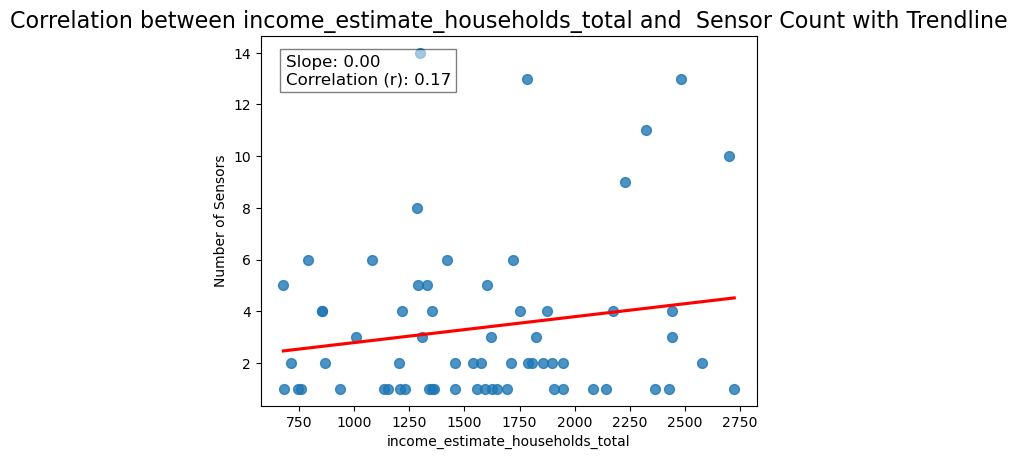

In [507]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import pearsonr


# # Calculate Pearson correlation coefficient and slope
correlation, _ = pearsonr(sensor_and_census_merged_df[column_of_interest], sensor_and_census_merged_df['sensor_count'])
slope, intercept = np.polyfit(sensor_and_census_merged_df[column_of_interest], sensor_and_census_merged_df['sensor_count'], 1)


# Create a scatter plot to visualize the relationship between sensor count and median income
# sns.scatterplot(data=sensor_and_census_merged_df, x='sensor_count', y=column_of_interest)
sns.regplot(data=sensor_and_census_merged_df,
            y='sensor_count',
            x=column_of_interest,
            scatter_kws={'s':50},
            line_kws={'color': 'red'},
            ci=None
           )

# Calculate the correlation coefficient (Pearson's correlation)
#correlation, _ = pearsonr(sensor_and_census_merged_df['sensor_count'], sensor_and_census_merged_df[column_of_interest])
#plt.title(f'Correlation between Sensor Count and Median Income (r = {correlation:.2f})')

#plt.title(f"Correlation between Sensor Count and  {column_for_plot} ", fontsize=12)

# Add title and labels
plt.title(f'Correlation between {column_of_interest} and  Sensor Count with Trendline', fontsize=16)
plt.ylabel('Number of Sensors')
plt.xlabel(f'{column_of_interest}')

# # Annotate the plot with the slope and Pearson correlation coefficient
plt.text(
    0.05, 0.95, 
    f'Slope: {slope:.2f}\nCorrelation (r): {correlation:.2f}', 
    ha='left', va='top', transform=plt.gca().transAxes, fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.show()


## Create Consolidated Sensor and Census DuckDB Table

In [292]:
# Obtain all the uniquely identifying geographies in our database. This should "bound" our sensors
unique_census_tract_geos_df = con.execute("SELECT DISTINCT geography FROM merged_census_table ").fetchdf()
unique_census_tract_geos_df.head()

geography
0  1400000US06001401600
1  1400000US06001402400
2  1400000US06001402500
3  1400000US06001403502
4  1400000US06001403900

In [327]:
# Grab data from original sensor data dataframe
del(sensor_data_with_year_df)
sensor_data_with_year_df = sensor_data_df

# Convert 'sensor_index' to string since it's meant to be an identifier
sensor_data_with_year_df['sensor_index'] = sensor_data_with_year_df['sensor_index'].astype(str)

# Create new column with just the year of sensor creation and add to new dataframe
sensor_data_with_year_df['year_created'] = sensor_data_with_year_df['date_created'].apply(epoch_to_year)

# View the updated DataFrame with the new column
print(sensor_data_df[['date_created', 'year_created']].head())

   date_created  year_created
0    1510872053          2017
1    1517976198          2018
2    1528488345          2018
3    1531942762          2018
4    1533156019          2018


In [330]:
sensor_data_df.head()

sensor_index  date_created   last_seen                        name   
0         4389    1510872053  1726268045                      Orinda  \
1         7316    1517976198  1726268021  Ecole Bilingue de Berkeley   
2        11726    1528488345  1726268003     North Oakland IAQ house   
3        13517    1531942762  1726267998                      Hiller   
4        13907    1533156019  1726267958                Harper House   

    latitude   longitude  last_seen_year  year_created  
0  37.846275 -122.157290            2024          2017  
1  37.854830 -122.289375            2024          2018  
2  37.846310 -122.266120            2024          2018  
3  37.853737 -122.226600            2024          2018  
4  37.851050 -122.271750            2024          2018

In [329]:
# Do we have years less than 2018?
# Filter rows using query method
del(filtered_df)
filtered_df = sensor_data_with_year_df.query('year_created < 2019')

# View the filtered DataFrame
len(filtered_df)
filtered_df.head()

sensor_index  date_created   last_seen                        name   
0         4389    1510872053  1726268045                      Orinda  \
1         7316    1517976198  1726268021  Ecole Bilingue de Berkeley   
2        11726    1528488345  1726268003     North Oakland IAQ house   
3        13517    1531942762  1726267998                      Hiller   
4        13907    1533156019  1726267958                Harper House   

    latitude   longitude  last_seen_year  year_created  
0  37.846275 -122.157290            2024          2017  
1  37.854830 -122.289375            2024          2018  
2  37.846310 -122.266120            2024          2018  
3  37.853737 -122.226600            2024          2018  
4  37.851050 -122.271750            2024          2018

In [322]:
# Grab Census data from duckdb.  We only want distinct data with the census tract, the AFFGEOID, and the year. 
# We want the creation year of the sensor to match the year of census data.
truncated_census_data_df = con.execute("SELECT DISTINCT geography, geographic_area_name, year FROM merged_census_table ").fetchdf()

len(truncated_census_data_df)
truncated_census_data_df.head()

geography                           geographic_area_name  year
0  1400000US06001400300  Census Tract 4003, Alameda County, California  2018
1  1400000US06001400900  Census Tract 4009, Alameda County, California  2018
2  1400000US06001401000  Census Tract 4010, Alameda County, California  2018
3  1400000US06001401500  Census Tract 4015, Alameda County, California  2018
4  1400000US06001402200  Census Tract 4022, Alameda County, California  2018

In [331]:
# Merge the sensor data with census data
# Convert sensor data to GeoDataFrame (using WGS84, which is lat/lon)
sensor_data_with_year_gdf = gpd.GeoDataFrame(
    sensor_data_with_year_df, 
    geometry=gpd.points_from_xy(sensor_data_with_year_df.longitude, sensor_data_with_year_df.latitude),
    crs="EPSG:4326"  # Latitude/longitude (WGS84)
)


# Make sure both GeoDataFrames are in the same CRS
if geo_data.crs != sensor_data_with_year_gdf.crs:
    geo_data = geo_data.to_crs(sensor_data_with_year_gdf.crs)
# Perform a spatial join to associate each sensor with a census tract. 
sensors_with_year_within_tracts = gpd.sjoin(sensor_data_with_year_gdf, geo_data, how="left", predicate="within")

# Check the result
print(sensors_with_year_within_tracts)

    sensor_index  date_created   last_seen                        name   
0           4389    1510872053  1726268045                      Orinda  \
1           7316    1517976198  1726268021  Ecole Bilingue de Berkeley   
2          11726    1528488345  1726268003     North Oakland IAQ house   
3          13517    1531942762  1726267998                      Hiller   
4          13907    1533156019  1726267958                Harper House   
..           ...           ...         ...                         ...   
424       221573    1713278363  1726267765                Crestmont Dr   
425       225859    1716222982  1726267997        Benvenue and Woolsey   
426       235187    1722456716  1726267976                       Cañón   
427       238351    1723954327  1726268026                  Brandon St   
428       241449    1725643238  1726268009                      Hello!   

      latitude   longitude  last_seen_year  year_created   
0    37.846275 -122.157290            2024         

In [332]:
truncated_census_data_df.head()

geography                           geographic_area_name  year
0  1400000US06001400300  Census Tract 4003, Alameda County, California  2018
1  1400000US06001400900  Census Tract 4009, Alameda County, California  2018
2  1400000US06001401000  Census Tract 4010, Alameda County, California  2018
3  1400000US06001401500  Census Tract 4015, Alameda County, California  2018
4  1400000US06001402200  Census Tract 4022, Alameda County, California  2018

In [334]:
# After spatially joining data, we can then join with census data
merged_sensor_census_data_with_year_df = pd.merge(sensors_with_year_within_tracts, truncated_census_data_df,
                                                  how='left', left_on=['AFFGEOID', 'year_created'], right_on=['geography', 'year'])
print(merged_sensor_census_data_with_year_df)

    sensor_index  date_created   last_seen                        name   
0           4389    1510872053  1726268045                      Orinda  \
1           7316    1517976198  1726268021  Ecole Bilingue de Berkeley   
2          11726    1528488345  1726268003     North Oakland IAQ house   
3          13517    1531942762  1726267998                      Hiller   
4          13907    1533156019  1726267958                Harper House   
..           ...           ...         ...                         ...   
424       221573    1713278363  1726267765                Crestmont Dr   
425       225859    1716222982  1726267997        Benvenue and Woolsey   
426       235187    1722456716  1726267976                       Cañón   
427       238351    1723954327  1726268026                  Brandon St   
428       241449    1725643238  1726268009                      Hello!   

      latitude   longitude  last_seen_year  year_created   
0    37.846275 -122.157290            2024         

In [336]:
# Filter rows using query method
del(filtered_df)
filtered_df = merged_sensor_census_data_with_year_df.query('year_created < 2018')

# View the filtered DataFrame
len(filtered_df)
filtered_df.head()

sensor_index  date_created   last_seen    name   latitude  longitude   
0         4389    1510872053  1726268045  Orinda  37.846275 -122.15729  \

   last_seen_year  year_created                     geometry  index_right   
0            2024          2017  POINT (-122.15729 37.84628)         2628  \

   ... TRACTCE              AFFGEOID        GEOID     NAME LSAD     ALAND   
0  ...  353001  1400000US06013353001  06013353001  3530.01   CT  13723551  \

  AWATER  geography  geographic_area_name year  
0   1967        NaN                   NaN  NaN  

[1 rows x 22 columns]

In [344]:
# Peruse the merged sensor/census data
merged_sensor_census_year_df =  merged_sensor_census_data_with_year_df.drop('geometry', axis=1)
merged_sensor_census_year_df.head(3)

sensor_index  date_created   last_seen                        name   
0         4389    1510872053  1726268045                      Orinda  \
1         7316    1517976198  1726268021  Ecole Bilingue de Berkeley   
2        11726    1528488345  1726268003     North Oakland IAQ house   

    latitude   longitude  last_seen_year  year_created  index_right STATEFP   
0  37.846275 -122.157290            2024          2017         2628      06  \
1  37.854830 -122.289375            2024          2018         7898      06   
2  37.846310 -122.266120            2024          2018         1543      06   

   ... TRACTCE              AFFGEOID        GEOID     NAME LSAD     ALAND   
0  ...  353001  1400000US06013353001  06013353001  3530.01   CT  13723551  \
1  ...  422000  1400000US06001422000  06001422000     4220   CT   4519579   
2  ...  400500  1400000US06001400500  06001400500     4005   CT    590307   

    AWATER             geography   
0     1967                   NaN  \
1  5864363                   NaN   
2        0  1400000US06001400500   

                            geographic_area_name    year  
0                                            NaN     NaN  
1                                            NaN     NaN  
2  Census Tract 4005, Alameda County, California  2018.0  

[3 rows x 21 columns]

In [ ]:
# Create a proper duckdb table from the view of the merged census dataframe
con.execute("CREATE TABLE merged_sensor_table AS SELECT * FROM merged_sensor_census_year_df")

# Confirm the table was created by listing all tables in the current schema
tables = con.execute("SHOW TABLES").fetchdf()
print(tables)

In [348]:
# Test that we have a queryable table
print(con.execute("SHOW TABLES").fetchall())

[('merged_census_table',), ('merged_sensor_table',)]


In [349]:
# Query the newly created table to check if data exists
result_df = con.execute("SELECT * FROM merged_sensor_table LIMIT 1").fetchdf()
print(result_df)

  sensor_index  date_created   last_seen    name   latitude  longitude   
0         4389    1510872053  1726268045  Orinda  37.846275 -122.15729  \

   last_seen_year  year_created  index_right STATEFP  ... TRACTCE   
0            2024          2017         2628      06  ...  353001  \

               AFFGEOID        GEOID   NAME_1 LSAD     ALAND  AWATER   
0  1400000US06013353001  06013353001  3530.01   CT  13723551    1967  \

   geography geographic_area_name year  
0       None                 None  NaN  

[1 rows x 21 columns]


## Generate Plotting Functions

In [434]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

def plot_census_data(con=con, column_of_interest='income_estimate_households_total', year_of_interest=2018):
    
    # Parameterized DuckDB query
    census_table_query = f"""
        SELECT geography, geographic_area_name, {column_of_interest}, year
        FROM merged_census_table
        WHERE year = {year_of_interest}
    """
    # Execute the query
    census_query_df = con.query(census_table_query).fetchdf()
    
    # Merge this truncated DataFrame with the geographic data (shapefile)
    merged_data = geo_data.merge(census_query_df, left_on='AFFGEOID', right_on='geography')

    # Plot the merged census tracts
    ax = merged_data.plot(column=column_of_interest,
                          cmap='Blues',
                          legend=True,
                          figsize=(12, 12),
                          edgecolor='black')  # Add black edges for clarity)


    # Obtain the AFFGEOID values from our merged data
    affgeoid_list = list(merged_data['geography'].unique())

    # Convert the list of AFFGEOID values into a string format suitable for SQL IN clause
    affgeoid_tuple = tuple(affgeoid_list)  # DuckDB uses tuple for IN clause
    
    sensor_table_query = f"""
        SELECT latitude, longitude
        FROM merged_sensor_table
        WHERE year_created <= {year_of_interest}
        AND AFFGEOID IN {affgeoid_tuple}
    """

    # Execute the query for sensor data
    filtered_sensor_data_df = con.execute(sensor_table_query).fetchdf()
        
    # Create a GeoDataFrame from the sensor data
    geometry = [Point(xy) for xy in zip(filtered_sensor_data_df['longitude'], filtered_sensor_data_df['latitude'])]
    sensor_gdf = gpd.GeoDataFrame(filtered_sensor_data_df, geometry=geometry)
    print(f"Number of sensors = {len(sensor_gdf)}")
    # Plot the sensor data
    sensor_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Sensor')
 
    # Set the title for the plot
    plt.title(f"{year_of_interest} Census Tracts and Sensor Locations for {column_of_interest}", fontsize=12)
    
    # Remove x and y axes
    ax.set_axis_off()

    # Example: Add a text box with the number of sensors
    num_sensors = sensor_gdf.shape[0]  # Get the total number of sensors

    
    # Show the plot with census tracts and sensors
    plt.legend()
    # # Add a drop shadow by placing a darker text box slightly offset
    # plt.text(.80, 0.57, f'Number of Sensors: {num_sensors}', transform=ax.transAxes, fontsize=8,
    #          verticalalignment='center', bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.5))
    
    # Add the actual text box
    props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='black')
    plt.text(.77, 0.9, f'Number of Sensors: {num_sensors}', transform=ax.transAxes, fontsize=10,
             verticalalignment='center', bbox=props)
    plt.show()

Year 2018
Number of sensors = 19


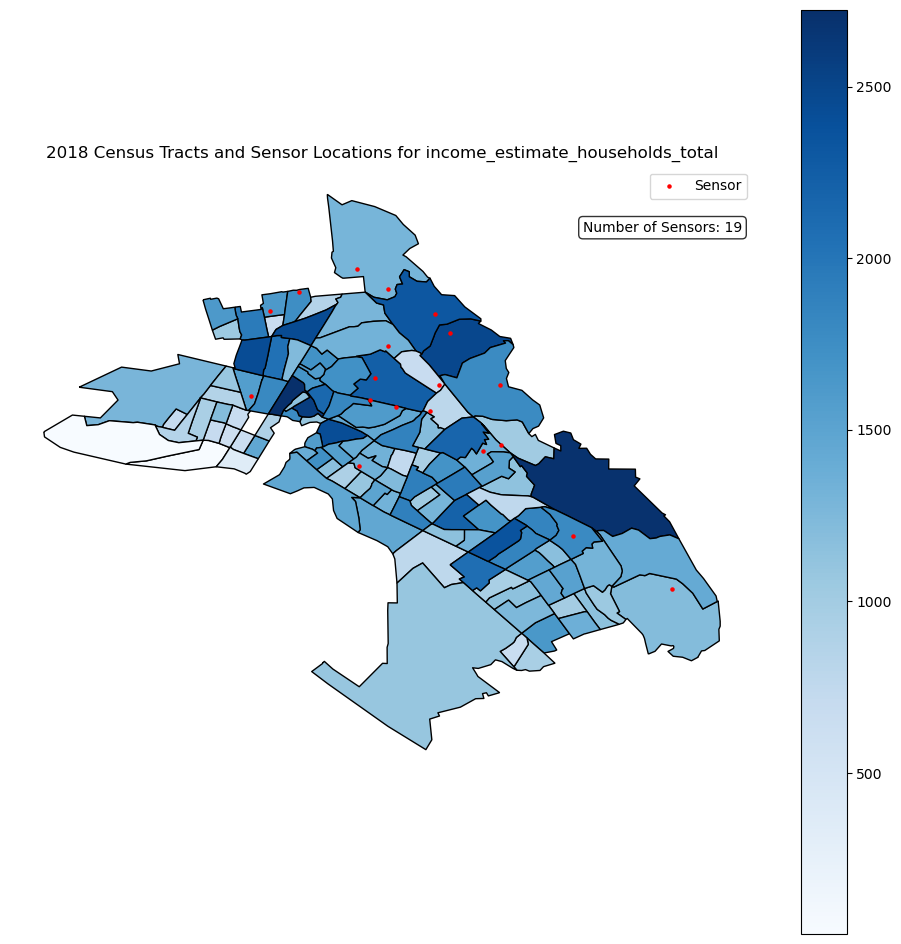

Year 2019
Number of sensors = 36


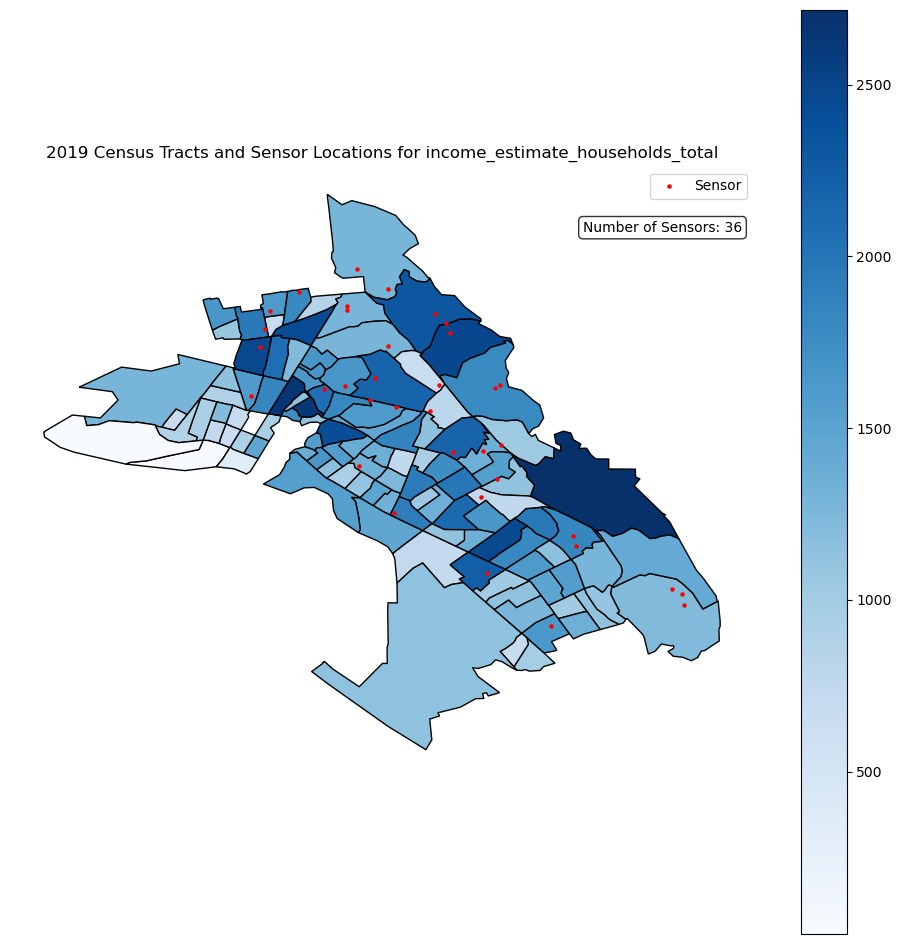

Year 2020
Number of sensors = 138


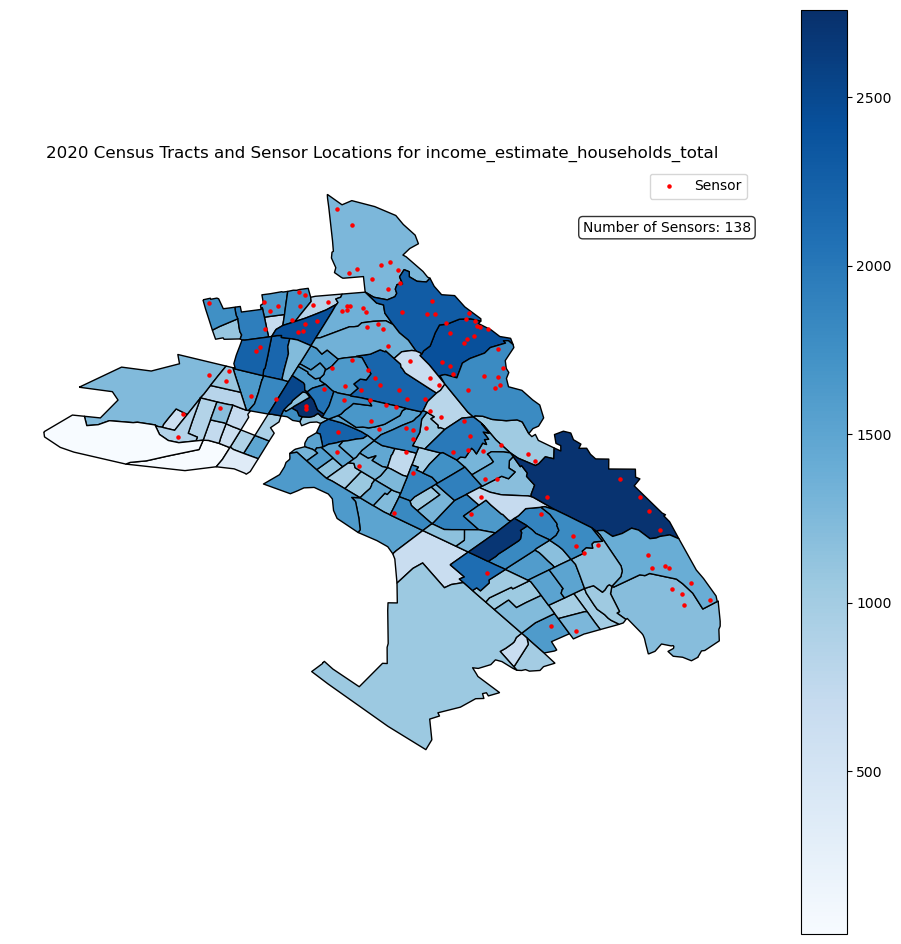

Year 2021
Number of sensors = 174


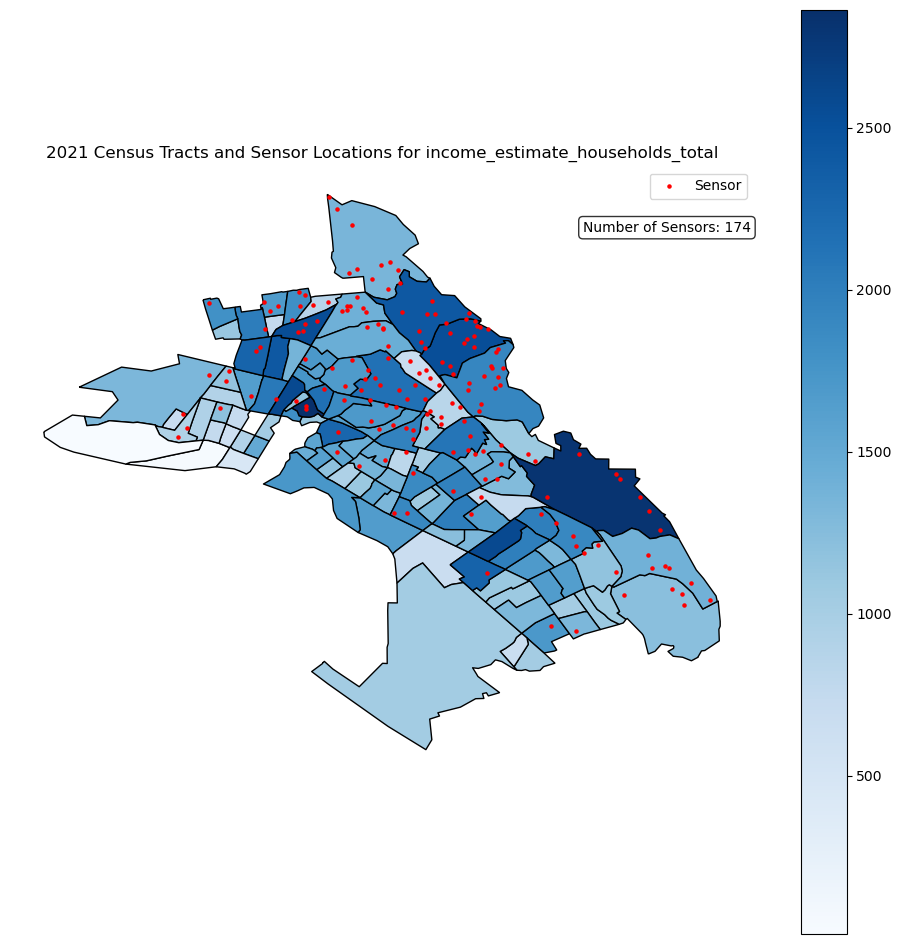

Year 2022
Number of sensors = 188


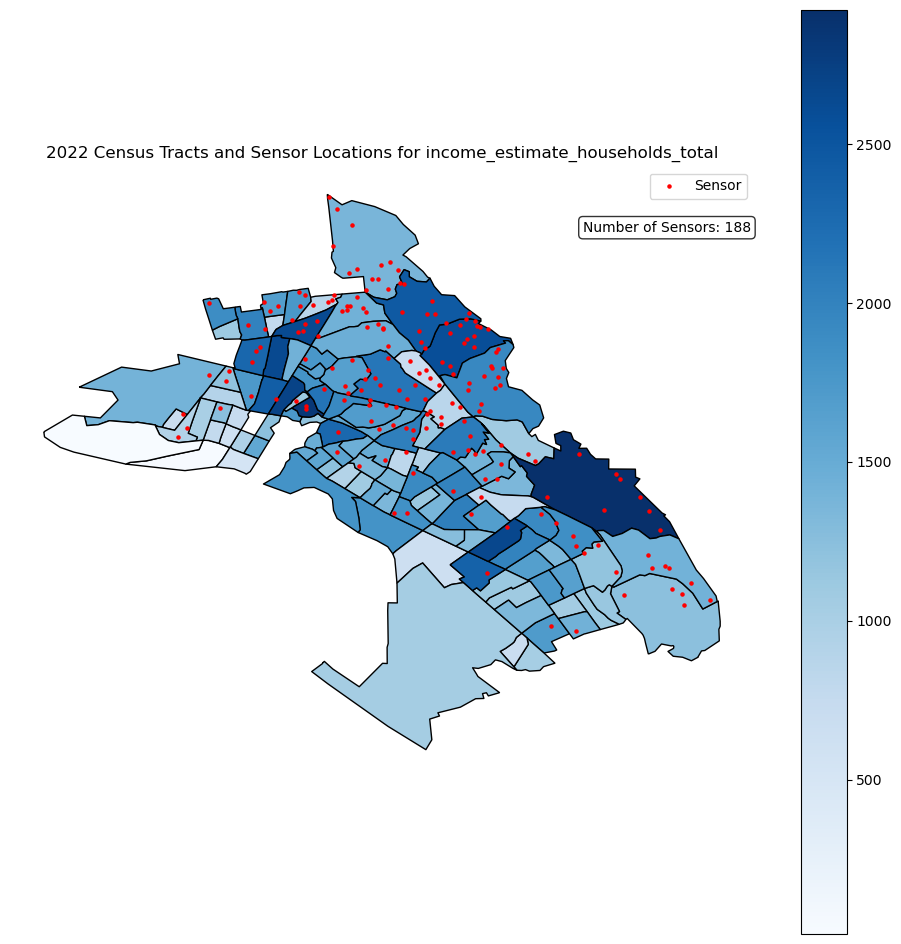

In [435]:
for i in range(2018, 2023, 1):
    print(f"Year {i}")
    plot_census_data(year_of_interest=i)
# plot_census_data(year_of_interest=2019)

In [147]:
# Our sensors duckdb table has all sensor data from our bounding box, but we _only_ want data that maps onto the census tracts.
# We execute a count query, but subquery the merged_census_table so we can filter out the results accurately.
sensor_count_query = "\
    SELECT year_created, COUNT(year_created)\
    FROM merged_sensor_table\
    WHERE AFFGEOID IN (\
        SELECT DISTINCT geography FROM merged_census_table\
        )\
    GROUP BY year_created;"

sensor_count_df = con.execute(sensor_count_query).fetchdf()
#print(sensor_count_df)
sensor_count_df.rename(columns={'count(year_created)': 'count'}, inplace=True)
sensor_count_df.rename(columns={'year_created': 'year'}, inplace=True)
sensor_count_df.describe()

year       count
count     7.000000    7.000000
mean   2021.000000   31.285714
std       2.160247   32.453630
min    2018.000000    7.000000
25%    2019.500000   15.500000
50%    2021.000000   19.000000
75%    2022.500000   30.000000
max    2024.000000  102.000000

## Sensor Installs Over Time

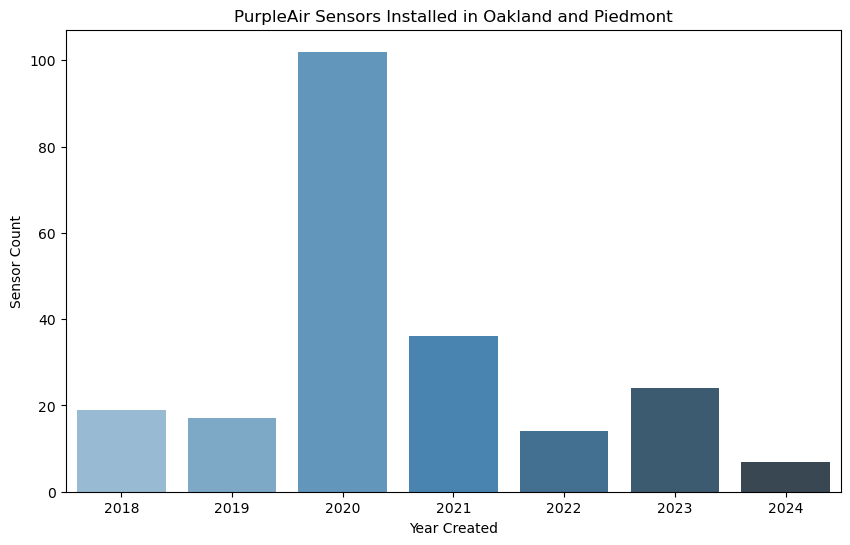

In [475]:
# Plotting the sensors installed by year chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='count', data=sensor_count_df, palette='Blues_d')

# Add labels and title
plt.xlabel('Year Created')
plt.ylabel('Sensor Count')
plt.title('PurpleAir Sensors Installed in Oakland and Piedmont')

# Show the plot
plt.show()

In [149]:
import plotly.express as px

# Assuming 'sensor_count_df' is your DataFrame with 'year' and 'count' columns
fig = px.bar(
    sensor_count_df,
    x='year',
    y='count',
    title='PurpleAir Sensors Installed in Oakland and Piedmont',
    labels={'year': 'Year Created', 'count': 'Sensor Count'},
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Show the plot
fig.show()


We see an explosion of PurpleAir installations in 2020. What caused this? Prompted by wildfires, marketing campaigns? or other circumstances? 

In [476]:
# Modify the query to group by year_created and AFFGEOID
sensor_count_query = """
    SELECT year_created, AFFGEOID, COUNT(*) as sensor_count
    FROM merged_sensor_table
    WHERE AFFGEOID IN (
        SELECT DISTINCT geography FROM merged_census_table
    )
    GROUP BY year_created, AFFGEOID;
"""

# Execute the query and store the result in a DataFrame
sensor_count_df = con.execute(sensor_count_query).fetchdf()

# View the DataFrame
print(sensor_count_df.head())


   year_created              AFFGEOID  sensor_count
0          2021  1400000US06001404800             1
1          2023  1400000US06001404102             1
2          2023  1400000US06001402200             2
3          2023  1400000US06001401500             3
4          2023  1400000US06001406100             1


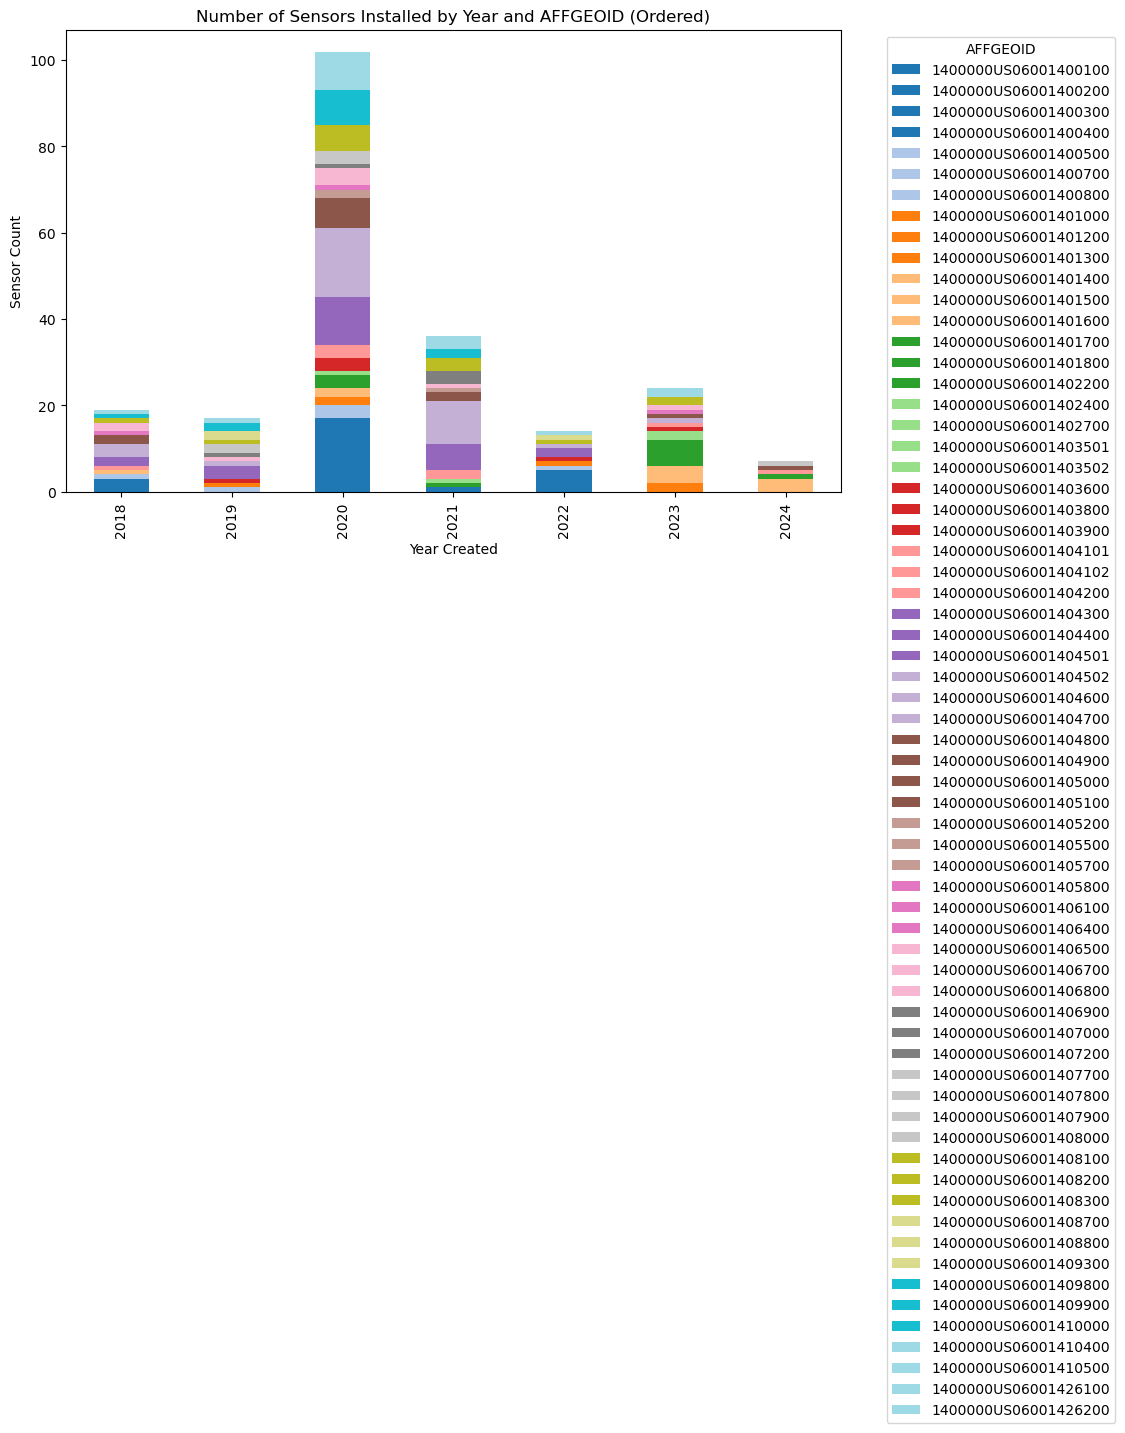

In [480]:
# Pivot the DataFrame to prepare for the stacked bar plot
pivot_df = sensor_count_df.pivot(index='year_created', columns='AFFGEOID', values='sensor_count').fillna(0)

# Reorder the pivoted DataFrame to sort the columns in descending order by sensor count for each year
pivot_df_sorted = pivot_df.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Plot the reordered stacked bar chart
pivot_df_sorted.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='tab20')

# Add labels and title
plt.xlabel('Year Created')
plt.ylabel('Sensor Count')
plt.title('Number of Sensors Installed by Year and AFFGEOID (Ordered)')
plt.legend(title='AFFGEOID', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()


In [486]:
import plotly.io as pio
pio.renderers.default = 'iframe'  # or 'iframe' or 'plotly_mimetype'

%matplotlib inline

# Pivot the DataFrame as before (use either your single-year or top 10 AFFGEOID query result)
pivot_df = sensor_count_df.pivot(index='year_created', columns='AFFGEOID', values='sensor_count').fillna(0)

# Reset the index to make 'year_created' a column
pivot_df.reset_index(inplace=True)

# Melt the pivoted DataFrame to make it compatible with Plotly (long format for stacked bars)
melted_df = pivot_df.melt(id_vars=['year_created'], var_name='AFFGEOID', value_name='sensor_count')

# Plot using Plotly Express
fig = px.bar(melted_df, 
             x='year_created', 
             y='sensor_count', 
             color='AFFGEOID', 
             title='Number of Sensors Installed by Year and AFFGEOID',
             labels={'year_created': 'Year Created', 'sensor_count': 'Sensor Count'},
             hover_data=['AFFGEOID', 'sensor_count'],  # Enable hover for sensor count and AFFGEOID
             height=600,
             width=1000)

# Customize layout
fig.update_layout(barmode='stack', legend_title='AFFGEOID')

# Show the plot
fig.show()

# Save the plot as an HTML file
# output_file = 'yearly_purpleair_sensor_installs.html'
# fig.write_html(output_file)


This is mildly helpful, but our legend is insanely large and difficult to interpret without a colorpicker or a hover over feature.
Still, the "hover-over" feature does mean we could lookup census tracts of interest via eye test.

In [ ]:
# Correlation between sensor count and Census data

We have ~2000 columns of census data. We want to find out what columns in the census data have high negative or positive
correlation with sensor count in a census tract.

In [ ]:
# Get a count of the sensors installed in a particular year for a particular census tract
# Iterate through all cols of interest, calculate the correlation data and store in a df 
# Finish processing the current year, move to the next
# When dataframe is fully populated, stash in duckdb
# Query duckdb for highest correlation values and drill further

# Construct query
# Find all sensors in a particular year
# Find the tracts they are associated with
# Iterate through all columns (avoid or drop NaNs)
# Run the correlation and stash it

census_correlation_query = """
    SELECT year_created, AFFGEOID, COUNT(*) as sensor_count
    FROM merged_sensor_table
    WHERE AFFGEOID IN (
        SELECT DISTINCT geography FROM merged_census_table
    )
    GROUP BY year_created, AFFGEOID;
"""

In [19]:
# Test obtaining the sensor count for a particular year
sensor_test_query  = """
    SELECT year_created, AFFGEOID, COUNT(*) as sensor_count
    FROM merged_sensor_table
    WHERE AFFGEOID IN (
        SELECT DISTINCT geography FROM merged_census_table
    )
    AND year = 2018
    GROUP BY year_created, AFFGEOID;
"""
dated_sensor_count = con.execute(sensor_test_query).fetch_df()
dated_sensor_count.head(1)

year_created              AFFGEOID  sensor_count
0          2018  1400000US06001410000             1

In [61]:
# We now need to locate the rows in the merged_census_table to work with
census_test_query = """
    SELECT *
    FROM merged_census_table
    WHERE geography IN (
        SELECT DISTINCT AFFGEOID FROM merged_sensor_table
        WHERE year = 2018
        AND merged_sensor_table.AFFGEOID = merged_census_table.geography
    )
    AND year = 2018
    -- GROUP BY year_created, AFFGEOID;
"""

dated_census_result = con.execute(census_test_query).fetch_df()
dated_census_result.head(1)

geography                              geographic_area_name   
0  1400000US06001404501  Census Tract 4045.01, Alameda County, California  \

   race_estimate_total  race_margin_of_error_total   
0               1795.0                       112.0  \

   race_estimate_total_white_alone  race_margin_of_error_total_white_alone   
0                           1278.0                                   143.0  \

   race_estimate_total_black_or_african_american_alone   
0                                               73.0    \

   race_margin_of_error_total_black_or_african_american_alone   
0                                               52.0           \

   race_estimate_total_american_indian_and_alaska_native_alone   
0                                                0.0            \

   race_margin_of_error_total_american_indian_and_alaska_native_alone  ...   
0                                               12.0                   ...  \

   educational_attainment_estimate_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate   
0                                               None                                                                                                                                                   \

   educational_attainment_margin_of_error_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate   
0                                               None                                                                                                                                                          \

   educational_attainment_estimate_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_high_school_graduate_includes_equivalency_   
0                                               None                                                                                                                                                               \

   educational_attainment_margin_of_error_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_high_school_graduate_includes_equivalency_   
0                                               None                                                                                                                                                                      \

   educational_attainment_estimate_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_some_college_or_associates_degree   
0                                               None                                                                                                                                                      \

   educational_attainment_margin_of_error_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_some_college_or_associates_degree   
0                                               None                                                                                                                                                             \

   educational_attainment_estimate_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_bachelors_degree   
0                                               None                                                                                                                                     \

   educational_attainment_margin_of_error_percent_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_

In [62]:
# Merged columns to ignore
columns_to_ignore = ['geography', 'geographic_area_name', 'sensor_count', 'year_created', 'year', 'AFFGEOID']
# With our census data, we merge
dated_merged_data = pd.merge(dated_sensor_count,dated_census_result, how='left', left_on='AFFGEOID', right_on='geography')


In [63]:
# Check for NaN values in each column
print(dated_merged_data.isna().sum())


year_created                                                                                                                                                                                                     0
AFFGEOID                                                                                                                                                                                                         0
sensor_count                                                                                                                                                                                                     0
geography                                                                                                                                                                                                        0
geographic_area_name                                                                                                                                        

In [85]:
from scipy.stats import pearsonr
import numpy as np

# Columns to ignore
columns_to_ignore = ['year_created', 'AFFGEOID', 'sensor_count', 'geography', 'geographic_area_name']  # Example columns
top_correlation_columns_dict = {'census_column':[],'correlation':[]}
for col in dated_merged_data.columns:
    if col not in columns_to_ignore:
        print(f"Processing {col}\n\n")

        # Drop NaNs only for the current column (not sensor_count, as it should not have NaNs)
        valid_data = dated_merged_data.dropna(subset=[col])
        
        # Ensure that valid data still has enough rows after dropping NaNs
        if len(valid_data) > 1:
            try:
                print("Generating correlation")
                # Calculate Pearson correlation coefficient
                correlation, _ = pearsonr(valid_data[col], valid_data['sensor_count'])
                print(f"Correlation: {correlation}")
                if correlation > 0.1:  # Adjust the threshold as needed
                    print(f'Column {col} has high correlation')
                    top_correlation_columns_dict['census_column'].append(col)
                    top_correlation_columns_dict['correlation'].append(correlation)
            except Exception as e:
                print(f"Error processing column {col}: {e}")
        else:
            print(f"Not enough data for correlation in column {col}.\n\n")
        
    print(f"Done processing {col}\n\n")

# print(top_correlation_columns_dict)

Done processing year_created


Done processing AFFGEOID


Done processing sensor_count


Done processing geography


Done processing geographic_area_name


Processing race_estimate_total


Generating correlation
Correlation: -0.19821641943933546
Done processing race_estimate_total


Processing race_margin_of_error_total


Generating correlation
Correlation: -0.24928438606343548
Done processing race_margin_of_error_total


Processing race_estimate_total_white_alone


Generating correlation
Correlation: -0.08865962748185978
Done processing race_estimate_total_white_alone


Processing race_margin_of_error_total_white_alone


Generating correlation
Correlation: -0.188696745828711
Done processing race_margin_of_error_total_white_alone


Processing race_estimate_total_black_or_african_american_alone


Generating correlation
Correlation: -0.12107307666501199
Done processing race_estimate_total_black_or_african_american_alone


Processing race_margin_of_error_total_black_or_african_american_al

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Generating correlation
Correlation: -0.14907520556916581
Done processing sex_by_age_by_educational_attainment_estimate_total_female_25_to_34_years_some_college_no_degree


Processing sex_by_age_by_educational_attainment_margin_of_error_total_female_25_to_34_years_some_college_no_degree


Generating correlation
Correlation: -0.21411358353245152
Done processing sex_by_age_by_educational_attainment_margin_of_error_total_female_25_to_34_years_some_college_no_degree


Processing sex_by_age_by_educational_attainment_estimate_total_female_25_to_34_years_associates_degree


Generating correlation
Correlation: -0.27874328303913865
Done processing sex_by_age_by_educational_attainment_estimate_total_female_25_to_34_years_associates_degree


Processing sex_by_age_by_educational_attainment_margin_of_error_total_female_25_to_34_years_associates_degree


Generating correlation
Correlation: -0.2446218981128042
Done processing sex_by_age_by_educational_attainment_margin_of_error_total_female_25_to_34_y

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Generating correlation
Correlation: -0.011232969926030276
Done processing educational_attainment_margin_of_error_percent_female_moe_population_25_years_and_over_less_than_9th_grade


Processing educational_attainment_estimate_percent_population_25_years_and_over_9th_to_12th_grade_no_diploma


Generating correlation
Correlation: -0.04949203370610039
Done processing educational_attainment_estimate_percent_population_25_years_and_over_9th_to_12th_grade_no_diploma


Processing educational_attainment_margin_of_error_percent_moe_population_25_years_and_over_9th_to_12th_grade_no_diploma


Generating correlation
Correlation: -0.08471933925218393
Done processing educational_attainment_margin_of_error_percent_moe_population_25_years_and_over_9th_to_12th_grade_no_diploma


Processing educational_attainment_estimate_male_population_25_years_and_over_9th_to_12th_grade_no_diploma


Generating correlation
Correlation: -0.2028480677338077
Done processing educational_attainment_estimate_male_population

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Generating correlation
Correlation: 0.138602477493156
Column educational_attainment_estimate_percent_male_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher has high correlation
Done processing educational_attainment_estimate_percent_male_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher


Processing educational_attainment_margin_of_error_percent_male_moe_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher


Generating correlation
Correlation: 0.20506702165843083
Column educational_attainment_margin_of_error_percent_male_moe_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher has high correlation
Done processing educational_attainment_margin_of_error_percent_male_moe_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher


Processing educational_attainment_estimate_female_population_25_years_and_over_population_25_to_34_years_bachelors_de

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Generating correlation
Correlation: -0.16247658188777783
Done processing educational_attainment_margin_of_error_percent_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_high_school_graduate_or_higher


Processing educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_high_school_graduate_or_higher


Generating correlation
Correlation: -0.04347358529184777
Done processing educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_high_school_graduate_or_higher


Processing educational_attainment_margin_of_error_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_high_school_graduate_or_higher


Generating correlation
Correlation: -0.28493005736668875
Done processing educational_attainment_margin_of_error_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_high_school_graduate_or_higher


Processi

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Generating correlation
Correlation: nan
Done processing educational_attainment_margin_of_error_percent_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone


Processing educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone


Generating correlation
Correlation: -0.26195078811126743
Done processing educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone


Processing educational_attainment_margin_of_error_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone


Generating correlation
Correlation: -0.26577666419108276
Done processing educational_attainment_margin_of_error_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone


Processing educational_attainment_estimate_pe

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Generating correlation
Correlation: nan
Done processing educational_attainment_estimate_percent_female_median_earnings_in_the_past_12_months_in_2018_inflation_adjusted_dollars__population_25_years_and_over_with_earnings


Processing educational_attainment_margin_of_error_percent_female_moe_median_earnings_in_the_past_12_months_in_2018_inflation_adjusted_dollars__population_25_years_and_over_with_earnings


Generating correlation
Correlation: nan
Done processing educational_attainment_margin_of_error_percent_female_moe_median_earnings_in_the_past_12_months_in_2018_inflation_adjusted_dollars__population_25_years_and_over_with_earnings


Processing educational_attainment_estimate_percent_median_earnings_in_the_past_12_months_in_2018_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate


Generating correlation
Correlation: nan
Done processing educational_attainment_estimate_percent_median_earnings_in_the_past_12_months_in_2018_inflation_adju

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Generating correlation
Correlation: -0.22195175594865696
Done processing income_estimate_families_total_150_000_to_199_999


Processing income_margin_of_error_families_moe_total_150_000_to_199_999


Generating correlation
Correlation: -0.09562027878366751
Done processing income_margin_of_error_families_moe_total_150_000_to_199_999


Processing income_estimate_married_couple_families_total_150_000_to_199_999


Generating correlation
Correlation: -0.2522175172678868
Done processing income_estimate_married_couple_families_total_150_000_to_199_999


Processing income_margin_of_error_married_couple_families_moe_total_150_000_to_199_999


Generating correlation
Correlation: -0.14781646695786257
Done processing income_margin_of_error_married_couple_families_moe_total_150_000_to_199_999


Processing income_estimate_nonfamily_households_total_150_000_to_199_999


Generating correlation
Correlation: 0.044617483879772886
Done processing income_estimate_nonfamily_households_total_150_000_to_199_99

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Not enough data for correlation in column educational_attainment_margin_of_error_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino_high_school_graduate_or_higher.


Done processing educational_attainment_margin_of_error_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino_high_school_graduate_or_higher


Processing educational_attainment_margin_of_error_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino_bachelors_degree_or_higher


Not enough data for correlation in column educational_attainment_margin_of_error_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino_bachelors_degree_or_higher.


Done processing educational_attainment_margin_of_error_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino_bachelors_degree_or_higher


Processing educati

In [93]:
# print(top_correlation_columns_dict)
top_correlation_df = pd.DataFrame(top_correlation_columns_dict)
top_correlation_df.head(5)

census_column  correlation
0  sex_by_age_by_educational_attainment_estimate_...     0.187830
1  sex_by_age_by_educational_attainment_margin_of...     0.153407
2  sex_by_age_by_educational_attainment_estimate_...     0.537484
3  sex_by_age_by_educational_attainment_estimate_...     0.294866
4  sex_by_age_by_educational_attainment_margin_of...     0.109886

In [94]:
# Filter for correlations > 0.5
# Assuming 'column_name' is the name of the column you want to filter on
filtered_correlation_df = top_correlation_df[top_correlation_df['correlation'] > 0.55]

# View the filtered DataFrame
filtered_correlation_df.head()
filtered_correlation_df.iloc[0]

census_column    sex_by_age_by_educational_attainment_estimate_...
correlation                                               0.550372
Name: 17, dtype: object

In [ ]:
dated_merged_data.head()

In [23]:
dated_merged_data = pd.merge(dated_sensor_count,dated_census_result,how='left', left_on='AFFGEOID', right_on='geography')
dated_merged_data.describe()

year_created  sensor_count  race_estimate_total   
count          64.0     64.000000            16.000000  \
mean         2018.0      1.187500          4162.750000   
std             0.0      0.393398          1284.255971   
min          2018.0      1.000000          1795.000000   
25%          2018.0      1.000000          3474.250000   
50%          2018.0      1.000000          4086.500000   
75%          2018.0      1.000000          4846.750000   
max          2018.0      2.000000          6404.000000   

       race_margin_of_error_total  race_estimate_total_white_alone   
count                   16.000000                         16.00000  \
mean                   283.500000                       2420.75000   
std                    103.824853                       1216.66284   
min                    112.000000                       1155.00000   
25%                    221.250000                       1361.00000   
50%                    265.500000                       2079.00000   
75%                    357.750000                       2869.25000   
max                    502.000000                       4906.00000   

       race_margin_of_error_total_white_alone   
count                               16.000000  \
mean                               255.812500   
std                                 71.374336   
min                                143.000000   
25%                                227.000000   
50%                                253.000000   
75%                                279.000000   
max                                413.000000   

       race_estimate_total_black_or_african_american_alone   
count                                          16.000000    \
mean                                          564.687500     
std                                           572.417996     
min                                            73.000000     
25%                                           132.500000     
50%                                           236.500000     
75%                                           928.500000     
max                                          1858.000000     

       race_margin_of_error_total_black_or_african_american_alone   
count                                          16.000000           \
mean                                          186.062500            
std                                           116.298735            
min                                            52.000000            
25%                                            89.500000            
50%                                           138.000000            
75%                                           311.500000            
max                                           380.000000            

       race_estimate_total_american_indian_and_alaska_native_alone   
count                                          16.000000            \
mean                                           20.312500             
std                                            29.456677             
min                                             0.000000             
25%                                             0.000000             
50%                                             9.000000             
75%                                            25.250000             
max                                            99.000000             

       race_margin_of_error_total_american_indian_and_alaska_native_alone   
count                                            16.0000                   \
mean                                             26.6250                    
std                                              26.9218                    
min                                               9.0000                    
25%                                              12.0000                    
50%                                              13.0000                    
75%                                              26.7500    

## Generate Correlation Data

### get_sensor_data_for_year

In [158]:
# Function to return year-specific sensor data
def get_sensor_data_for_year(con, year_of_interest):
    sensor_query  = f"""
        SELECT year_created, AFFGEOID, COUNT(*) as sensor_count
        FROM merged_sensor_table
        WHERE AFFGEOID IN (
            SELECT DISTINCT geography FROM merged_census_table
        )
        AND year = {year_of_interest}
        GROUP BY year_created, AFFGEOID;
    """
    # print(f"{sensor_query}")
    output_sensor_df = con.execute(sensor_query).fetch_df()
    return(output_sensor_df)


### get_census_data_for_year

In [159]:
# Function to obtain year-specific census data
def get_census_data_for_year(con, year_of_interest):
    census_query = f"""
        SELECT *
        FROM merged_census_table
        WHERE geography IN (
            SELECT DISTINCT AFFGEOID FROM merged_sensor_table
            WHERE year = {year_of_interest}
            AND merged_sensor_table.AFFGEOID = merged_census_table.geography
        )
        AND year = {year_of_interest}
        -- GROUP BY year_created, AFFGEOID;
    """

    output_census_df = con.execute(census_query).fetch_df()
    return(output_census_df)

### generate_corr_per_year

In [175]:
# Create function to generate correlations, return a dataframe
def generate_corr_per_year(columns_to_ignore, merged_census_sensor_df, year):
    # Create dict to store our intermediate correlation values
    correlation_columns_dict = {'census_column':[],'correlation':[]}  
    for col in merged_census_sensor_df.columns:
        if col not in columns_to_ignore:
            # print(f"Processing {col}\n\n")
    
            # Drop NaNs only for the current column (not sensor_count, as it should not have NaNs)
            valid_data = merged_census_sensor_df.dropna(subset=[col])
            
            # Ensure that valid data still has enough rows after dropping NaNs
            if len(valid_data) > 1:
                try:
                    #print("Generating correlation")
                    # Calculate Pearson correlation coefficient
                    correlation, _ = pearsonr(valid_data[col], valid_data['sensor_count'])
                    # print(f"Correlation: {correlation}")
                    if correlation > 0.1 or correlation < -0.1:  # Adjust the threshold as needed
                        if correlation > 0.5: # Echo higher correlation to screen
                            print(f'Column {col} has high positive correlation')
                        correlation_columns_dict['census_column'].append(col)
                        correlation_columns_dict['correlation'].append(correlation)
                except Exception as e:
                    print(f"Error processing column {col}: {e}")
            else:
                print(f"Not enough data for correlation in column {col}.\n\n")

    # Convert the dict into a dataframe
    correlations_df = pd.DataFrame(correlation_columns_dict)
    # Set the year for all rows to the input year
    correlations_df['year'] = year
    # Return our dataframe
    return(correlations_df)


# Merge Census and Sensor Data

In [176]:
# Merged columns to ignore
columns_to_ignore = ['geography', 'geographic_area_name', 'sensor_count', 'year_created', 'year', 'AFFGEOID']

# Create an empty dataframe, to which we will concat our correlation output
merged_corr_df = pd.DataFrame(columns=["census_column","correlation", "year"])
# Iterate through ranges of years
for year in range(2018, 2023, 1):
    print(f"Year {year}")
    sensor_data_for_year = get_sensor_data_for_year(con, year)
    census_data_for_year = get_census_data_for_year(con, year)  
    
    # Merge Census and Sensor data. 
    merged_census_and_sensor_data = pd.merge(sensor_data_for_year,
                                             census_data_for_year,
                                             how='left', 
                                             left_on='AFFGEOID',
                                             right_on='geography')
    corr_df = generate_corr_per_year(columns_to_ignore, merged_census_and_sensor_data, year)
    # Concatenate the output df for a year onto merged_corr_df
    merged_corr_df = pd.concat([merged_corr_df, corr_df], axis=0, ignore_index=True, sort=False)

merged_corr_df.describe()

Year 2018
Column sex_by_age_by_educational_attainment_estimate_total_male_18_to_24_years_graduate_or_professional_degree has high positive correlation
Column sex_by_age_by_educational_attainment_estimate_total_female_18_to_24_years_associates_degree has high positive correlation
Column sex_by_age_by_educational_attainment_margin_of_error_total_female_18_to_24_years_associates_degree has high positive correlation
Not enough data for correlation in column race_estimate_total_.


Not enough data for correlation in column race_margin_of_error_total_.


Not enough data for correlation in column race_estimate_total__white_alone.


Not enough data for correlation in column race_margin_of_error_total__white_alone.


Not enough data for correlation in column race_estimate_total__black_or_african_american_alone.


Not enough data for correlation in column race_margin_of_error_total__black_or_african_american_alone.


Not enough data for correlation in column race_estimate_total__american_indian_

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Not enough data for correlation in column educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin.


Not enough data for correlation in column educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin.


Not enough data for correlation in column educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_moe_r

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Not enough data for correlation in column income_estimate_married_couple_families_mean_income_dollars_.


Not enough data for correlation in column income_margin_of_error_married_couple_families_moe_mean_income_dollars_.


Not enough data for correlation in column income_estimate_families_percent_allocated_household_income_in_the_past_12_months.


Not enough data for correlation in column income_margin_of_error_families_moe_percent_allocated_household_income_in_the_past_12_months.


Not enough data for correlation in column income_estimate_married_couple_families_percent_allocated_household_income_in_the_past_12_months.


Not enough data for correlation in column income_margin_of_error_married_couple_families_moe_percent_allocated_household_income_in_the_past_12_months.


Not enough data for correlation in column income_estimate_nonfamily_households_percent_allocated_household_income_in_the_past_12_months.


Not enough data for correlation in column income_margin_of_error_nonfamily_hou

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years.


Not enough data for correlation in column educational_attainment_margin_of_error_total_moe_population_18_to_24_years.


Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_margin_of_error_total_moe_population_18_to_24_years_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years_high_school_graduate_includes_equivalency_.


Not enough data for correlation in column educational_attainment_margin_of_error_total_moe_population_18_to_24_years_high_school_graduate_includes_equivalency_.


Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years_some_college_or_associates_degree.


Not enough data for co

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone.


Column educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher has high positive correlation
Not enough data for correlation in column educational_attainment_margin_of_error_percent_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher.


Not enough data for correlation in column educational_attainment_margin_of_error_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_h

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Not enough data for correlation in column educational_attainment_margin_of_error_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_asian_alone.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_race_a

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_black_alone.


Column educational_attainment_margin_of_error_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_black_alone_high_school_graduate_or_higher has high positive correlation
Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone.


Not enough data for correlation in column educational_attainment_ma

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Column sex_by_age_by_educational_attainment_margin_of_error_total__female__45_to_64_years__graduate_or_professional_degree has high positive correlation
Column sex_by_age_by_educational_attainment_estimate_total__female__65_years_and_over__bachelors_degree has high positive correlation
Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years.


Not enough data for correlation in column educational_attainment_margin_of_error_total_moe_population_18_to_24_years.


Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_margin_of_error_total_moe_population_18_to_24_years_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years_high_school_graduate_includes_equivalency_.


Not enough data for correlation in column

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Not enough data for correlation in column educational_attainment_margin_of_error_female_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone.


Not enough data for correlation in column educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher.


Not enough data for correlation in column educational_attainment_margin_of_error_male_moe_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher.


Not enough data for correlation in column ed

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Not enough data for correlation in column educational_attainment_estimate_percent_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings.


Not enough data for correlation in column educational_attainment_estimate_percent_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_estimate_percent_median_earnings_in_the_past_12_mon

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Column sex_by_age_by_educational_attainment_estimate_total__male__65_years_and_over__9th_to_12th_grade_no_diploma has high positive correlation
Column sex_by_age_by_educational_attainment_margin_of_error_total__male__65_years_and_over__9th_to_12th_grade_no_diploma has high positive correlation
Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years.


Not enough data for correlation in column educational_attainment_margin_of_error_total_moe_population_18_to_24_years.


Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_margin_of_error_total_moe_population_18_to_24_years_less_than_high_school_graduate.


Not enough data for correlation in column educational_attainment_estimate_total_population_18_to_24_years_high_school_graduate_includes_equivalency_.


Not enough data for correlation i

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Not enough data for correlation in column educational_attainment_margin_of_error_female_moe_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_bachelors_degree_or_higher.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_female_moe_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_bachelors_degree_or_higher.


Not enough data for correlation in column educational_attainment_estimate_percent_median_earnings_in_the_past_12_months_in_2018_inflation_adjusted_dollars__population_25_years_and_over_with_earnings.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_moe_median_earnings_in_the_past_12_months_in_2018_inflation_adjusted_dollars__population_25_years_and_over_with_earnings.


Not enough data for correlation in column educational_attainment_estimate_male_median_earning

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

Column educational_attainment_margin_of_error_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher has high positive correlation
Column educational_attainment_margin_of_error_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher has high positive correlation
Not enough data for correlation in column educational_attainment_margin_of_error_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races.


Not enough data for correlation in column educational_attainment_margin_of_error_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin.


Column educational_attainment_margin_of_error_percent_male_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_high_school_graduate_includes_equivalency_ has high positiv

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\lover\AppData\Roaming\Python\Python39\site-packages

race_estimate_total  race_margin_of_error_total   
count           114.000000                  114.000000  \
mean           7466.701754                  328.210526   
std           39111.952673                  155.578536   
min              60.000000                   27.000000   
25%            2722.000000                  222.000000   
50%            3722.500000                  300.000000   
75%            4735.250000                  419.500000   
max          421042.000000                  776.000000   

       race_estimate_total_white_alone   
count                       114.000000  \
mean                       2776.131579   
std                       14160.887648   
min                          21.000000   
25%                         741.750000   
50%                        1187.500000   
75%                        1850.250000   
max                      152168.000000   

       race_margin_of_error_total_white_alone   
count                              114.000000  \
mean                               276.833333   
std                                247.838440   
min                                 17.000000   
25%                                179.250000   
50%                                238.500000   
75%                                312.250000   
max                               2613.000000   

       race_estimate_total_black_or_african_american_alone   
count                                         114.000000    \
mean                                         1721.087719     
std                                          9254.205576     
min                                             0.000000     
25%                                           330.000000     
50%                                           741.500000     
75%                                          1219.750000     
max                                         99416.000000     

       race_margin_of_error_total_black_or_african_american_alone   
count                                         114.000000           \
mean                                          242.122807            
std                                           228.490357            
min                                            12.000000            
25%                                           133.500000            
50%                                           211.500000            
75%                                           306.500000            
max                                          2258.000000            

       race_estimate_total_american_indian_and_alaska_native_alone   
count                                         114.000000            \
mean                                           66.105263             
std                                           359.398696             
min                                             0.000000             
25%                                             0.000000             
50%                                            14.500000             
75%                                            43.000000             
max                                          3834.000000             

       race_margin_of_error_total_american_indian_and_alaska_native_alone   
count                                         114.000000                   \
mean                                           45.429825                    
std                                            74.558283                    
min                                             3.000000                    
25%                                            12.000000                    
50%                                            20.000000                    
75%                                            48.500000                    
max                                           669.000000                    

       race_estimate_total_asian_alone   
count                       114.000000  \
mean                       1158.482456   
std                        6162

In [180]:
merged_corr_df.head()

census_column  correlation  year
0                                race_estimate_total    -0.198216  2018
1                         race_margin_of_error_total    -0.249284  2018
2             race_margin_of_error_total_white_alone    -0.188697  2018
3  race_estimate_total_black_or_african_american_...    -0.121073  2018
4  race_estimate_total_american_indian_and_alaska...    -0.212994  2018

In [181]:
# Convert the merged_corr_df into a duckdb table
con.execute("CREATE TABLE merged_corr_table AS SELECT * FROM merged_corr_df")

In [229]:
# Reset colwidth to deal with long column names
pd.reset_option('display.max_colwidth')

corr_result = con.execute("SELECT * from merged_corr_table\
                    WHERE correlation > 0.65\
                    AND year = 2019\
                    -- AND census_column LIKE 'sex_by_age%'\
                    ORDER BY correlation ASCENDING\
                    -- LIMIT 10"
                         ).fetch_df()
print(corr_result)

                                       census_column  correlation  year
0  educational_attainment_estimate_percent_female...     0.871231  2019
1  educational_attainment_margin_of_error_total_r...     0.672182  2019
2  educational_attainment_margin_of_error_total_r...     0.690391  2019
3  educational_attainment_margin_of_error_female_...     0.719041  2019
4  educational_attainment_margin_of_error_female_...     0.725787  2019
5  educational_attainment_estimate_percent_female...     0.736325  2019
6  educational_attainment_margin_of_error_percent...     0.729116  2019
7  educational_attainment_margin_of_error_percent...     0.651638  2019


# Set Column Display Width

In [ ]:

# Set Pandas display options to show all columns
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows (if needed)

# Set Pandas option to avoid truncating wide columns
pd.set_option('display.max_colwidth', None)

# filtered_result_df = corr_result.query('correlation > 0.80')
# print(filtered_result_df['correlation'])

# print(corr_result.iloc[4])

# Reset colwidth to deal with long column names
pd.reset_option('display.max_colwidth')

# # Now when you access the row's index or print it, it should not truncate
# row_587 = df.loc[587]
# print(row_587.index)  # Should display all columns without ellipsis

# Reset options back to default after checking (optional)
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')


# Correlation Matrix

In [254]:
# Compute a correlation matrix. This was exploration to see if any of our
# columns were correlated among themselves, not with sensor counts. It is 
# unclear if this relationship is transitive.

correlation_matrix = census_data_df.corr()


#fig = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale='RdBu_r', aspect="auto")
# Modify this line to use a different palette
fig = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale='Inferno', aspect="auto")

# Update layout to hide x and y axis labels
fig.update_layout(
    title="Correlation Heatmap without Axis Labels",
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False)
)

# Display the plot
fig.show()

## find_corr_by_year

In [19]:
# Create a database searching function to locate correlations based on threshold,
# a pattern describing the census_column, and the year
def find_corr_by_year(con, corr_threshold, census_year, column_pattern='%', positive=True):
    if positive:
        operand = ">"
    else:
        operand = "<"
    query = f"""SELECT * from merged_corr_table\
                    WHERE correlation {operand} {corr_threshold}\
                    AND year = {census_year}\
                    AND census_column LIKE '{column_pattern}%'\
                    -- ORDER BY correlation ASCENDING\
                    -- LIMIT 10\
                    """
    # print(query)
    query_result = con.execute(query).fetch_df()
    return(query_result)

# Median and Mean Income Levels

Let us take a look at how income (Census Table ID S1901) levels of census tracts correlate with distribution of PurpleAir sensors. Are higher-income areas in Oakland/Piedmont more or less likely to have sensors installed?

## census_column_search

In [686]:
# We will need to search through thousands of columns to locate columns prefix patterned on our Census Table IDs.
# The code below shows how this could be done for the 'income' related columns.

def census_column_search(search_string, con=con):
    # Test query
    test_census_query_df = con.execute("SELECT * FROM merged_census_table LIMIT 1").fetch_df()
    
    # Query for columns that match our criteria. Filter column names that contain the substring 'income'
    matching_columns = test_census_query_df.columns[test_census_query_df.columns.str.contains(search_string, case=False, regex=True)]
    return(matching_columns)

census_column_search('income.*median')

Index(['income_estimate_households_median_income_dollars_',
       'income_margin_of_error_households_moe_median_income_dollars_',
       'income_estimate_families_median_income_dollars_',
       'income_margin_of_error_families_moe_median_income_dollars_',
       'income_estimate_married_couple_families_median_income_dollars_',
       'income_margin_of_error_married_couple_families_moe_median_income_dollars_',
       'income_estimate_nonfamily_households_median_income_dollars_',
       'income_margin_of_error_nonfamily_households_moe_median_income_dollars_',
       'income_margin_of_error_households_median_income_dollars_',
       'income_margin_of_error_families_median_income_dollars_',
       'income_margin_of_error_married_couple_families_median_income_dollars_',
       'income_margin_of_error_nonfamily_households_median_income_dollars_'],
      dtype='object')

In [307]:
# We will select the column 'income_estimate_families_median_income_dollars_' for our table

median_income_by_tract_df = con.execute("SELECT c.geography, c.geographic_area_name, ANY_VALUE(c.income_estimate_families_median_income_dollars_), COUNT(s.sensor_index) as sensor_count\
                                        FROM merged_census_table AS c, merged_sensor_table AS s\
                                        WHERE c.geography = s.AFFGEOID\
                                        AND c.year = s.year_created\
                                        AND c.year = 2018\
                                        GROUP BY c.geography, c.geographic_area_name\
                                        ORDER BY sensor_count DESC\
                                        "
                         ).fetch_df()


# print(median_income_by_tract_df)
print(median_income_by_tract_df['sensor_count'].sum())
# print(len(median_income_by_tract_df['geography'].unique()))

76


In [355]:
# Obtain simple sensor counts direct from merged_sensor_table for a single year
con.sql('SELECT DISTINCT s.AFFGEOID, COUNT(s.sensor_index)\
        FROM merged_sensor_table AS s\
        WHERE s.year_created = 2018\
        GROUP BY s.AFFGEOID\
        ')

┌──────────────────────┬───────────────────────┐
│       AFFGEOID       │ count(s.sensor_index) │
│       varchar        │         int64         │
├──────────────────────┼───────────────────────┤
│ 1400000US06001400100 │                     2 │
│ 1400000US06001401400 │                     1 │
│ 1400000US06001427100 │                     1 │
│ 1400000US06001422700 │                     1 │
│ 1400000US06001406800 │                     2 │
│ 1400000US06001421800 │                     1 │
│ 1400000US06001404600 │                     1 │
│ 1400000US06001422500 │                     1 │
│ 1400000US06001427300 │                     1 │
│ 1400000US06001404700 │                     1 │
│          ·           │                     · │
│          ·           │                     · │
│          ·           │                     · │
│ 1400000US06001404200 │                     1 │
│ 1400000US06001422600 │                     2 │
│ 1400000US06001424001 │                     1 │
│ 1400000US060014261

In [363]:
# Obtain the same sensor counts, but add additional info on the census tract's name
con.sql('SELECT sensor_counts.AFFGEOID, sensor_counts.sensor_count, c.geographic_area_name \
        FROM ( \
            SELECT s.AFFGEOID, COUNT(s.sensor_index) AS sensor_count \
            FROM merged_sensor_table AS s \
            WHERE s.year_created = 2018 \
            GROUP BY s.AFFGEOID \
        ) AS sensor_counts \
        LEFT JOIN ( \
            SELECT DISTINCT ON (geography) geography, geographic_area_name \
            FROM merged_census_table \
        ) AS c \
        ON sensor_counts.AFFGEOID = c.geography\
        WHERE c.geographic_area_name IS NOT NULL')


┌──────────────────────┬──────────────┬──────────────────────────────────────────────────┐
│       AFFGEOID       │ sensor_count │               geographic_area_name               │
│       varchar        │    int64     │                     varchar                      │
├──────────────────────┼──────────────┼──────────────────────────────────────────────────┤
│ 1400000US06001408300 │            1 │ Census Tract 4083, Alameda County, California    │
│ 1400000US06001400400 │            1 │ Census Tract 4004, Alameda County, California    │
│ 1400000US06001404501 │            1 │ Census Tract 4045.01, Alameda County, California │
│ 1400000US06001405800 │            1 │ Census Tract 4058, Alameda County, California    │
│ 1400000US06001426100 │            1 │ Census Tract 4261, Alameda County, California    │
│ 1400000US06001401400 │            1 │ Census Tract 4014, Alameda County, California    │
│ 1400000US06001404200 │            1 │ Census Tract 4042, Alameda County, California    │

In [380]:
# Obtain the same sensor counts, but add additional info on the census tract's name
con.sql('SELECT sensor_counts.AFFGEOID, sensor_counts.sensor_count, c.geographic_area_name, c.income_estimate_households_median_income_dollars_ \
        FROM ( \
            SELECT s.AFFGEOID, COUNT(s.sensor_index) AS sensor_count \
            FROM merged_sensor_table AS s \
            WHERE s.year_created = 2018 \
            GROUP BY s.AFFGEOID \
        ) AS sensor_counts \
        LEFT JOIN ( \
            SELECT DISTINCT ON (geography) geography, geographic_area_name, income_estimate_households_median_income_dollars_ \
            FROM merged_census_table \
            WHERE income_estimate_households_median_income_dollars_  IS NOT NULL \
        ) AS c \
        ON sensor_counts.AFFGEOID = c.geography\
        WHERE c.geographic_area_name IS NOT NULL')


┌──────────────────────┬──────────────┬──────────────────────────────────────────────────┬───────────────────────────────────────────────────┐
│       AFFGEOID       │ sensor_count │               geographic_area_name               │ income_estimate_households_median_income_dollars_ │
│       varchar        │    int64     │                     varchar                      │                      double                       │
├──────────────────────┼──────────────┼──────────────────────────────────────────────────┼───────────────────────────────────────────────────┤
│ 1400000US06001404400 │            1 │ Census Tract 4044, Alameda County, California    │                                          158239.0 │
│ 1400000US06001404502 │            1 │ Census Tract 4045.02, Alameda County, California │                                          167077.0 │
│ 1400000US06001404600 │            1 │ Census Tract 4046, Alameda County, California    │                                          161324.0 │

## get_sensor_counts_per_tract_by_year

In [120]:
# Define function to obtain sensor counts grouped by geography
def get_sensor_counts_per_tract_by_year(con, column_of_interest, year_of_interest):
    query = f'SELECT sensor_counts.AFFGEOID, sensor_counts.sensor_count, c.geographic_area_name, c.{column_of_interest} \
        FROM ( \
            SELECT s.AFFGEOID, COUNT(s.sensor_index) AS sensor_count \
            FROM merged_sensor_table AS s \
            WHERE s.year_created = {year_of_interest} \
            GROUP BY s.AFFGEOID \
        ) AS sensor_counts \
        LEFT JOIN ( \
            SELECT DISTINCT ON (geography) geography, geographic_area_name, {column_of_interest} \
            FROM merged_census_table \
            WHERE {column_of_interest}  IS NOT NULL \
        ) AS c \
        ON sensor_counts.AFFGEOID = c.geography\
        WHERE c.geographic_area_name IS NOT NULL'
    query_result = con.execute(query).fetch_df()
    return(query_result)

# Test our function
# my_results_df = get_sensor_counts_per_tract_by_year(con, 'income_estimate_households_median_income_dollars_')
# print(my_results_df)

Year: 2018


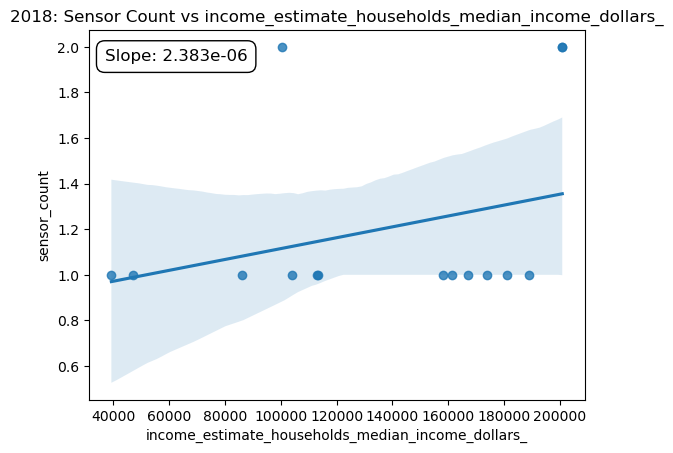

Year: 2019


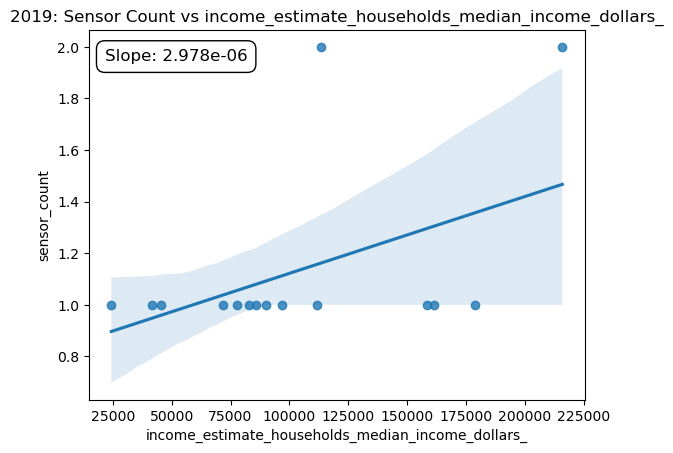

Year: 2020


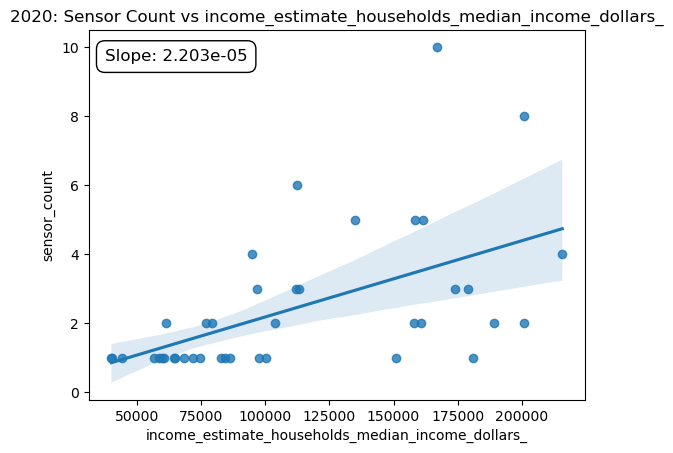

Year: 2021


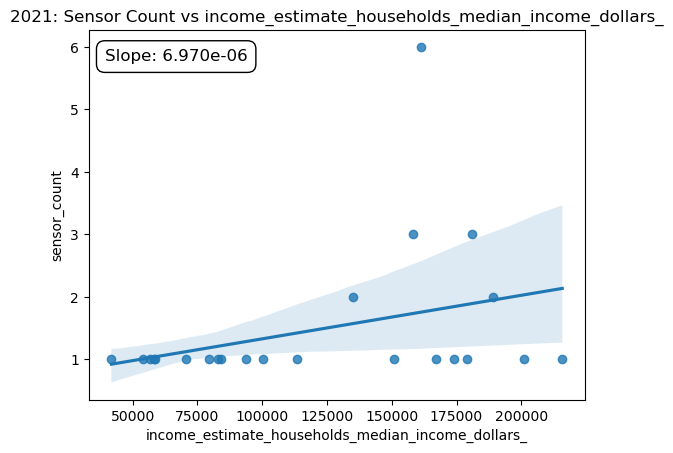

Year: 2022


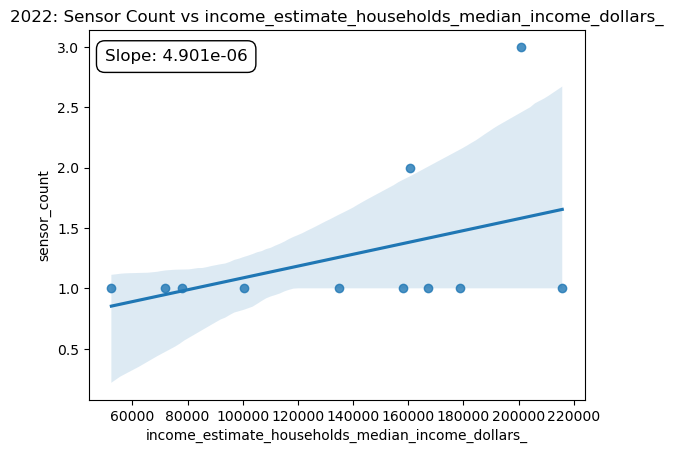

In [413]:
from IPython.display import display, HTML

for year in range(2018, 2023, 1):
    # print(f"Year {year}")
    column_of_interest =  'income_estimate_households_median_income_dollars_'
    my_results_df = get_sensor_counts_per_tract_by_year(con, column_of_interest, year)
    # Limit the columns displayed by selecting specific ones
    display_columns_df = my_results_df[['geographic_area_name', 'sensor_count', column_of_interest]]

    # Sort the rows by a specific column in descending order (e.g., 'column1')
    display_columns_df = display_columns_df.sort_values(by='sensor_count', ascending=False)

    print(f"Year: {year}") 
    # Display the DataFrame as HTML
    display(HTML(display_columns_df.to_html()))
    # print(my_results_df)

    # Create a new figure for each year
    plt.figure()

    # Create scatter plot with regression line
    sns.regplot(x=column_of_interest, y='sensor_count', data=display_columns_df)

    # Optionally, add a title to each plot
    plt.title(f"{year}: Sensor Count vs {column_of_interest}")
    
    # Calculate the slope and intercept of the regression line
    x = display_columns_df[column_of_interest]
    y = display_columns_df['sensor_count']
    slope, intercept = np.polyfit(x, y, 1)

    # Add the slope in a text box on the plot
    plt.text(0.05, 0.95, f"Slope: {slope:.3e}", transform=ax.transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

    # Show the plot for the current year
    plt.show()

## create_interactive_plot

In [450]:
# Function to create an interactive plot with regression line and slope
def create_interactive_plot(df, year, column_of_interest):
    # Create a fresh interactive scatter plot for each year
    fig = go.Figure()

    # Add scatter plot
    fig.add_trace(go.Scatter(x=df[column_of_interest], 
                             y=df['sensor_count'], 
                             mode='markers', 
                             marker=dict(size=10), 
                             hoverinfo='text',
                             text=[f"Census Tract: {tract}<br>Value: {val}<br>Sensor Count: {count}"
                                   for tract, val, count in zip(df['geographic_area_name'], df[column_of_interest], df['sensor_count'])],
                             name=f'Scatter plot for {year}'))

    # Calculate the slope and intercept of the regression line
    x = df[column_of_interest]
    y = df['sensor_count']
    slope, intercept = np.polyfit(x, y, 1)

    # Create the regression line data
    regression_line = slope * x + intercept

    # Add regression line
    fig.add_trace(go.Scatter(x=x, y=regression_line, mode='lines', name=f'Regression Line for {year}'))

    # Add slope annotation
    fig.add_annotation(
        text=f"Slope: {slope:.3e}",
        xref="paper", yref="paper",
        x=0.05, y=0.95, showarrow=False,
        bordercolor="black", borderwidth=1, borderpad=4, bgcolor="white", opacity=0.8
    )

    # Title and layout
    fig.update_layout(title=f"{year}: Sensor Count vs {column_of_interest.replace('_', ' ').title()}",
                      xaxis_title=column_of_interest.replace('_', ' ').title(),
                      yaxis_title="Sensor Count")

    # Generate a "signature" (checksum) of the figure's data using its layout + data
    figure_signature = hashlib.md5(str(fig.to_plotly_json()).encode()).hexdigest()

    # Save the figure to HTML
    html_filename = f"./images/{column_of_interest}sensor_plot_{year}.html"
    fig.write_html(html_filename)  # Save figure to HTML file
    
    # Return the figure, its checksum, and the file name
    return fig, figure_signature, html_filename



## generate_census_plot_images

In [710]:
# Function to generate plotly images, store them as HTML files and render inline
def generate_census_plot_images(column_of_interest, start_year=2018, end_year=2023, con=con):
    # Initialize a list to store figures, checksums, and filenames
    figures = []
    signatures = []
    html_filenames = []
    html_folder = "images"
    # Manually invoke the plot for each year
    for year in range(start_year, end_year):
        
        # Fetch the data for the specific year
        my_results_df = get_sensor_counts_per_tract_by_year(con, column_of_interest, year)
    
        # Ensure the data is unique and limit the columns displayed
        display_columns_df = my_results_df[['geographic_area_name', 'sensor_count', column_of_interest]].copy()
        display_columns_df = display_columns_df.sort_values(by='sensor_count', ascending=False).copy()
    
        # Generate the figure, the checksum, and the HTML filename
        fig, fig_signature, html_filename = create_interactive_plot(display_columns_df, year, column_of_interest)
    
        # Append the figure, signature, and filename to the lists
        figures.append(fig)
        signatures.append(fig_signature)
        html_filenames.append(html_filename)
        
        # Destroy the figure explicitly
        del fig  # Ensure no state lingers
    
    # Iterate over the list of figures and signatures to check uniqueness and display the HTML
    for idx, (sig, html_file) in enumerate(zip(signatures, html_filenames)):
        # print(f"Figure {idx + 1} checksum: {sig}")
        
        # Open the saved HTML files manually to inspect the plots outside Jupyter
        print(f"Opening plot saved in {html_file}")
    
    # Iterate over the saved HTML files and display them inline
    for html_file in html_filenames:
        # Move the HTML files to the 'images' folder (if not already moved)
        new_path = os.path.join(html_folder, os.path.basename(html_file))
        
        # Display the HTML inline using IFrame
        print(f"Displaying {new_path}")
        display(IFrame(src=new_path, width=800, height=600))


In [562]:
generate_census_plot_images('income_estimate_households_median_income_dollars_')

Figure 1 checksum: 91bf308f43f2004bee22da35a899900c
Opening plot saved in ./images/income_estimate_households_median_income_dollars_sensor_plot_2018.html
Figure 2 checksum: d5b87947958bcf93f077ed61428cc4dd
Opening plot saved in ./images/income_estimate_households_median_income_dollars_sensor_plot_2019.html
Figure 3 checksum: c5f02fdea7585302c84d9f0c38200050
Opening plot saved in ./images/income_estimate_households_median_income_dollars_sensor_plot_2020.html
Figure 4 checksum: 8ce4623e1c1199bd87d728525b0f52ba
Opening plot saved in ./images/income_estimate_households_median_income_dollars_sensor_plot_2021.html
Figure 5 checksum: cf9564c84df58b3f5cb303940b944ac9
Opening plot saved in ./images/income_estimate_households_median_income_dollars_sensor_plot_2022.html
Displaying images\income_estimate_households_median_income_dollars_sensor_plot_2018.html


Displaying images\income_estimate_households_median_income_dollars_sensor_plot_2019.html


Displaying images\income_estimate_households_median_income_dollars_sensor_plot_2020.html


Displaying images\income_estimate_households_median_income_dollars_sensor_plot_2021.html


Displaying images\income_estimate_households_median_income_dollars_sensor_plot_2022.html


In [563]:
generate_census_plot_images('income_estimate_households_mean_income_dollars_')

Figure 1 checksum: b477b760e439ea132bcd76a8e118b443
Opening plot saved in ./images/income_estimate_households_mean_income_dollars_sensor_plot_2018.html
Figure 2 checksum: 3e532bf4409e053ea56b25bc418b561c
Opening plot saved in ./images/income_estimate_households_mean_income_dollars_sensor_plot_2019.html
Figure 3 checksum: 19f2b237009a0cea5a51b27f48eeb0bb
Opening plot saved in ./images/income_estimate_households_mean_income_dollars_sensor_plot_2020.html
Figure 4 checksum: 1d7d4ee34dcbace00ae684ef4b0dca24
Opening plot saved in ./images/income_estimate_households_mean_income_dollars_sensor_plot_2021.html
Figure 5 checksum: eb59dad264a705c09bf65901b30f2599
Opening plot saved in ./images/income_estimate_households_mean_income_dollars_sensor_plot_2022.html
Displaying images\income_estimate_households_mean_income_dollars_sensor_plot_2018.html


Displaying images\income_estimate_households_mean_income_dollars_sensor_plot_2019.html


Displaying images\income_estimate_households_mean_income_dollars_sensor_plot_2020.html


Displaying images\income_estimate_households_mean_income_dollars_sensor_plot_2021.html


Displaying images\income_estimate_households_mean_income_dollars_sensor_plot_2022.html


The positive slopes for median and mean income do indicate a positive 
relationship between sensor count and income, the magnitude of the slope may
not be best gauge to determine the strength of any association. We will consult
our database table to see what correlations are to be found.

In [449]:
# print(con.sql("SHOW TABLES"))
print(con.sql("DESCRIBE merged_corr_table"))

┌───────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name  │ column_type │  null   │   key   │ default │  extra  │
│    varchar    │   varchar   │ varchar │ varchar │ varchar │ varchar │
├───────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ census_column │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ correlation   │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ year          │ INTEGER     │ YES     │ NULL    │ NULL    │ NULL    │
└───────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘



In [456]:
# Do a search for correlations of interest
for year in range(2018, 2023):
    cols_to_search = ['income_estimate_households_mean_income_dollars_', 
                      'income_estimate_households_median_income_dollars_']
    print(f"Year: {year}")
    for col in cols_to_search:
        print(con.sql(f"SELECT census_column, correlation FROM merged_corr_table\
                        WHERE year = {year}\
                        AND census_column = '{col}'"))

Year: 2018
┌─────────────────────────────────────────────────┬─────────────────────┐
│                  census_column                  │     correlation     │
│                     varchar                     │       double        │
├─────────────────────────────────────────────────┼─────────────────────┤
│ income_estimate_households_mean_income_dollars_ │ 0.22653321039064844 │
└─────────────────────────────────────────────────┴─────────────────────┘

┌───────────────────────────────────────────────────┬─────────────────────┐
│                   census_column                   │     correlation     │
│                      varchar                      │       double        │
├───────────────────────────────────────────────────┼─────────────────────┤
│ income_estimate_households_median_income_dollars_ │ 0.30721337522797343 │
└───────────────────────────────────────────────────┴─────────────────────┘

Year: 2019
┌─────────────────────────────────────────────────┬───────────────────┐
│   

## Thoughts On Correlation of Income and Sensor Installs

We have moderately positive relationships between income and sensor count. The
strongest correlation appearing in 2020, with both mean and median income 
suggests that during that year, the number sensors installed were more closely
associated with household income. Since median income shows higher correlations
with sensor count that mean income, this may suggest median income may be a 
better predictor for sensor distribution.

# Choropleth Plotting Function

## plot_census_choropleth

In [110]:
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point

def plot_census_choropleth(con, column_of_interest='income_estimate_households_total', year_of_interest=2018):
    
    # Parameterized DuckDB query
    census_table_query = f"""
        SELECT geography, geographic_area_name, {column_of_interest}, year
        FROM merged_census_table
        WHERE year = {year_of_interest}
    """
    
    # Execute the query
    census_query_df = con.query(census_table_query).fetchdf()
    
    # Merge this truncated DataFrame with the geographic data (shapefile)
    merged_data = geo_data.merge(census_query_df, left_on='AFFGEOID', right_on='geography')
   
    # Prepare the sensor data query
    affgeoid_list = list(merged_data['geography'].unique())
    affgeoid_tuple = tuple(affgeoid_list)
    
    sensor_table_query = f"""
        SELECT latitude, longitude, AFFGEOID
        FROM merged_sensor_table
        WHERE year_created <= {year_of_interest}
        AND AFFGEOID IN {affgeoid_tuple}
    """
    
    # Execute the query for sensor data
    filtered_sensor_data_df = con.execute(sensor_table_query).fetchdf()

    # Add sensors as points for interactive plotting
    merged_data['sensor_count'] = merged_data['geography'].map(filtered_sensor_data_df['AFFGEOID'].value_counts().to_dict())

    # Plotly Choropleth map for census data
    fig = px.choropleth(
        merged_data,
        geojson=merged_data.geometry,
        locations=merged_data.index,
        color=column_of_interest,
        hover_name="geographic_area_name",  # Hover information
        hover_data={
            column_of_interest: True,  # Show the column of interest value
            "sensor_count": True,  # Show the sensor count
        },
        title=f"{year_of_interest} Census Tracts and Sensor Locations for {column_of_interest}",
        labels={column_of_interest: column_of_interest.replace('_', ' ').title()},  # Proper labels for the colorbar
    )
    
    # Update map layout to hide axes and add interactivity
    fig.update_geos(fitbounds="locations", visible=False)
    
    # Adding the sensors as red scatter points
    fig.add_trace(go.Scattergeo(
        lon=filtered_sensor_data_df['longitude'],
        lat=filtered_sensor_data_df['latitude'],
        mode='markers',
        marker=dict(color='red', size=6),
        name='Sensors',
        hoverinfo='text',
        hovertext=filtered_sensor_data_df.apply(
            lambda row: f"Latitude: {row['latitude']}<br>Longitude: {row['longitude']}<br>AFFGEOID: {row['AFFGEOID']}",
            axis=1
        )
    ))

    # Show number of sensors as a text annotation
    num_sensors = len(filtered_sensor_data_df)
    fig.add_annotation(
        text=f"Number of Sensors: {num_sensors}",
        xref="paper", yref="paper",
        x=0.115, y=1.0, showarrow=False,
        bordercolor="black", borderwidth=1, borderpad=4, bgcolor="white", opacity=0.9
    )

    fixed_title =  column_of_interest.rstrip("_").replace("_", " ").title()

    fig.update_layout(
        margin=dict(l=0, r=0, b=0),  # Remove margins (left, right, top, bottom)
        width=1300,  # Set the desired width in pixels
        height=800,  # Set the desired height in pixels
        coloraxis_colorbar=dict(
            # title="Income USD",  # Add an optional title
            title = fixed_title,
            titlefont=dict(size=12),  # Adjust the font size for the title
            # thicknessmode="pixels",  # Set the thickness of the colorbar (in pixels)
            # thickness=15,  # Make the colorbar narrower
            lenmode="fraction",  # Use fraction of the map height
            len=0.6,  # Set the length to a fraction of the map height (e.g., 0.3 is 30%)
           #  yanchor="middle",  # Center the legend vertically
            x=0.11,
            y=0.65,
            xanchor="left"
           #  y=0.5,  # Position it at the center of the map
           # ticks="outside"  # Optional: adjust tick marks to be outside the colorbar
        )
    )

    fig.update_layout(
        title=dict(
            # text="Your Map Title",
            font=dict(size=18, family="Arial Black", color="black"),  # Use a bold font family directly
            x=0.5,
            xanchor='center',
            yanchor='top'
        )
    )


    # Display the plot
    # fig.show()
    # Write plot to file
    # Save the figure to HTML
    html_filename = f"./images/{column_of_interest}_choropleth_plot_{year}.html"
    fig.write_html(html_filename)  # Save figure to HTML file
    del fig

## plot_census_choropleth_race

In [192]:
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point

def plot_census_choropleth_race(con, column_of_interest='income_estimate_households_total', year_of_interest=2018):
    if re.match('^race_.*', column_of_interest):
        table_to_query = 'racial_yearly_view'
        geo_name = 'AFFGEOID'
    else:
        table_to_query = 'merged_census_table'
        geo_name = 'geography'
    
    # Parameterized DuckDB query
    census_table_query = f"""
        SELECT {geo_name}, geographic_area_name, {column_of_interest}, year
        FROM {table_to_query}
        WHERE year = {year_of_interest}
    """
    print(f"We are procesing {column_of_interest} in plot_census_choropleth_race")
    # print(f"Census query string{census_table_query}")
    
    # Execute the Census query
    census_query_df = con.query(census_table_query).fetchdf()

    # census_query_df.head()
    # Merge this truncated DataFrame with the geographic data (shapefile)
    # merged_data = geo_data.merge(census_query_df, left_on='AFFGEOID', right_on='geography')

    # Merge this truncated DataFrame with the geographic data (shapefile)
    merged_data = geo_data.merge(census_query_df, left_on='AFFGEOID', right_on=geo_name, how='left')

    # print(f"Merged data Head {merged_data.head(1)}")
    
    # This fills the ENTIRE STATE
    merged_data[column_of_interest].fillna(0, inplace=True)  # Replace NaNs with 0s
    
    # After filling in the entire shape file, we can than filter it based on 
    # contents our merged_census_table
    
    test_unique_geo_query = f"""
        SELECT DISTINCT geography
        FROM merged_census_table
    """
    unique_geo_df = con.query(test_unique_geo_query).fetchdf()
    unique_geo_list = list(unique_geo_df['geography'])

    # Filter the dataframe, keeping only rows where 'your_column' values exist in list_of_items
    merged_data = merged_data[merged_data['AFFGEOID'].isin(unique_geo_list)]

    
    


    
    # Prepare the sensor data query
    affgeoid_list = list(merged_data[geo_name].unique())
    affgeoid_tuple = tuple(affgeoid_list)
    
    sensor_table_query = f"""
        SELECT latitude, longitude, AFFGEOID
        FROM merged_sensor_table
        WHERE year_created <= {year_of_interest}
        AND AFFGEOID IN {affgeoid_tuple}
    """
    
    # Execute the query for sensor data
    filtered_sensor_data_df = con.execute(sensor_table_query).fetchdf()

    # Add sensors as points for interactive plotting
    merged_data['sensor_count'] = merged_data[geo_name].map(filtered_sensor_data_df['AFFGEOID'].value_counts().to_dict())


    # Add conditional hover text based on NaN values in column_of_interest
    merged_data['hover_text'] = merged_data.apply(
        lambda row: (
            f"{row['geographic_area_name']}<br>"
            f"{column_of_interest}: {row[column_of_interest]:.2f}<br>"
            # f"Sensors Per Person: {row['sensor_count']/row[column_of_interest]}<br>"
            # f"Sensor Count: {row['sensor_count']}" if pd.notna(row[column_of_interest])
            f"Sensor Count: {row['sensor_count']}<br>Sensor Density: 1 Sensors / {row[column_of_interest]/row['sensor_count']:.2f} Persons" if pd.notna(row[column_of_interest]) and row['sensor_count'] > 0
            else f"{row['geographic_area_name']}<br>No data for {column_of_interest}"
        ), axis=1
    )



    
    # Plotly Choropleth map for census data
    fig = px.choropleth(
        merged_data,
        geojson=merged_data.geometry,
        locations=merged_data.index,
        color=column_of_interest,
        hover_name="geographic_area_name",  # Hover information
        hover_data = None,
        # hover_data={
        #     column_of_interest: True,  # Show the column of interest value
        #     "sensor_count": True,  # Show the sensor count
        # },
        title=f"{year_of_interest} Census Tracts and Sensor Locations for {column_of_interest}",
        labels={column_of_interest: column_of_interest.replace('_', ' ').title()},  # Proper labels for the colorbar
    )

    # Add conditional hover text
    fig.update_traces(
        hovertemplate=merged_data['hover_text']
    )



    # Update map layout to hide axes and add interactivity
    fig.update_geos(fitbounds="locations", visible=False)
    
    # Adding the sensors as red scatter points
    fig.add_trace(go.Scattergeo(
        lon=filtered_sensor_data_df['longitude'],
        lat=filtered_sensor_data_df['latitude'],
        mode='markers',
        marker=dict(color='red', size=6),
        name='Sensors',
        hoverinfo='text',
        hovertext=filtered_sensor_data_df.apply(
            lambda row: f"Latitude: {row['latitude']}<br>Longitude: {row['longitude']}<br>AFFGEOID: {row['AFFGEOID']}",
            #lambda row: f"Latitude: {row['latitude']}<br>Longitude: {row['longitude']}<br>AFFGEOID: {row['geographic_area_name']}",
            axis=1
        )
    ))

    # Show number of sensors as a text annotation
    num_sensors = len(filtered_sensor_data_df)
    fig.add_annotation(
        text=f"Number of Sensors: {num_sensors}",
        xref="paper", yref="paper",
        x=0.115, y=1.0, showarrow=False,
        bordercolor="black", borderwidth=1, borderpad=4, bgcolor="white", opacity=0.9
    )

    fixed_title =  column_of_interest.rstrip("_").replace("_", " ").title()

    fig.update_layout(
        margin=dict(l=0, r=0, b=0),  # Remove margins (left, right, top, bottom)
        width=1300,  # Set the desired width in pixels
        height=800,  # Set the desired height in pixels
        coloraxis_colorbar=dict(
            # title="Income USD",  # Add an optional title
            title = fixed_title,
            titlefont=dict(size=12),  # Adjust the font size for the title
            # thicknessmode="pixels",  # Set the thickness of the colorbar (in pixels)
            # thickness=15,  # Make the colorbar narrower
            lenmode="fraction",  # Use fraction of the map height
            len=0.6,  # Set the length to a fraction of the map height (e.g., 0.3 is 30%)
           #  yanchor="middle",  # Center the legend vertically
            x=0.11,
            y=0.65,
            xanchor="left"
           #  y=0.5,  # Position it at the center of the map
           # ticks="outside"  # Optional: adjust tick marks to be outside the colorbar
        )
    )

    fig.update_layout(
        title=dict(
            # text="Your Map Title",
            font=dict(size=18, family="Arial Black", color="black"),  # Use a bold font family directly
            x=0.5,
            xanchor='center',
            yanchor='top'
        )
    )


    # Display the plot
    # fig.show()
    # Write plot to file
    # Save the figure to HTML
    html_filename = f"./images/{column_of_interest}_choropleth_plot_race_{year}.html"
    fig.write_html(html_filename)  # Save figure to HTML file
    del fig

In [678]:
# Plot choropleths for median income in all years of interest
html_filenames = []
columns_of_interest = ['income_estimate_households_median_income_dollars_', 'income_estimate_households_mean_income_dollars_']
# generate_census_choropleths(column_of_interest)
for year in range(2018, 2023):
    for col in columns_of_interest:
        print(f"Year:{year}  Column: {col}")
        plot_census_choropleth(con, col, year)
        html_file = f"./images/{col}choropleth_plot_{year}.html"
        html_filenames.append(html_file)

Year:2018  Column: income_estimate_households_median_income_dollars_
Year:2018  Column: income_estimate_households_mean_income_dollars_
Year:2019  Column: income_estimate_households_median_income_dollars_
Year:2019  Column: income_estimate_households_mean_income_dollars_
Year:2020  Column: income_estimate_households_median_income_dollars_
Year:2020  Column: income_estimate_households_mean_income_dollars_
Year:2021  Column: income_estimate_households_median_income_dollars_
Year:2021  Column: income_estimate_households_mean_income_dollars_
Year:2022  Column: income_estimate_households_median_income_dollars_
Year:2022  Column: income_estimate_households_mean_income_dollars_


# Income Choropleth Plots

In [679]:
# We handcrank our display of choropleths with sensors and median/mean income
html_filenames = []
columns_of_interest = ['income_estimate_households_median_income_dollars_', 'income_estimate_households_mean_income_dollars_']

for year in range(2018, 2022):
    for col in columns_of_interest:
            html_file = f"./images/{col}choropleth_plot_{year}.html"
            
            html_filenames.append(html_file)
# Iterate over the saved HTML files and display them inline
for html_file in html_filenames:
    # Move the HTML files to the 'images' folder (if not already moved)
    # new_path = os.path.join(html_folder, os.path.basename(html_file))
    print(f"HTML file: {html_file}")
    # new_path = os.path(html_file)
    # Display the HTML inline using IFrame
    # print(f"Displaying {new_path}")
    display(IFrame(src=html_file, width=1200, height=800))


HTML file: ./images/income_estimate_households_median_income_dollars_choropleth_plot_2018.html


HTML file: ./images/income_estimate_households_mean_income_dollars_choropleth_plot_2018.html


HTML file: ./images/income_estimate_households_median_income_dollars_choropleth_plot_2019.html


HTML file: ./images/income_estimate_households_mean_income_dollars_choropleth_plot_2019.html


HTML file: ./images/income_estimate_households_median_income_dollars_choropleth_plot_2020.html


HTML file: ./images/income_estimate_households_mean_income_dollars_choropleth_plot_2020.html


HTML file: ./images/income_estimate_households_median_income_dollars_choropleth_plot_2021.html


HTML file: ./images/income_estimate_households_mean_income_dollars_choropleth_plot_2021.html


# Educational Attainment

We now investigate if areas with higher educational attainment have higher 
number of air quality sensors. This is particularly exciting since our shallow
look at the correlation table seem to yield numerous columns with higher
correlation with sensor counts. 

In [707]:
# Use our previously created census_column_search function to locate columns of interest.
# We will filter this down to total populations and reduce subsegmentation.
edu_attain_columns = census_column_search('educational_attainment.*bache.*')
edu_attain_columns_list = edu_attain_columns.to_list()
edu_attain_cols_to_search = []
for item in edu_attain_columns_list:
    # Search for columns that have total_population and do not segment by sex.
    if re.match('.*percent.*', item) and not re.match('.*male.*', item):
        print(item)
        # edu_attain_cols_to_search.append(item)

educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_higher
educational_attainment_margin_of_error_percent_moe_population_18_to_24_years_bachelors_degree_or_higher
educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree
educational_attainment_margin_of_error_percent_moe_population_25_years_and_over_bachelors_degree
educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_or_higher
educational_attainment_margin_of_error_percent_moe_population_25_years_and_over_bachelors_degree_or_higher
educational_attainment_estimate_percent_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher
educational_attainment_margin_of_error_percent_moe_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher
educational_attainment_estimate_percent_population_25_years_and_over_population_35_to_44_years_bachelors_degree_or_higher
educational_attainment_margin_of_error_p

In [700]:
# Use our previously created census_column_search function to locate columns of interest.
# We will filter this down to total populations and reduce subsegmentation.
edu_attain_columns = census_column_search('educational_attainment.*bache.*')
edu_attain_columns_list = edu_attain_columns.to_list()
edu_attain_cols_to_search = []
for item in edu_attain_columns_list:
    # Search for columns that have total_population and do not segment by sex.
    if re.match('.*total_population', item) and not re.match('male', item):
        print(item)
        edu_attain_cols_to_search.append(item)

educational_attainment_estimate_total_population_18_to_24_years_bachelors_degree_or_higher
educational_attainment_estimate_total_population_25_years_and_over_bachelors_degree
educational_attainment_estimate_total_population_25_years_and_over_bachelors_degree_or_higher
educational_attainment_estimate_total_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher
educational_attainment_estimate_total_population_25_years_and_over_population_35_to_44_years_bachelors_degree_or_higher
educational_attainment_estimate_total_population_25_years_and_over_population_45_to_64_years_bachelors_degree_or_higher
educational_attainment_estimate_total_population_25_years_and_over_population_65_years_and_over_bachelors_degree_or_higher


In [712]:
# We can reuse our code for mean and median section here and glance at what we
# observe for educational attainment.

edu_attain_cols_to_search = ['educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_higher',
    'educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree']
for col in edu_attain_cols_to_search:
    generate_census_plot_images(col)


Opening plot saved in ./images/educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2018.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2019.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2020.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2021.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2022.html
Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2018.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2019.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2020.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2021.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_highersensor_plot_2022.html


Opening plot saved in ./images/educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2018.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2019.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2020.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2021.html
Opening plot saved in ./images/educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2022.html
Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2018.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2019.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2020.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2021.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degreesensor_plot_2022.html


Let's generate some histograms for this data, as they may make for clearer
view of how educational attainment is spread where sensors are installed. 

In [785]:
# Reuse the `edu_attain_cols_to_search
for col in edu_attain_cols_to_search:
    generate_census_histograms(col)

Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_higher_histogram_2018.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_higher_histogram_2019.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_higher_histogram_2020.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_higher_histogram_2021.html


Displaying images\educational_attainment_estimate_percent_population_18_to_24_years_bachelors_degree_or_higher_histogram_2022.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_histogram_2018.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_histogram_2019.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_histogram_2020.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_histogram_2021.html


Displaying images\educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_histogram_2022.html


In asssessing total populations of people with Bachelor's or higher degrees, we 
observe higher sensor counts in census tracts where the percentage of those 
between the ages 18 and 24 are between 10% to 20% of the population; 
conversely, we observe higher sensor counts in areas where those aged 25 and 
above with Bachelor's or higher degrees are 30% to 40% of the population.

As we did not observe strong correlations based on total population, we consult
our correlation DuckDB table for any other `educational_attainment` tables that
would indicate high correlation related to total percentage of the population.

In [732]:
# Searching our educational_attainment correlations for  
print( con.sql(f"SELECT census_column, correlation, year FROM merged_corr_table\
                        WHERE census_column LIKE 'educational_attainment_estimate_percent_population%bachelors_degree%'\
                        "))

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────┬───────┐
│                                                        census_column                                                         │     correlation     │ year  │
│                                                           varchar                                                            │       double        │ int32 │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────┼───────┤
│ educational_attainment_estimate_percent_population_25_years_and_over_bachelors_degree_or_higher                              │  0.1878179196980846 │  2018 │
│ educational_attainment_estimate_percent_population_25_years_and_over_population_25_to_34_years_bachelors_degree_or_higher    │  0.1611178372142937 │  2018 │
│ educational_attainment_estimate_percent_popu

This is mildly bemusing as we notice, with the exception of 2020, there does 
not appear to be strongly positively regression lines for these two columns. 
Searching our correlations table yields few columns of interest, 
_only_ for the year of 2018. The highest correlation being `0.325` for the
35 to 44 years with a Bachelor's degree or higher.

Let's consult the correlations table again, filtering for Education Attainment
columns of _any_ sort of `educational_attainment` column having high positive
correlation values.

## High Correlation Educational Attainment

In [792]:
# Searching our educational_attainment correlations, ignoring `margin of error` 
edu_attain_with_high_corr = con.execute(f"SELECT census_column, correlation, year FROM merged_corr_table\
                        WHERE census_column LIKE 'educational_attainment%'\
                        AND correlation > 0.75\
                        AND census_column NOT LIKE '%margin%'\
                        ").fetch_df()
edu_attain_with_high_corr

census_column   
0               educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_bachelors_degree_or_higher  \
1  educational_attainment_estimate_male_median_earnings_in_the_past_12_months_in_2020_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_high_school_graduate_includes_equivalency_   
2                                                   educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone   
3                    educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_high_school_graduate_or_higher   
4                                                    educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone   
5                     educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_high_school_graduate_or_higher   
6                         educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_bachelors_degree_or_higher   
7         educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_some_college_or_associates_degree   

   correlation  year  
0     0.871231  2019  
1     0.819606  2020  
2     0.753249  2021  
3     0.753679  2021  
4     0.815377  2021  
5     0.815377  2021  
6     0.750617  2021  
7     0.849698  2022

In [801]:
# Find the rows with high correlation via a query and then sort descending order
high_edu_attain_cols = edu_attain_with_high_corr.query('correlation > 0.80').sort_values(by='correlation', ascending=False)
edu_attain_with_high_corr.query('correlation > 0.80').sort_values(by='correlation', ascending=False)

census_column   
0               educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_bachelors_degree_or_higher  \
7         educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_some_college_or_associates_degree   
1  educational_attainment_estimate_male_median_earnings_in_the_past_12_months_in_2020_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_high_school_graduate_includes_equivalency_   
4                                                    educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone   
5                     educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_high_school_graduate_or_higher   

   correlation  year  
0     0.871231  2019  
7     0.849698  2022  
1     0.819606  2020  
4     0.815377  2021  
5     0.815377  2021

As all the above columns relate to Educational Attainment, with attainment 
levels reflected in earnings or in higher degrees obtained. Educational 
attainment may also reflect and impact the awareness of people residing in
these census tracts of environmental issues and health risks associated with
air quality. This also speaks to the ability to know how to install air 
sensors, the ability to access and understand air sensor data, and the
willingness (and ability) to purchase and invest in the technology.

Earnings levels reflect the financial capacity to invest in air quality 
monitoring. The repeated pattern of Native Hawaiian and Pacific Islander 
populations' presence in the census columns is intriguing. This may indicate 
a confluence of regional, educational, and cultural trends that may be present.
We lack any form of sales data that would include demographic information 
related to those involved in purchasing decisions related to PurpleAir sensors.

# Race

## Locate Race Category Columns

In [ ]:
census_column_search("race_estimate_total.*")

We will now analyze whether there are differences in sensor coverage based on the racial demographics of a census tract. Are certain racial groups more likely to live in areas with more or fewer sensors?


In [925]:
census_column_search("race_estimate.*")

Index(['race_estimate_total', 'race_estimate_total_white_alone',
       'race_estimate_total_black_or_african_american_alone',
       'race_estimate_total_american_indian_and_alaska_native_alone',
       'race_estimate_total_asian_alone',
       'race_estimate_total_native_hawaiian_and_other_pacific_islander_alone',
       'race_estimate_total_some_other_race_alone',
       'race_estimate_total_two_or_more_races',
       'race_estimate_total_two_or_more_races_two_races_including_some_other_race',
       'race_estimate_total_two_or_more_races_two_races_excluding_some_other_race_and_three_or_more_races',
       'race_estimate_total_', 'race_estimate_total__white_alone',
       'race_estimate_total__black_or_african_american_alone',
       'race_estimate_total__american_indian_and_alaska_native_alone',
       'race_estimate_total__asian_alone',
       'race_estimate_total__native_hawaiian_and_other_pacific_islander_alone',
       'race_estimate_total__some_other_race_alone',
       'race_

In [926]:
census_column_search("race_estimate_total.*")

Index(['race_estimate_total', 'race_estimate_total_white_alone',
       'race_estimate_total_black_or_african_american_alone',
       'race_estimate_total_american_indian_and_alaska_native_alone',
       'race_estimate_total_asian_alone',
       'race_estimate_total_native_hawaiian_and_other_pacific_islander_alone',
       'race_estimate_total_some_other_race_alone',
       'race_estimate_total_two_or_more_races',
       'race_estimate_total_two_or_more_races_two_races_including_some_other_race',
       'race_estimate_total_two_or_more_races_two_races_excluding_some_other_race_and_three_or_more_races',
       'race_estimate_total_', 'race_estimate_total__white_alone',
       'race_estimate_total__black_or_african_american_alone',
       'race_estimate_total__american_indian_and_alaska_native_alone',
       'race_estimate_total__asian_alone',
       'race_estimate_total__native_hawaiian_and_other_pacific_islander_alone',
       'race_estimate_total__some_other_race_alone',
       'race_

In [1236]:
con.sql("""SELECT geography, geographic_area_name, race_estimate_total_white_alone, year
        FROM merged_census_table
        WHERE race_estimate_total_white_alone IS NOT NULL
        ORDER BY year DESC
        """)

┌──────────────────────┬───────────────────────────────────────────────┬─────────────────────────────────┬───────┐
│      geography       │             geographic_area_name              │ race_estimate_total_white_alone │ year  │
│       varchar        │                    varchar                    │             double              │ int64 │
├──────────────────────┼───────────────────────────────────────────────┼─────────────────────────────────┼───────┤
│ 1400000US06001400100 │ Census Tract 4001, Alameda County, California │                          2122.0 │  2018 │
│ 1400000US06001400200 │ Census Tract 4002, Alameda County, California │                          1551.0 │  2018 │
│ 1400000US06001400300 │ Census Tract 4003, Alameda County, California │                          3757.0 │  2018 │
│ 1400000US06001400400 │ Census Tract 4004, Alameda County, California │                          2703.0 │  2018 │
│ 1400000US06001400500 │ Census Tract 4005, Alameda County, California │        

In [929]:
print(con.sql("SELECT geographic_area_name, race_estimate_total, race_estimate_total_white_alone,\
               race_estimate_total_black_or_african_american_alone,\
               from merged_census_table WHERE year = 2018 LIMIT 1"))

┌───────────────────────────────────────────────┬─────────────────────┬─────────────────────────────────┬─────────────────────────────────────────────────────┐
│             geographic_area_name              │ race_estimate_total │ race_estimate_total_white_alone │ race_estimate_total_black_or_african_american_alone │
│                    varchar                    │       double        │             double              │                       double                        │
├───────────────────────────────────────────────┼─────────────────────┼─────────────────────────────────┼─────────────────────────────────────────────────────┤
│ Census Tract 4001, Alameda County, California │              3115.0 │                          2122.0 │                                               128.0 │
└───────────────────────────────────────────────┴─────────────────────┴─────────────────────────────────┴─────────────────────────────────────────────────────┘



## Obtain Yearly Racial Category Data

In [121]:
race_columns_of_interest = [
                               'race_estimate_total', 'race_estimate_total_white_alone',
                               'race_estimate_total_black_or_african_american_alone',
                               'race_estimate_total_american_indian_and_alaska_native_alone',
                               'race_estimate_total_asian_alone',
                               'race_estimate_total_native_hawaiian_and_other_pacific_islander_alone',
                               'race_estimate_total_some_other_race_alone',
                               'race_estimate_total_two_or_more_races'
                            ]

# Create a dict to store the dataframes with the yearly info wrt race data
# Use the year as the key and df as the value

racial_df_dict = {}

for year in range(2018, 2023):
    yearly_df = pd.DataFrame()
    # print("type of yearly_df")
    # print(type(yearly_df))
    for col in race_columns_of_interest:
        my_results_df = get_sensor_counts_per_tract_by_year(con, col, year)
        # If we are starting, set our yearly_df to the first results
        if yearly_df.empty:
            yearly_df = my_results_df
        else:
            yearly_df = pd.merge(yearly_df, my_results_df,
                                             on=["AFFGEOID", "geographic_area_name", "sensor_count"],
                                             how='outer'
                                )
    racial_df_dict[year] = yearly_df       
    #print(f"Yearly df: {yearly_df}")
    display(HTML(f"<b>YEAR: {year}"))
    display(HTML(yearly_df.to_html()))
    # print(my_results_df)
    
    # break


In [122]:
# We will look at the first item in our results and confirm the cumulative numbers are correct.
first_tract = yearly_df.iloc[0]
print(first_tract)

AFFGEOID                                                                                         1400000US06001404300
sensor_count                                                                                                        1
geographic_area_name                                                    Census Tract 4043, Alameda County, California
race_estimate_total                                                                                            3437.0
race_estimate_total_white_alone                                                                                2280.0
race_estimate_total_black_or_african_american_alone                                                              95.0
race_estimate_total_american_indian_and_alaska_native_alone                                                       0.0
race_estimate_total_asian_alone                                                                                 462.0
race_estimate_total_native_hawaiian_and_other_pacific_is

## Create Yearly Pairplots

In [1050]:
# Create function to generate pairplots to visualize relationships between 
# multiple racial demographics and sensor counts.

def generate_pairplot(input_df, year):
    test_columns_of_interest = [
        'sensor_count',
        'race_estimate_total',
        'race_estimate_total_white_alone',
        'race_estimate_total_black_or_african_american_alone',
        'race_estimate_total_asian_alone',
        'race_estimate_total_two_or_more_races'
    ]
    
    # Create a dictionary to map the long column names to shorter pseudonyms
    column_pseudonyms = {
        'sensor_count': 'Sensor Count',
        'race_estimate_total': 'Total Population',
        'race_estimate_total_white_alone': 'White Alone',
        'race_estimate_total_black_or_african_american_alone': 'Black Alone',
        'race_estimate_total_american_indian_and_alaska_native_alone': 'Native Alone',
        'race_estimate_total_asian_alone': 'Asian Alone',
        'race_estimate_total_native_hawaiian_and_other_pacific_islander_alone': 'Pacific Islander Alone',
        'race_estimate_total_some_other_race_alone': 'Other Race Alone',
        'race_estimate_total_two_or_more_races': 'Two or More Races'
    }
    
    # Renamed columns of interest
    full_renamed_columns_of_interest = [
        'Sensor Count',
        'Total Population',
        'White Alone',
        'Black Alone',
        'Asian Alone',
        'Native Alone', 
        'Pacific Islander Alone', 
        'Other Race Alone',  
        'Two or More Races' 
    ]
    
    renamed_columns_of_interest = [
        'Sensor Count',
        'Total Population',
        'White Alone',
        'Black Alone',
        'Asian Alone'
    ]
    
    # Rename the columns in the dataframe using the pseudonyms
    df_renamed = input_df.rename(columns=column_pseudonyms)
    
    # print(df_renamed.columns)
    
    # Create a custom color palette for the different racial categories
    # Not in use yet.
    custom_palette = {
        'White Alone': 'lightblue',
        'Black Alone': 'orange',
        'Asian Alone': 'green',
        'Two or More Races': 'purple',
        'Pacific Islander Alone': 'darkgreen',
        'Native Alone': 'darkorange', 
        'Other Race Alone': 'grey',
        'Dominant Race': 'red'
    }
    
    # sns.pairplot(df_renamed[full_renamed_columns_of_interest], hue='Pacific Islander Alone', height=1.5, aspect=1)
    g = sns.pairplot(df_renamed[full_renamed_columns_of_interest], height=2.0, aspect=1)
    g.fig.suptitle(f"{year} Sensor Count and Race Pairplot", fontsize=16, y=.95)  # Adjust 'y' to position the title

    
    # Add extra labels at the top
    for i, ax in enumerate(g.axes[-1, :]):  # Iterate over the bottom row of axes
        col_name = full_renamed_columns_of_interest[i]
        ax.annotate(col_name, xy=(0.5, 9.90), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    plt.subplots_adjust(top=0.9)  # Adjust 'top' for more padding (default is 0.88)

    # # Add extra labels at the bottom if needed
    # for i, ax in enumerate(g.axes[0, :]):  # Iterate over the top row of axes
    #     col_name = full_renamed_columns_of_interest[i]
    #     ax.annotate(col_name, xy=(0.5, -0.25), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    #plt.title(f"{year} Racial Pairplot", fontsize=16)
    
    plt.show()

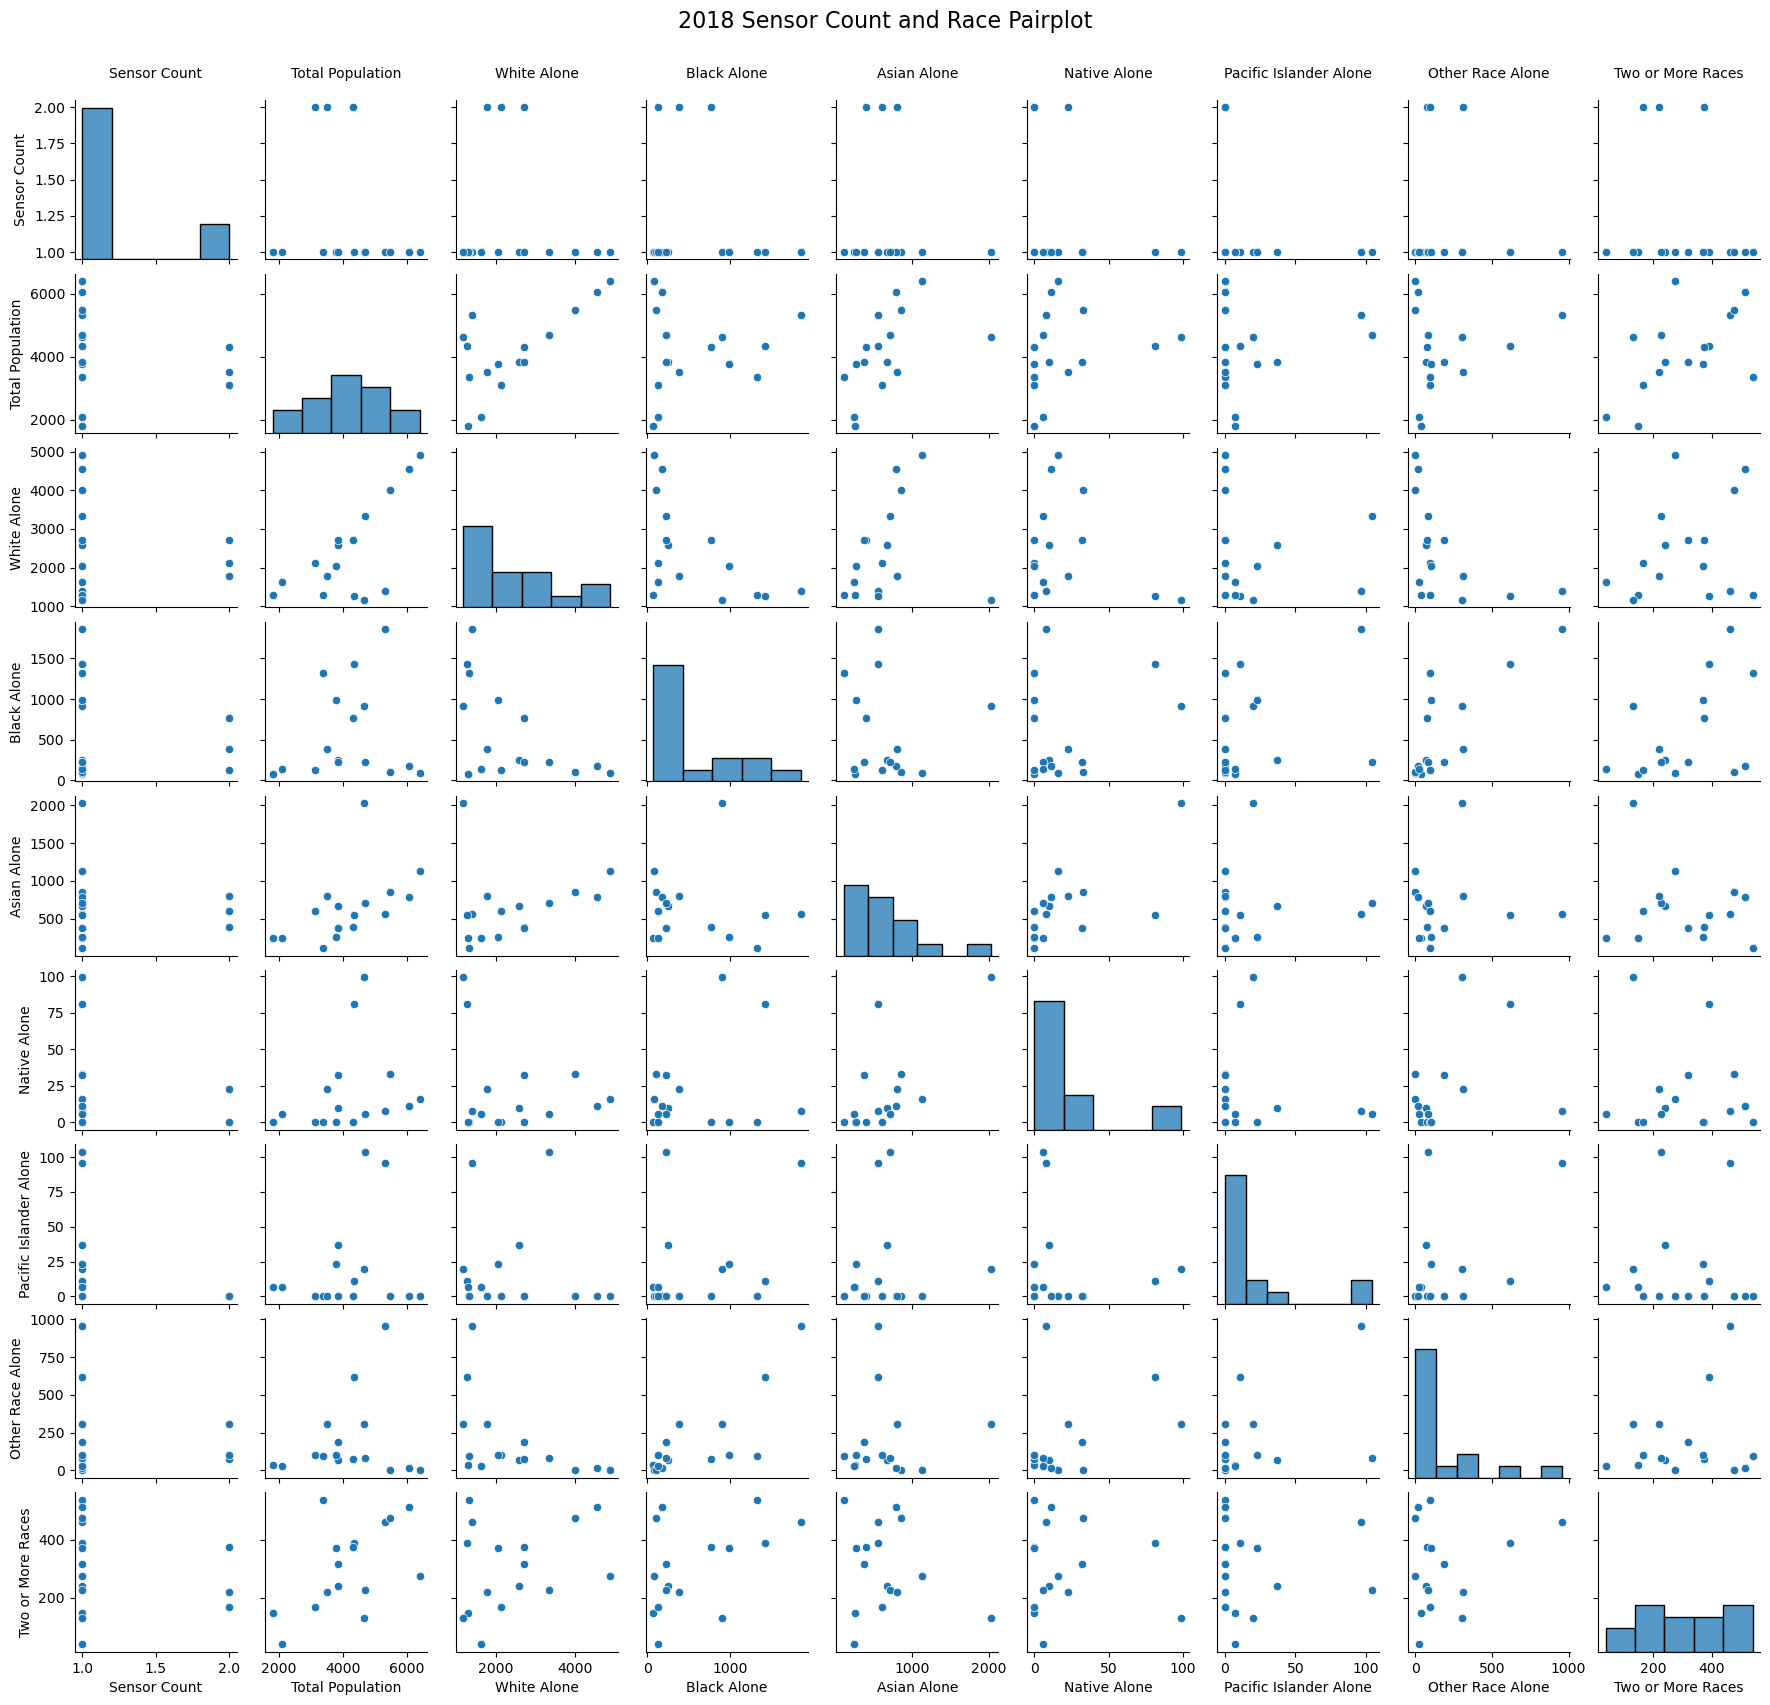

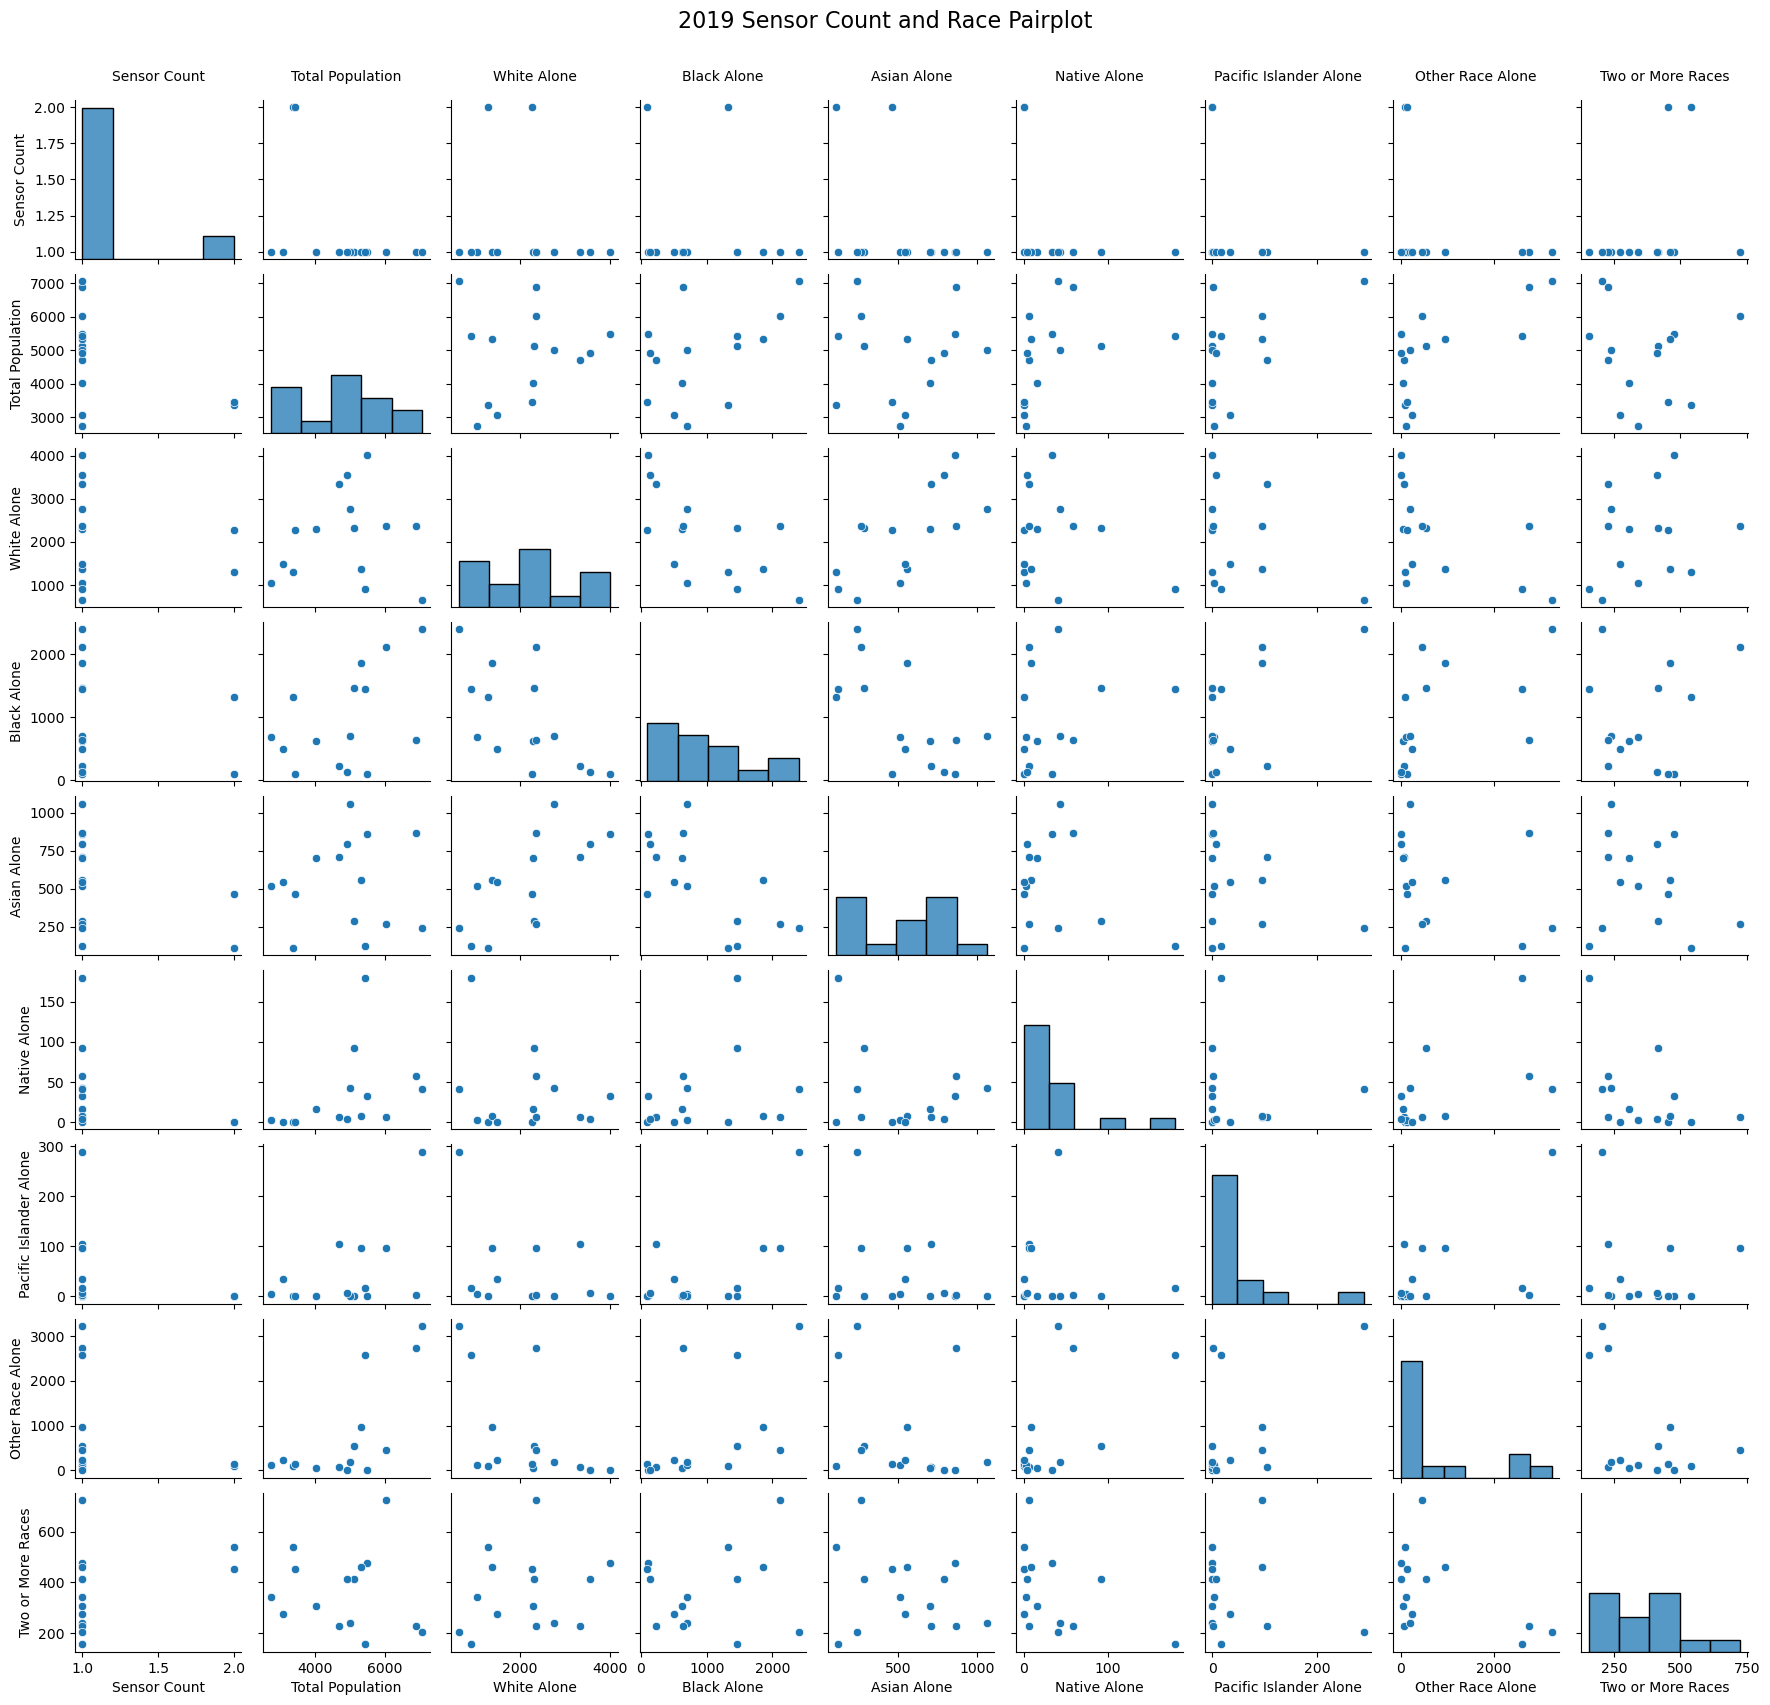

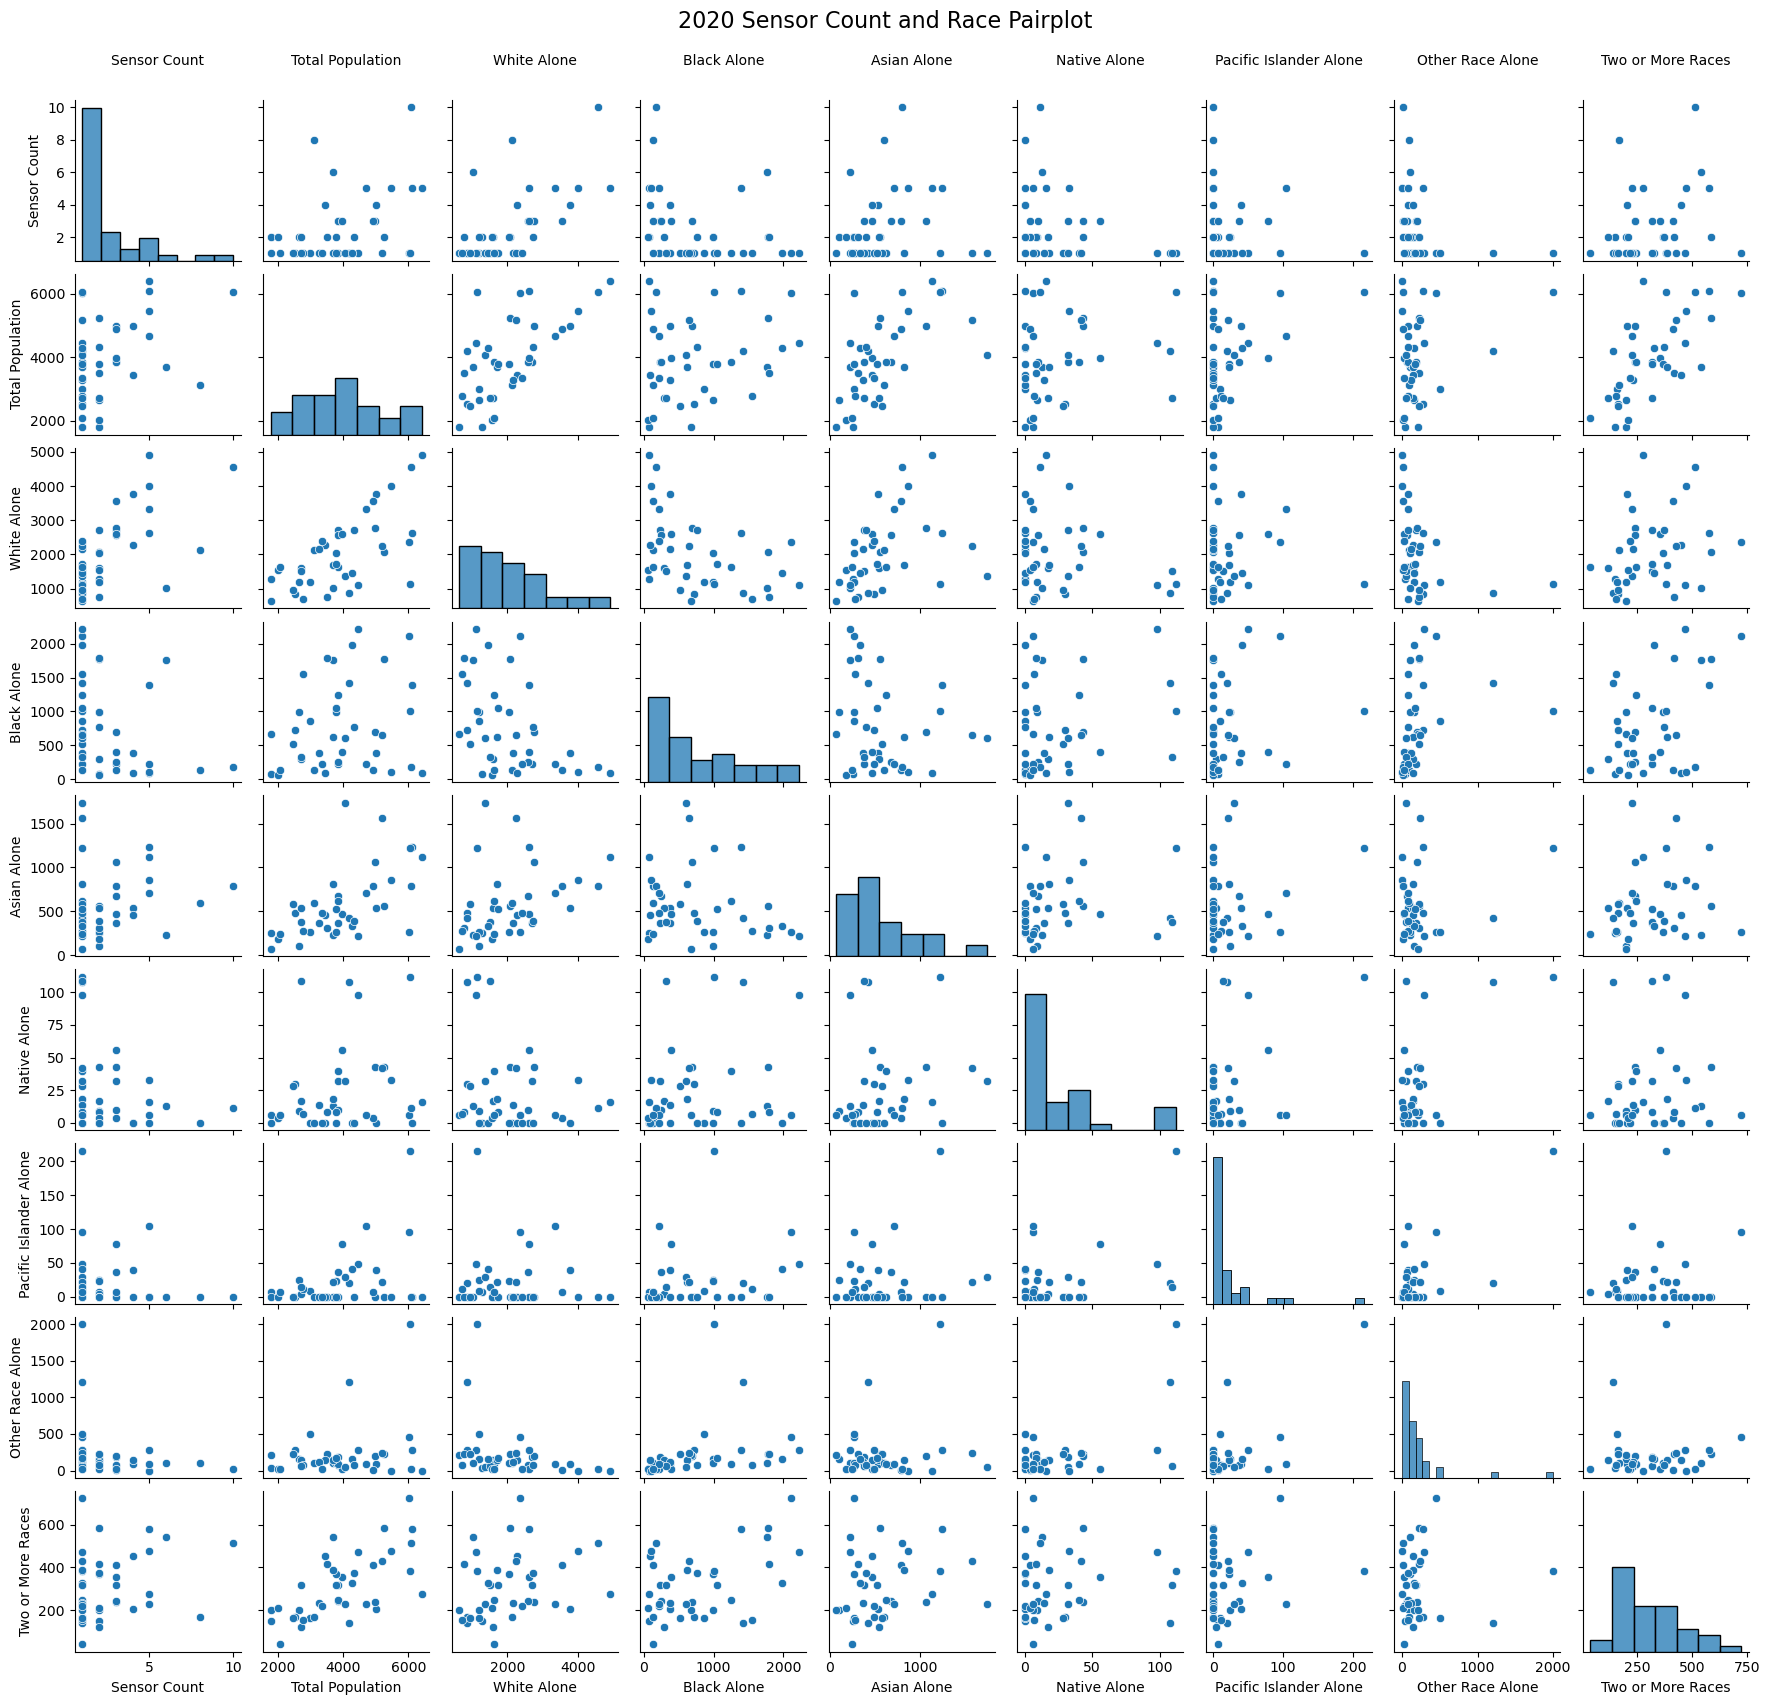

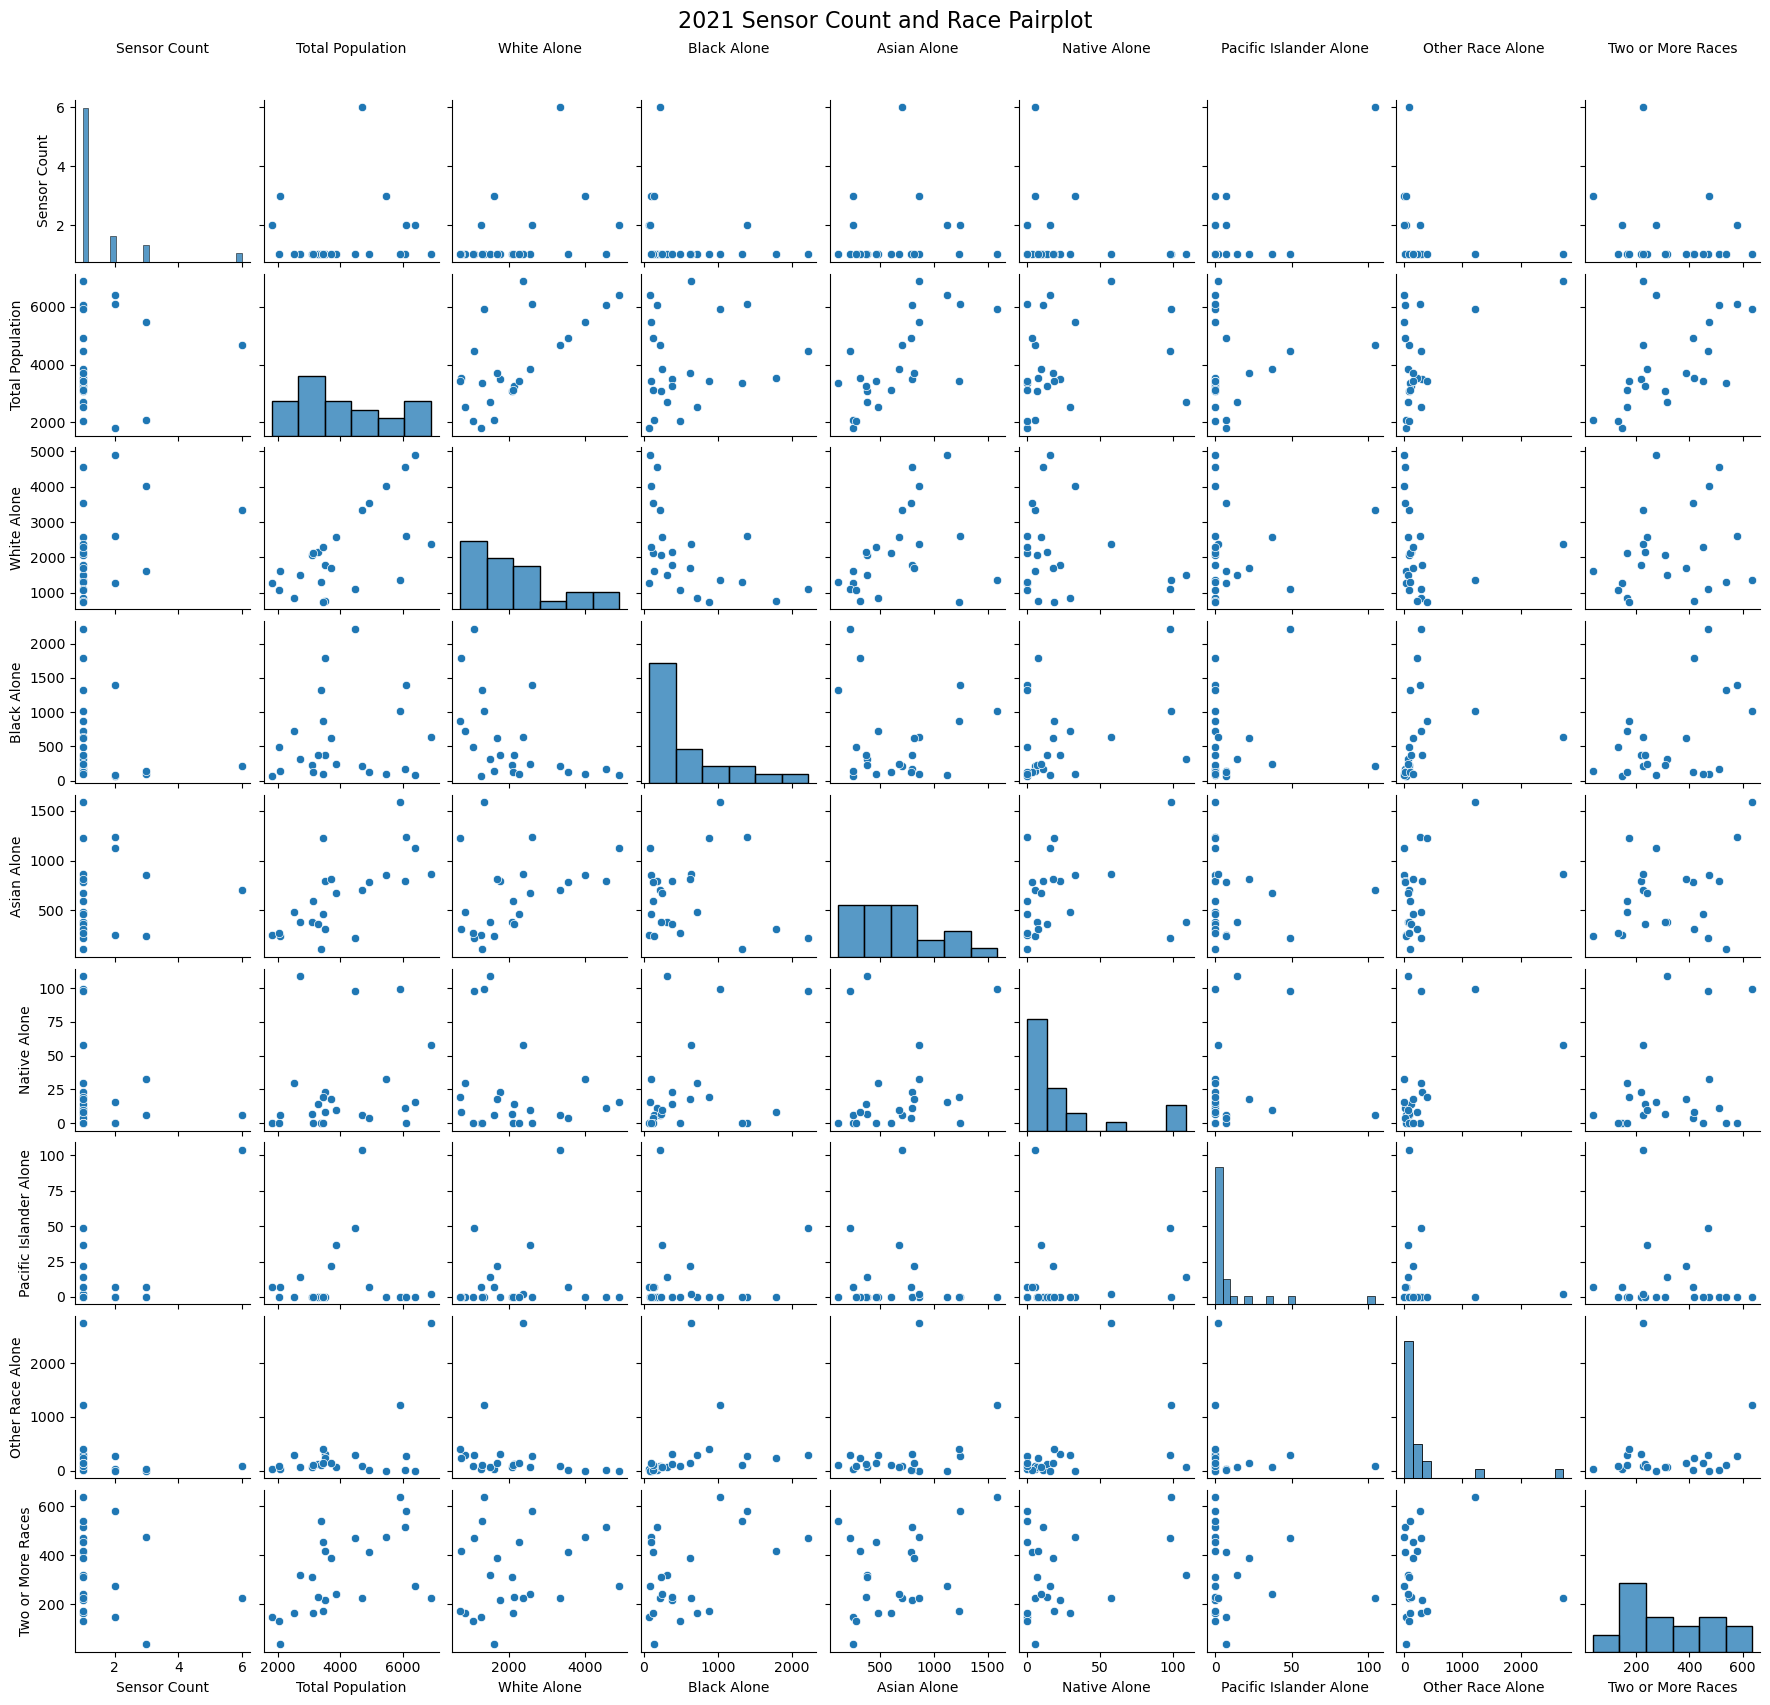

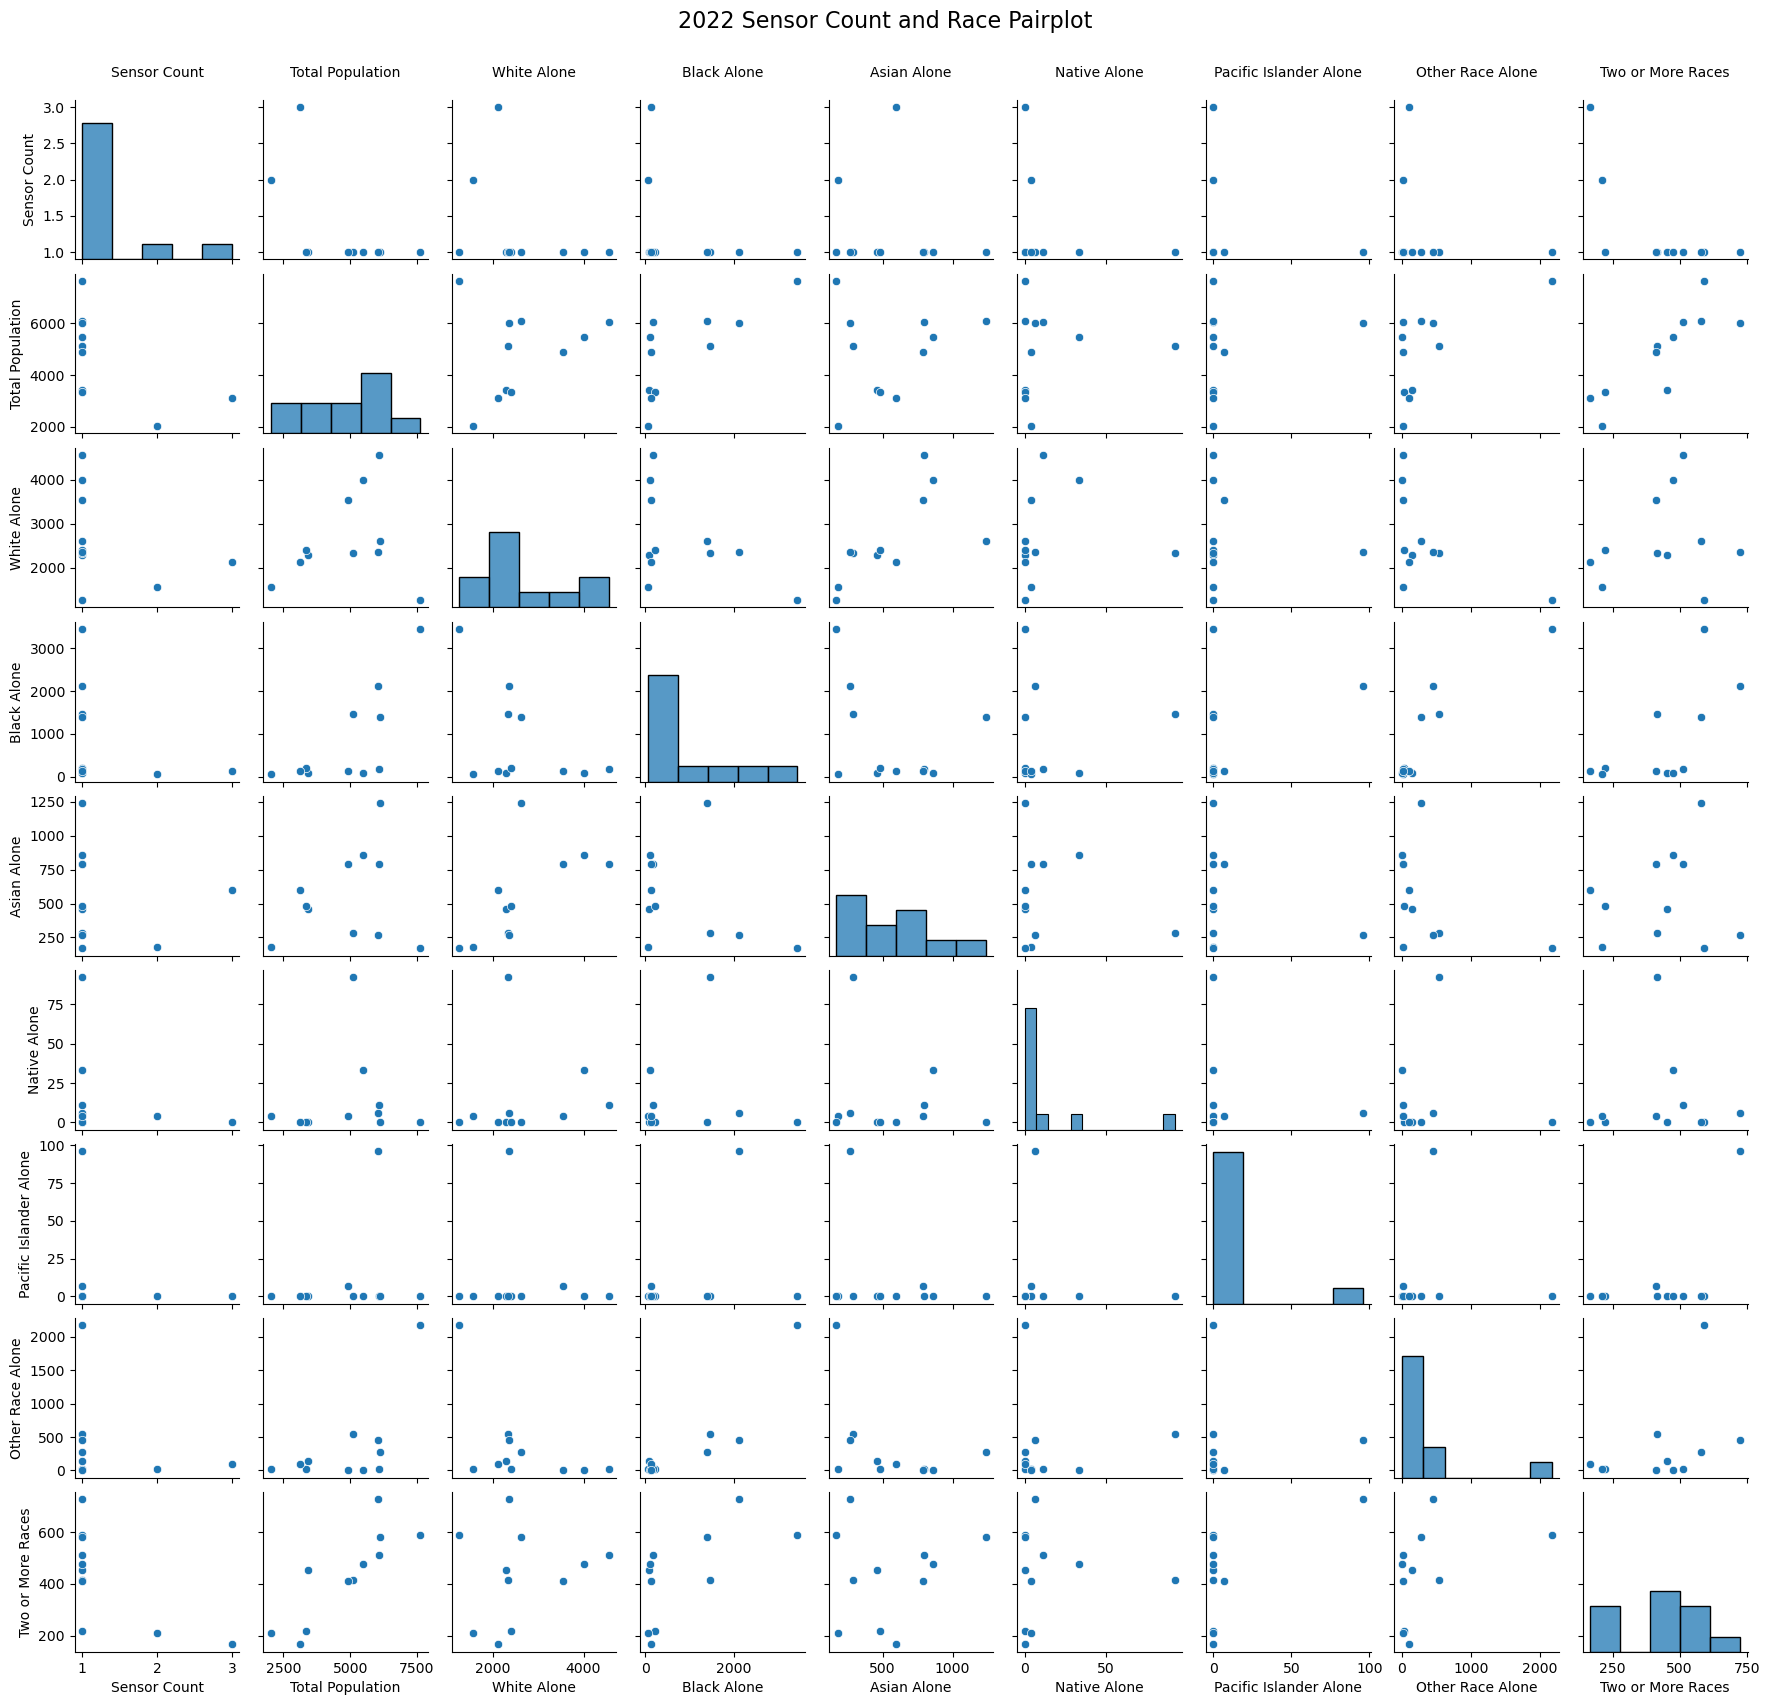

In [1052]:
# We will generate pairplots for each year
for year in range(2018, 2023):
    generate_pairplot(racial_df_dict[year], year)

Broadly speaking, prior to and after 2020 , the sensor counts are not 
correlated strongly with total population of census tracts. The same can be 
said for correlations with particular racial categorizations; we do observe
that there appears to be more equitable distribution of sensors it tracts 
related to "White Alone" and "Two or More Races" populations sizes within 
tracts. The fact the sensor counts do not scale with population size indicates
population size does not determine where sensors are placed. Also, if sensor
count does not scale with population, this indicates generalized low-density
coverage.

The year of **2020**, and the spike in sensor installations yields more interesting
aspects to explore regarding the pairplots relating to sensor counts: 
* **White Alone**: The large number of single sensor installs suggest the tracts are receiving basic coverage. The general upward of sensor counts and higher White Alone populations suggest might be associated with higher sensor counts, but seems far from clear. White Alone appears positively correlated with Asian Alone and Two or More Races categories.
* **Black Alone**: The population size in these tracts do not consistently predict sensor distribution. With numerous tracts having low sensor counts regardless of Black Alone population size would indicate factors other the size of this population is driving sensor installation. The "spire" of tracts that resides near the y-axis indicates some tracts with low Black Alone populations are receiving disproportionate coverage.
* **Asian Alone**: Mirrors White Alone generally, but with less tracts with higher Asian Alone populations corresponding to higher sensor counts. Also appears to be positively correlated to sensor counts.
* **Native Alone and Pacific Island Alone**: Both of these plots indicate that these populations are small in number or have low representation in tracts where sensors are installed.  The amount of tracts with sensor coverage appears uniform regardless of the size of these two populations.
* **Two or More Races**: Shows moderate positive correlation, especially in the 250 to 500 population range. The Two or More Races categorization appears positively correlated Total Population and White Alone populations. There may be correlation with Asian Alone and Black Alone categories, but the spread of census tracts may not be simple to glean directly.

After **2020**, sensor install counts contract to levels nearing **2019** volume, and in **2022**, reduce senor installs reduce significantly. Clustering of tracts near the vertices of the scatter plots indicate low volumes of sensor installation happening in tracts with lower population areas.

## Create DuckDB View for Racial Data

In [126]:
# To create a DuckDB view, we will make each row be associated with its 
# associated year, then merge the dataframes vertically.

year_filled_racial_df = pd.DataFrame()
for year in range(2018, 2023):
    test_df = pd.DataFrame(racial_df_dict[year])
    test_df['year'] = year
    if year_filled_racial_df.empty: 
        year_filled_racial_df = test_df
    else:
        # Merge the dataframes via stacking one atop the original
        year_filled_racial_df = pd.concat([year_filled_racial_df, test_df], axis=0, ignore_index=True, sort=False)


In [127]:
# Validate the shape and form of the data
year_filled_racial_df.shape

year_filled_racial_df.head()

AFFGEOID  sensor_count   
0  1400000US06001408300             1  \
1  1400000US06001404501             1   
2  1400000US06001400400             1   
3  1400000US06001401400             1   
4  1400000US06001404200             1   

                               geographic_area_name  race_estimate_total   
0     Census Tract 4083, Alameda County, California               5323.0  \
1  Census Tract 4045.01, Alameda County, California               1795.0   
2     Census Tract 4004, Alameda County, California               3843.0   
3     Census Tract 4014, Alameda County, California               4331.0   
4     Census Tract 4042, Alameda County, California               3849.0   

   race_estimate_total_white_alone   
0                           1382.0  \
1                           1278.0   
2                           2703.0   
3                           1259.0   
4                           2573.0   

   race_estimate_total_black_or_african_american_alone   
0                                               1858.0  \
1                                                 73.0   
2                                                229.0   
3                                               1425.0   
4                                                244.0   

   race_estimate_total_american_indian_and_alaska_native_alone   
0                                                          8.0  \
1                                                          0.0   
2                                                         32.0   
3                                                         81.0   
4                                                         10.0   

   race_estimate_total_asian_alone   
0                            559.0  \
1                            251.0   
2                            373.0   
3                            549.0   
4                            673.0   

   race_estimate_total_native_hawaiian_and_other_pacific_islander_alone   
0                                                                  96.0  \
1                                                                   7.0   
2                                                                   0.0   
3                                                                  11.0   
4                                                                  37.0   

   race_estimate_total_some_other_race_alone   
0                                      959.0  \
1                                       38.0   
2                                      188.0   
3                                      616.0   
4                                       71.0   

   race_estimate_total_two_or_more_races  year  
0                                  461.0  2018  
1                                  148.0  2018  
2                                  318.0  2018  
3                                  390.0  2018  
4                                  241.0  2018

In [ ]:
# Re-use the data structure storing information on yearly sensor install and 
# demographic data. Create a view in DuckDB.
con.execute("CREATE VIEW racial_yearly_view AS SELECT * FROM year_filled_racial_df")

In [129]:
# You can check if the table was successfully created by querying it
result = con.execute("SELECT * FROM racial_yearly_view LIMIT 5").fetch_df()
# Print the result to verify the table creation
print(result)

               AFFGEOID  sensor_count   
0  1400000US06001408300             1  \
1  1400000US06001404501             1   
2  1400000US06001400400             1   
3  1400000US06001401400             1   
4  1400000US06001404200             1   

                               geographic_area_name  race_estimate_total   
0     Census Tract 4083, Alameda County, California               5323.0  \
1  Census Tract 4045.01, Alameda County, California               1795.0   
2     Census Tract 4004, Alameda County, California               3843.0   
3     Census Tract 4014, Alameda County, California               4331.0   
4     Census Tract 4042, Alameda County, California               3849.0   

   race_estimate_total_white_alone   
0                           1382.0  \
1                           1278.0   
2                           2703.0   
3                           1259.0   
4                           2573.0   

   race_estimate_total_black_or_african_american_alone   
0        

In [130]:
# We should now be able to sum up what census tracts had the most sensor 
# installed via SQL.
result = con.execute("SELECT DISTINCT AFFGEOID, geographic_area_name, SUM(sensor_count)\
         FROM racial_yearly_view\
         GROUP BY geographic_area_name, AFFGEOID\
         ORDER BY ANY_VALUE(sensor_count) DESC").fetch_df()
print(result)

                AFFGEOID                              geographic_area_name   
0   1400000US06001409900     Census Tract 4099, Alameda County, California  \
1   1400000US06001408100     Census Tract 4081, Alameda County, California   
2   1400000US06001400300     Census Tract 4003, Alameda County, California   
3   1400000US06001404900     Census Tract 4049, Alameda County, California   
4   1400000US06001404300     Census Tract 4043, Alameda County, California   
5   1400000US06001400100     Census Tract 4001, Alameda County, California   
6   1400000US06001403600     Census Tract 4036, Alameda County, California   
7   1400000US06001408000     Census Tract 4080, Alameda County, California   
8   1400000US06001400200     Census Tract 4002, Alameda County, California   
9   1400000US06001405100     Census Tract 4051, Alameda County, California   
10  1400000US06001409800     Census Tract 4098, Alameda County, California   
11  1400000US06001401500     Census Tract 4015, Alameda County, 

## Generate Yearly Racial Choropleths

In [1333]:
my_race_column = 'race_estimate_total'
my_income_column = 'income_estimate_households_mean_income_dollars_'

my_race_columns_of_interest = [
                               'race_estimate_total', 'race_estimate_total_white_alone',
                               'race_estimate_total_black_or_african_american_alone',
                               'race_estimate_total_american_indian_and_alaska_native_alone',
                               'race_estimate_total_asian_alone',
                               'race_estimate_total_native_hawaiian_and_other_pacific_islander_alone',
                               'race_estimate_total_some_other_race_alone',
                               'race_estimate_total_two_or_more_races'
                            ]

truncated_cols_of_interest = [
                               'race_estimate_total_white_alone',
                               'race_estimate_total_black_or_african_american_alone',
                               'race_estimate_total_american_indian_and_alaska_native_alone',
                               'race_estimate_total_asian_alone',
                               'race_estimate_total_native_hawaiian_and_other_pacific_islander_alone',
                               'race_estimate_total_some_other_race_alone',
                               'race_estimate_total_two_or_more_races'
                            ]
# Race
for year in range(2018,2023):
    for col in truncated_cols_of_interest:
        plot_census_choropleth_race(con, col, year)
        display(IFrame(src=f'./images/{col}_choropleth_plot_race_{year}.html', width=1200, height=800))


In [194]:
# Race
my_col = 'race_estimate_total'
for year in range(2018,2023):
    plot_census_choropleth_race(con, 'race_estimate_total', year)
    display(IFrame(src=f'./images/{my_col}_choropleth_plot_race_{year}.html', width=1200, height=800))

We are procesing race_estimate_total in plot_census_choropleth_race


We are procesing race_estimate_total in plot_census_choropleth_race


We are procesing race_estimate_total in plot_census_choropleth_race


We are procesing race_estimate_total in plot_census_choropleth_race


We are procesing race_estimate_total in plot_census_choropleth_race


## Calculate Racial Percentages per Tract

We need to demographically describe the areas that have high sensor counts.

In [159]:
my_2018_race_df = con.sql("""SELECT geography, geographic_area_name AS census_tract, 
                    race_estimate_total AS Total,
                    race_estimate_total_white_alone AS White,
                    race_estimate_total_black_or_african_american_alone AS Black,
                    race_estimate_total_american_indian_and_alaska_native_alone AS American_Indian_and_Alaskan,
                    race_estimate_total_asian_alone AS Asian,
                    race_estimate_total_native_hawaiian_and_other_pacific_islander_alone AS Pacific_Islander_or_Hawaiian,
                    race_estimate_total_two_or_more_races AS Two_Or_More_Races, 
                    race_estimate_total_some_other_race_alone AS Other,
                    FROM merged_census_table
                    WHERE race_estimate_total > 0 
                    AND year = 2018
                    -- AND gan LIKE '%4043%'
                    ORDER BY Census_Tract DESC
            """).fetchdf()
# my_result.head()
len(my_2018_race_df)
my_2018_race_df
# len(my_2018_race_df['gan'].unique())

geography                                   census_tract   
0        1600000US0656938                      Piedmont city, California  \
1        1600000US0653000                       Oakland city, California   
2    1400000US06001983200  Census Tract 9832, Alameda County, California   
3    1400000US06001982000  Census Tract 9820, Alameda County, California   
4    1400000US06001981900  Census Tract 9819, Alameda County, California   
..                    ...                                            ...   
109  1400000US06001400500  Census Tract 4005, Alameda County, California   
110  1400000US06001400400  Census Tract 4004, Alameda County, California   
111  1400000US06001400300  Census Tract 4003, Alameda County, California   
112  1400000US06001400200  Census Tract 4002, Alameda County, California   
113  1400000US06001400100  Census Tract 4001, Alameda County, California   

        Total     White    Black  American_Indian_and_Alaskan    Asian   
0     11308.0    8455.0    213.0                         20.0   1915.0  \
1    421042.0  152168.0  99416.0                       3834.0  66182.0   
2       622.0     349.0     43.0                         18.0    171.0   
3        63.0      21.0     18.0                          0.0     20.0   
4        60.0      60.0      0.0                          0.0      0.0   
..        ...       ...      ...                          ...      ...   
109    3786.0    2036.0    990.0                          0.0    264.0   
110    3843.0    2703.0    229.0                         32.0    373.0   
111    5000.0    3757.0    380.0                          0.0    535.0   
112    2025.0    1551.0     59.0                          4.0    183.0   
113    3115.0    2122.0    128.0                          0.0    599.0   

     Pacific_Islander_or_Hawaiian  Two_Or_More_Races    Other  
0                             7.0              689.0      9.0  
1                          2672.0            28812.0  67958.0  
2                             4.0               30.0      7.0  
3                             0.0                4.0      0.0  
4                             0.0                0.0      0.0  
..                            ...                ...      ...  
109                          23.0              370.0    103.0  
110                           0.0              318.0    188.0  
111                          39.0              204.0     85.0  
112                           0.0              211.0     17.0  
113                           0.0              167.0     99.0  

[114 rows x 10 columns]

### calculate_percentage

In [157]:
# Take the race data and convert to percentages

def calculate_percentage(df):
    # Create a copy of the DataFrame to avoid modifying the original
    percentage_df = df.copy()
    
    # List of columns to calculate percentages for
    columns_to_percentage = ['White', 'Black', 'American_Indian_and_Alaskan', 'Asian', 
                             'Pacific_Islander_or_Hawaiian', 'Two_Or_More_Races', 'Other']
    
    # Calculate percentage for each column relative to the 'Total' column
    for column in columns_to_percentage:
        percentage_df[column] = (percentage_df[column] / percentage_df['Total']) * 100
    
    # Rename columns to reflect that they are percentages
    percentage_df = percentage_df.rename(columns={col: col + '_Percentage' for col in columns_to_percentage})
    
    return percentage_df


In [160]:
racial_percentage_df = calculate_percentage(my_2018_race_df)
racial_percentage_df

geography                                   census_tract   
0        1600000US0656938                      Piedmont city, California  \
1        1600000US0653000                       Oakland city, California   
2    1400000US06001983200  Census Tract 9832, Alameda County, California   
3    1400000US06001982000  Census Tract 9820, Alameda County, California   
4    1400000US06001981900  Census Tract 9819, Alameda County, California   
..                    ...                                            ...   
109  1400000US06001400500  Census Tract 4005, Alameda County, California   
110  1400000US06001400400  Census Tract 4004, Alameda County, California   
111  1400000US06001400300  Census Tract 4003, Alameda County, California   
112  1400000US06001400200  Census Tract 4002, Alameda County, California   
113  1400000US06001400100  Census Tract 4001, Alameda County, California   

        Total  White_Percentage  Black_Percentage   
0     11308.0         74.770074          1.883622  \
1    421042.0         36.140813         23.611896   
2       622.0         56.109325          6.913183   
3        63.0         33.333333         28.571429   
4        60.0        100.000000          0.000000   
..        ...               ...               ...   
109    3786.0         53.777073         26.148970   
110    3843.0         70.335675          5.958886   
111    5000.0         75.140000          7.600000   
112    2025.0         76.592593          2.913580   
113    3115.0         68.121990          4.109149   

     American_Indian_and_Alaskan_Percentage  Asian_Percentage   
0                                  0.176866         16.934913  \
1                                  0.910598         15.718622   
2                                  2.893891         27.491961   
3                                  0.000000         31.746032   
4                                  0.000000          0.000000   
..                                      ...               ...   
109                                0.000000          6.973059   
110                                0.832683          9.705959   
111                                0.000000         10.700000   
112                                0.197531          9.037037   
113                                0.000000         19.229535   

     Pacific_Islander_or_Hawaiian_Percentage  Two_Or_More_Races_Percentage   
0                                   0.061903                      6.093031  \
1                                   0.634616                      6.843023   
2                                   0.643087                      4.823151   
3                                   0.000000                      6.349206   
4                                   0.000000                      0.000000   
..                                       ...                           ...   
109                                 0.607501                      9.772847   
110                                 0.000000                      8.274785   
111                                 0.780000                      4.080000   
112                                 0.000000                     10.419753   
113                                 0.000000                      5.361156   

     Other_Percentage  
0            0.079590  
1           16.140433  
2            1.125402  
3            0.000000  
4            0.000000  
..                ...  
109          2.720549  
110          4.892011  
111          1.700000  
112          0.839506  
113          3.178170  

[114 rows x 10 columns]

Armed with a dataframe that has our percentage data, we now need our cumulative 
sensor data. This might be pulled from `merged_sensor_table` and then confirmed
with a recent 2022 plot of any kind, so long as the sensor counts are displayed.

In [161]:
# Test query
# con.execute("""SELECT * FROM racial_yearly_view 
#                 WHERE year = 2022
#                 AND geographic_area_name LIKE '%4043%'
#                 -- GROUP BY AFFGEOID
#                 -- ORDER BY race_estimate_total
#                 -- LIMIT 1 """).fetchdf()

con.sql("""DESCRIBE merged_sensor_table
                -- GROUP BY AFFGEOID
                -- ORDER BY race_estimate_total
                -- LIMIT 1 """)

distinct_sensor_counts_df = con.execute("""SELECT DISTINCT count(sensor_index), geography, geographic_area_name
        FROM merged_sensor_table
        -- WHERE geographic_area_name like '%4045.02%'
        GROUP BY geography, geographic_area_name
        ORDER BY count(sensor_index) DESC
        -- ORDER BY geography
                -- GROUP BY AFFGEOID
                -- ORDER BY race_estimate_total
                -- LIMIT 1 """).fetchdf()


In [162]:
distinct_sensor_counts_df.head(3)
# racial_percentage_df.head(1)

count(sensor_index)             geography   
0                  241                  None  \
1                   14  1400000US06001400100   
2                   13  1400000US06001404502   

                               geographic_area_name  
0                                              None  
1     Census Tract 4001, Alameda County, California  
2  Census Tract 4045.02, Alameda County, California

In [163]:
# We will now merge our `racial_percentage_df` with `distict_sensor_counts_df` to create a table of 
# geographic areas, their racial percentages, and their respective sensor counts

tract_race_percentage_sensor_df = pd.merge(racial_percentage_df, distinct_sensor_counts_df, how='left',
                                           left_on =['geography', 'census_tract'],
                                           right_on = ['geography', 'geographic_area_name'])

# distinct_sensor_counts_df['geographic_area_name']

# Dropping the 'geographic_area_name' column after the merge
tract_race_percentage_sensor_df= tract_race_percentage_sensor_df.drop(columns=['geographic_area_name'])

# Rename 'count(sensor_index)' to 'sensor_count'
tract_race_percentage_sensor_df = tract_race_percentage_sensor_df.rename(columns={'count(sensor_index)': 'sensor_count'})


# tract_race_percentage_sensor_df
# tract_race_percentage_sensor_df.columns

# Display some general stats
tract_race_percentage_sensor_df.describe()

# Query for all census tracts with a sensor count. Sort in descending order
# tract_race_percentage_sensor_df.query('sensor_count > 0').sort_values(by='sensor_count', ascending=False)

Total  White_Percentage  Black_Percentage   
count     114.000000        114.000000        114.000000  \
mean     7466.701754         39.254581         22.717070   
std     39111.952673         21.037350         14.594339   
min        60.000000          5.836251          0.000000   
25%      2722.000000         20.984901         11.762332   
50%      3722.500000         36.303933         21.695990   
75%      4735.250000         55.534590         32.292599   
max    421042.000000        100.000000         67.301232   

       American_Indian_and_Alaskan_Percentage  Asian_Percentage   
count                              114.000000        114.000000  \
mean                                 0.827074         16.229408   
std                                  1.138787         12.781115   
min                                  0.000000          0.000000   
25%                                  0.000000          8.391379   
50%                                  0.375635         13.019649   
75%                                  1.125704         20.961049   
max                                  7.156388         81.643651   

       Pacific_Islander_or_Hawaiian_Percentage  Two_Or_More_Races_Percentage   
count                               114.000000                    114.000000  \
mean                                  0.565367                      6.757777   
std                                   0.890150                      3.028100   
min                                   0.000000                      0.000000   
25%                                   0.000000                      4.632259   
50%                                   0.163029                      6.446132   
75%                                   0.715734                      8.599899   
max                                   4.096966                     16.008316   

       Other_Percentage  sensor_count  
count        114.000000     58.000000  
mean          13.648723      3.241379  
std           14.373812      3.235279  
min            0.000000      1.000000  
25%            2.847216      1.000000  
50%            6.432239      2.000000  
75%           20.533374      4.000000  
max           51.484194     14.000000

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35'),
  Text(40.0, 0, '40'),
  Text(45.0, 0, '45')])

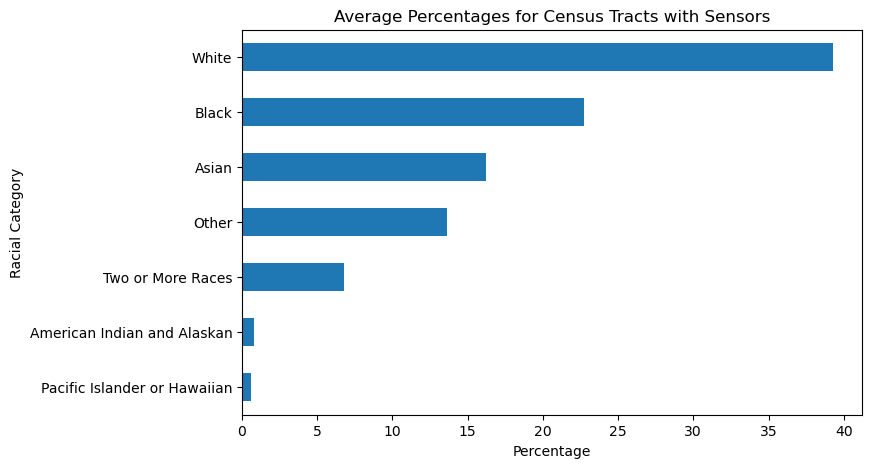

In [164]:
summary_stats = tract_race_percentage_sensor_df.describe()

# Extract the 'mean' row
mean_stats = summary_stats.loc['mean']

# Select specific elements (columns) by their names (e.g., 'sensor_count' and 'population')
selected_means = mean_stats[['White_Percentage',
                             'Black_Percentage', 'Asian_Percentage', 'American_Indian_and_Alaskan_Percentage',
                             'Pacific_Islander_or_Hawaiian_Percentage', 'Two_Or_More_Races_Percentage', 'Other_Percentage' ]]  # Adjust this based on the elements you want


# Create a dictionary for aliases (shortened column names)
aliases = {
    'White_Percentage': 'White',
    'Black_Percentage': 'Black', 
    'Asian_Percentage': 'Asian', 
    'American_Indian_and_Alaskan_Percentage': 'American Indian and Alaskan',                            
    'Pacific_Islander_or_Hawaiian_Percentage': 'Pacific Islander or Hawaiian',
    'Two_Or_More_Races_Percentage': 'Two or More Races',
    'Other_Percentage': 'Other'
    
}

# Apply the aliases to the selected_means Series
selected_means = selected_means.rename(index=aliases)

# Sort the means in descending order
selected_means = selected_means.sort_values(ascending=True)
# Plot the selected means
selected_means.plot(kind='barh', figsize=(8, 5))

# Add labels and title
plt.title('Average Percentages for Census Tracts with Sensors')
plt.ylabel('Racial Category')
plt.xlabel('Percentage')
plt.xticks(rotation=0)

## Average Racial Percentages for Tracts with Sensors

In [172]:
# Use plotly to plot our the average percentage of racial categories in tracts 
# with sensors present.

def create_interactive_barplot(input_df, title):
    # Assuming `summary_stats` is your describe DataFrame and `selected_means` is already calculated as you described
    summary_stats = input_df.describe()
    
    # Extract the 'mean' row
    mean_stats = summary_stats.loc['mean']
    
    # Select specific elements (columns) by their names
    selected_means = mean_stats[['White_Percentage',
                                 'Black_Percentage', 'Asian_Percentage', 'American_Indian_and_Alaskan_Percentage',
                                 'Pacific_Islander_or_Hawaiian_Percentage', 'Two_Or_More_Races_Percentage', 'Other_Percentage' ]]
    
    # Create a dictionary for aliases (shortened column names)
    aliases = {
        'White_Percentage': 'White',
        'Black_Percentage': 'Black', 
        'Asian_Percentage': 'Asian', 
        'American_Indian_and_Alaskan_Percentage': 'American Indian and Alaskan',                            
        'Pacific_Islander_or_Hawaiian_Percentage': 'Pacific Islander or Hawaiian',
        'Two_Or_More_Races_Percentage': 'Two or More Races',
        'Other_Percentage': 'Other'
    }
    
    # Apply the aliases to the selected_means Series
    selected_means = selected_means.rename(index=aliases)
    
    # Sort the means in ascending order
    selected_means = selected_means.sort_values(ascending=False)
    
    # Create a DataFrame from the selected_means for Plotly
    selected_means_df = selected_means.reset_index()
    selected_means_df.columns = ['Racial Category', 'Percentage']
    
    # Round the 'Percentage' column to 2 decimal places for display purposes
    selected_means_df['Percentage'] = selected_means_df['Percentage'].round(2)
    
    # Plot using Plotly Express with horizontal bars
    fig = px.bar(
        selected_means_df,
        x='Percentage',
        y='Racial Category',
        orientation='h',  # Horizontal bar plot
        color='Racial Category',  # Color by racial category
        color_discrete_sequence=px.colors.qualitative.Plotly,  # Different colors for each bar
    )
    
    # Update plot layout for title and labels
    fig.update_layout(
        title=title,
        xaxis_title='Percentage',
        yaxis_title='Racial Category',
        showlegend=False,  # Disable legend if not needed
        width=800, height=500  # Adjust figure size
    )
    
    # Show the figure
    fig.show()

create_interactive_barplot(tract_race_percentage_sensor_df,'Average Percentages for All Census Tracts with Sensors')

On average it appears White Alone is the predominant category, with Black 
Alone, Asian Alone, and Other categories gradually tapering off in 
percentage. Interestingly enough, the category we observed having high 
correlation to sensor count, Two or More Races, seems only to count for an 
average of 6.76% of the population in tracts with sensors present.

## Table of Census Tracts with Sensors and Racial Percentages

In [166]:
# Query for all census tracts with a sensor count. Sort in descending order
tract_race_percentage_sensor_df.query('sensor_count > 0').sort_values(by='sensor_count', ascending=False)

geography                                      census_tract   
113  1400000US06001400100     Census Tract 4001, Alameda County, California  \
73   1400000US06001404502  Census Tract 4045.02, Alameda County, California   
72   1400000US06001404600     Census Tract 4046, Alameda County, California   
75   1400000US06001404400     Census Tract 4044, Alameda County, California   
31   1400000US06001408100     Census Tract 4081, Alameda County, California   
76   1400000US06001404300     Census Tract 4043, Alameda County, California   
6    1400000US06001426100     Census Tract 4261, Alameda County, California   
5    1400000US06001426200     Census Tract 4262, Alameda County, California   
13   1400000US06001409900     Census Tract 4099, Alameda County, California   
77   1400000US06001404200     Census Tract 4042, Alameda County, California   
74   1400000US06001404501  Census Tract 4045.01, Alameda County, California   
71   1400000US06001404700     Census Tract 4047, Alameda County, California   
67   1400000US06001405100     Census Tract 4051, Alameda County, California   
112  1400000US06001400200     Census Tract 4002, Alameda County, California   
111  1400000US06001400300     Census Tract 4003, Alameda County, California   
110  1400000US06001400400     Census Tract 4004, Alameda County, California   
12   1400000US06001410000     Census Tract 4100, Alameda County, California   
46   1400000US06001406700     Census Tract 4067, Alameda County, California   
109  1400000US06001400500     Census Tract 4005, Alameda County, California   
104  1400000US06001401000     Census Tract 4010, Alameda County, California   
14   1400000US06001409800     Census Tract 4098, Alameda County, California   
69   1400000US06001404900     Census Tract 4049, Alameda County, California   
45   1400000US06001406800     Census Tract 4068, Alameda County, California   
82   1400000US06001403800     Census Tract 4038, Alameda County, California   
70   1400000US06001404800     Census Tract 4048, Alameda County, California   
85   1400000US06001403600     Census Tract 4036, Alameda County, California   
99   1400000US06001401500     Census Tract 4015, Alameda County, California   
40   1400000US06001407200     Census Tract 4072, Alameda County, California   
29   1400000US06001408300     Census Tract 4083, Alameda County, California   
95   1400000US06001402200     Census Tract 4022, Alameda County, California   
44   1400000US06001406900     Census Tract 4069, Alameda County, California   
107  1400000US06001400700     Census Tract 4007, Alameda County, California   
68   1400000US06001405000     Census Tract 4050, Alameda County, California   
32   1400000US06001408000     Census Tract 4080, Alameda County, California   
30   1400000US06001408200     Census Tract 4082, Alameda County, California   
33   1400000US06001407900     Census Tract 4079, Alameda County, California   
106  1400000US06001400800     Census Tract 4008, Alameda County, California   
34   1400000US06001407800     Census Tract 4078, Alameda County, California   
101  1400000US06001401300     Census Tract 4013, Alameda County, California   
100  1400000US06001401400     Census Tract 4014, Alameda County, California   
24   1400000US06001408800     Census Tract 4088, Alameda County, California   
97   1400000US06001401700     Census Tract 4017, Alameda County, California   
96   1400000US06001401800     Census Tract 4018, Alameda County, California   
50   1400000US06001406400     Census Tract 4064, Alameda County, California   
94   1400000US06001402400     Census Tract 4024, Alameda County, California   
86   1400000US06001403502  Census Tract 4035.02, Alameda County, California   
58   1400000US06001405800     Census Tract 4058, Alameda County, California   
81   1400000US06001403900     Census Tract 4039, Alameda County, California   
79   1400000US06001404101  Census Tract 4041.01, Alameda County, California   
35   1400000US06001407700     Census Tract 4077, Alameda County, C

## Top Ten Census Tracts With Highest Senor Installs

In [168]:
# Query for all census tracts with a sensor count. Sort in descending order
top_ten_tracts_with_sensors = tract_race_percentage_sensor_df.query('sensor_count > 0').sort_values(by='sensor_count', ascending=False).head(10)
top_ten_tracts_with_sensors

geography                                      census_tract   
113  1400000US06001400100     Census Tract 4001, Alameda County, California  \
73   1400000US06001404502  Census Tract 4045.02, Alameda County, California   
72   1400000US06001404600     Census Tract 4046, Alameda County, California   
75   1400000US06001404400     Census Tract 4044, Alameda County, California   
31   1400000US06001408100     Census Tract 4081, Alameda County, California   
76   1400000US06001404300     Census Tract 4043, Alameda County, California   
6    1400000US06001426100     Census Tract 4261, Alameda County, California   
5    1400000US06001426200     Census Tract 4262, Alameda County, California   
13   1400000US06001409900     Census Tract 4099, Alameda County, California   
77   1400000US06001404200     Census Tract 4042, Alameda County, California   

      Total  White_Percentage  Black_Percentage   
113  3115.0         68.121990          4.109149  \
73   6070.0         75.140033          2.866557   
72   4688.0         71.267065          4.714164   
75   5475.0         73.223744          1.808219   
31   6108.0         42.829077         22.838900   
76   3437.0         66.336922          2.764038   
6    6404.0         76.608370          1.280450   
5    4904.0         72.369494          2.671289   
13   3680.0         27.961957         47.989130   
77   3849.0         66.848532          6.339309   

     American_Indian_and_Alaskan_Percentage  Asian_Percentage   
113                                0.000000         19.229535  \
73                                 0.181219         13.064250   
72                                 0.127986         15.081058   
75                                 0.602740         15.689498   
31                                 0.000000         20.284872   
76                                 0.000000         13.441955   
6                                  0.249844         17.551530   
5                                  0.081566         16.129690   
13                                 0.353261          6.168478   
77                                 0.259808         17.485061   

     Pacific_Islander_or_Hawaiian_Percentage  Two_Or_More_Races_Percentage   
113                                 0.000000                      5.361156  \
73                                  0.000000                      8.451400   
72                                  2.218430                      4.820819   
75                                  0.000000                      8.675799   
31                                  0.000000                      9.495743   
76                                  0.000000                     13.151004   
6                                   0.000000                      4.309806   
5                                   0.142741                      8.421697   
13                                  0.000000                     14.701087   
77                                  0.961289                      6.261367   

     Other_Percentage  sensor_count  
113          3.178170          14.0  
73           0.296540          13.0  
72           1.770478          13.0  
75           0.000000          11.0  
31           4.551408           8.0  
76           4.306081           8.0  
6            0.000000           8.0  
5            0.183524           6.0  
13           2.826087           6.0  
77           1.844635           5.0

In [169]:
top_ten_tracts_with_sensors.describe()

Total  White_Percentage  Black_Percentage   
count    10.000000         10.000000         10.000000  \
mean   4773.000000         64.070718          9.738121   
std    1212.163814         15.876160         14.845349   
min    3115.000000         27.961957          1.280450   
25%    3722.250000         66.464824          2.694476   
50%    4796.000000         69.694528          3.487853   
75%    5921.250000         73.010182          5.933023   
max    6404.000000         76.608370         47.989130   

       American_Indian_and_Alaskan_Percentage  Asian_Percentage   
count                               10.000000         10.000000  \
mean                                 0.185642         15.412593   
std                                  0.191269          3.982335   
min                                  0.000000          6.168478   
25%                                  0.020392         13.851731   
50%                                  0.154603         15.909594   
75%                                  0.257317         17.534913   
max                                  0.602740         20.284872   

       Pacific_Islander_or_Hawaiian_Percentage  Two_Or_More_Races_Percentage   
count                                10.000000                     10.000000  \
mean                                  0.332246                      8.364988   
std                                   0.727401                      3.446284   
min                                   0.000000                      4.309806   
25%                                   0.000000                      5.586208   
50%                                   0.000000                      8.436548   
75%                                   0.107055                      9.290757   
max                                   2.218430                     14.701087   

       Other_Percentage  sensor_count  
count         10.000000      10.00000  
mean           1.895692       9.20000  
std            1.765961       3.29309  
min            0.000000       5.00000  
25%            0.211778       6.50000  
50%            1.807556       8.00000  
75%            3.090149      12.50000  
max            4.551408      14.00000

In [174]:
create_interactive_barplot(top_ten_tracts_with_sensors,'Average Percentages For Top 10 Census Tracts with Sensors')

In [1409]:
con.execute("""SELECT * FROM racial_yearly_view 
                WHERE year = 2022
                AND geographic_area_name LIKE '%4043%'
                -- GROUP BY AFFGEOID
                -- ORDER BY race_estimate_total
                -- LIMIT 1 """).fetchdf()
   
# con.execute("""SELECT geography, geographic_area_name, race_estimate_total_white_alone, year
        # FROM racial_yearly_view
        # WHERE year = 2022""")

AFFGEOID  sensor_count   
0  1400000US06001404300             1  \

                            geographic_area_name  race_estimate_total   
0  Census Tract 4043, Alameda County, California               3437.0  \

   race_estimate_total_white_alone   
0                           2280.0  \

   race_estimate_total_black_or_african_american_alone   
0                                                 95.0  \

   race_estimate_total_american_indian_and_alaska_native_alone   
0                                                          0.0  \

   race_estimate_total_asian_alone   
0                            462.0  \

   race_estimate_total_native_hawaiian_and_other_pacific_islander_alone   
0                                                                   0.0  \

   race_estimate_total_some_other_race_alone   
0                                      148.0  \

   race_estimate_total_two_or_more_races  year  
0                                  452.0  2022

In [1435]:
my_race_2022_df = con.execute("""SELECT
                AFFGEOID, geographic_area_name,
                race_estimate_total_white_alone,
                race_estimate_total_black_or_african_american_alone,
                race_estimate_total_american_indian_and_alaska_native_alone,
                race_estimate_total_asian_alone,
                race_estimate_total_native_hawaiian_and_other_pacific_islander_alone,
                race_estimate_total_some_other_race_alone,
                race_estimate_total_two_or_more_races, 
                year
                FROM racial_yearly_view 
                WHERE year = 2020
                -- AND geographic_area_name LIKE '%4043%'
                -- GROUP BY AFFGEOID
                -- ORDER BY race_estimate_total
                -- LIMIT 1
                """).fetchdf()
   
print(f"DF length:{len(my_race_2022_df)}")


DF length:41


In [175]:
con.execute("""SELECT COUNT(sensor_count), AFFGEOID, geographic_area_name, ANY_VALUE(year)  FROM racial_yearly_view 
                -- WHERE year = 2022
                WHERE geographic_area_name LIKE '%4043%'
                -- GROUP BY AFFGEOID
                -- ORDER BY race_estimate_total
                -- LIMIT 1
                GROUP BY AFFGEOID, geographic_area_name, year
                """).fetchdf()
   
# con.execute("""SELECT geography, geographic_area_name, race_estimate_total_white_alone, year
        # FROM racial_yearly_view
        # WHERE year = 2022""")

count(sensor_count)              AFFGEOID   
0                    1  1400000US06001404300  \
1                    1  1400000US06001404300   
2                    1  1400000US06001404300   
3                    1  1400000US06001404300   

                            geographic_area_name  any_value("year")  
0  Census Tract 4043, Alameda County, California               2020  
1  Census Tract 4043, Alameda County, California               2021  
2  Census Tract 4043, Alameda County, California               2019  
3  Census Tract 4043, Alameda County, California               2022

# Exploring Low Correlation Census Columns

## Consulting Correlations Table

### Functions

#### plot_corr_year_by_year

In [ ]:
import pandas as pd
import plotly.express as px
def plot_corr_year_by_year(df):
    # Plot using plotly.express
    fig = px.line(
        df,
        x='year',
        y='correlation',
        color='census_column',  # Each line represents a different census column
        markers=True,  # Add markers to indicate where data points exist
        title='Correlation of Census Data by Year',
        labels={
            'year': 'Year',
            'correlation': 'Correlation',
            'census_column': 'Census Column'
        },
        hover_name= 'census_column'
    )
    
    # Update x-axis to show solid years (no decimals) and prevent commas in the year
    fig.update_xaxes(
        tickmode='linear',  # Ensure ticks are evenly spaced
        dtick=1,  # Set tick interval to 1 (one year)
        tickformat='%Y',  # Ensure the year has no commas
        ticklabelmode="instant"  # Ensure no fractional years appear
    )
    
    # Customize the layout for better visibility
    fig.update_layout(
        width=900,
        height=600,
        showlegend=False,
        # legend_title_text='Census Column'
    )
    
    # Show the plot
    fig.show()
plot_corr_year_by_year(negative_race_corr_df)

#### generate_yearly_correlations_df

In [70]:
def generate_yearly_correlations_df(col_pattern, cor, con=con, positive=True):
    # Set Pandas option to avoid truncating wide columns
    pd.set_option('display.max_colwidth', None)
  
    storage_corr_df = pd.DataFrame()
    for year in range(2018, 2023):
        result_df = find_corr_by_year(con, cor, year, col_pattern, positive)
        # Filter the DataFrame to remove rows where 'column_name' contains the text pattern "margin_of_error"
        result_df = result_df[~result_df['census_column'].str.contains('margin_of_error')]
    
        # Sort the DataFrame by 'column_name' in ascending order
        result_df = result_df.sort_values(by='correlation', ascending=False)
        display(HTML(f"<b>YEAR: {year}"))
    
        # Append result_df to storage_df using pd.concat
        storage_corr_df = pd.concat([storage_corr_df, result_df], ignore_index=True)
        display(result_df)
    return(storage_corr_df)
    
    # Reset colwidth to deal with long column names
    pd.reset_option('display.max_colwidth')

test_storage_result_df = generate_yearly_correlations_df('race', 0.7, con, positive=True)


Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

census_column   
0  race_estimate_total__native_hawaiian_and_other_pacific_islander_alone  \

   correlation  year  
0      0.76111  2021

Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

## Race

Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

census_column   
2  race_estimate_total__two_or_more_races__two_races_including_some_other_race  \
0                                      race_estimate_total__two_or_more_races_   

   correlation  year  
2     0.529180  2019  
0     0.317585  2019

census_column  correlation  year
1  race_estimate_total__white_alone     0.653075  2020
0              race_estimate_total_     0.369350  2020

census_column   
1                                race_estimate_total__native_hawaiian_and_other_pacific_islander_alone  \
4  race_estimate_total__two_or_more_races__two_races_excluding_some_other_race_and_three_or_more_races   
3                                                              race_estimate_total__two_or_more_races_   
0                                                                     race_estimate_total__white_alone   

   correlation  year  
1     0.761110  2021  
4     0.384823  2021  
3     0.319327  2021  
0     0.309552  2021

Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

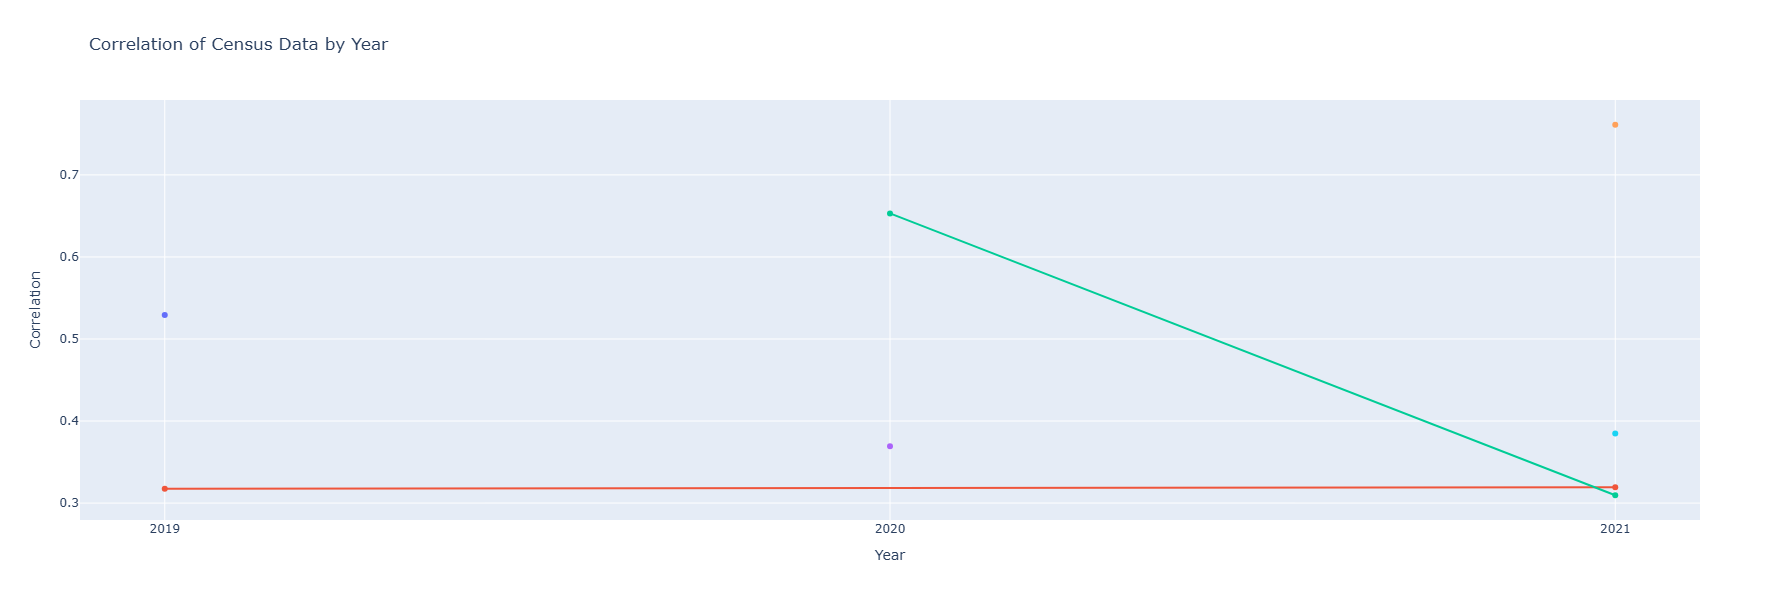

In [76]:
positive_race_corr_df = generate_yearly_correlations_df('race', 0.2, con, positive=True)
plot_corr_year_by_year(positive_race_corr_df)

census_column   
3                                                 race_estimate_total_black_or_african_american_alone  \
13  race_estimate_total_two_or_more_races_two_races_excluding_some_other_race_and_three_or_more_races   
11                          race_estimate_total_two_or_more_races_two_races_including_some_other_race   
9                                                               race_estimate_total_two_or_more_races   
0                                                                                 race_estimate_total   
4                                         race_estimate_total_american_indian_and_alaska_native_alone   
7                                race_estimate_total_native_hawaiian_and_other_pacific_islander_alone   

    correlation  year  
3     -0.121073  2018  
13    -0.152508  2018  
11    -0.158821  2018  
9     -0.172833  2018  
0     -0.198216  2018  
4     -0.212994  2018  
7     -0.283150  2018

census_column   
4                    race_estimate_total__black_or_african_american_alone  \
10  race_estimate_total__native_hawaiian_and_other_pacific_islander_alone   
2                                        race_estimate_total__white_alone   
6            race_estimate_total__american_indian_and_alaska_native_alone   
12                             race_estimate_total__some_other_race_alone   
8                                        race_estimate_total__asian_alone   
0                                                    race_estimate_total_   

    correlation  year  
4     -0.134747  2019  
10    -0.151694  2019  
2     -0.177434  2019  
6     -0.208170  2019  
12    -0.227082  2019  
8     -0.360316  2019  
0     -0.438580  2019

census_column   
6  race_estimate_total__two_or_more_races__two_races_including_some_other_race  \
4                                   race_estimate_total__some_other_race_alone   
2                 race_estimate_total__american_indian_and_alaska_native_alone   
0                         race_estimate_total__black_or_african_american_alone   

   correlation  year  
6    -0.102546  2020  
4    -0.211891  2020  
2    -0.251123  2020  
0    -0.287514  2020

census_column  correlation   
4                    race_estimate_total__some_other_race_alone    -0.163080  \
2  race_estimate_total__american_indian_and_alaska_native_alone    -0.187857   
0          race_estimate_total__black_or_african_american_alone    -0.224550   

   year  
4  2021  
2  2021  
0  2021

census_column   
10                                race_estimate_total__native_hawaiian_and_other_pacific_islander_alone  \
12                                                           race_estimate_total__some_other_race_alone   
2                                                                      race_estimate_total__white_alone   
8                                                                      race_estimate_total__asian_alone   
18  race_estimate_total__two_or_more_races__two_races_excluding_some_other_race_and_three_or_more_races   
4                                                  race_estimate_total__black_or_african_american_alone   
6                                          race_estimate_total__american_indian_and_alaska_native_alone   
16                          race_estimate_total__two_or_more_races__two_races_including_some_other_race   
14                                                              race_estimate_total__two_or_more_races_   
0                                                                                  race_estimate_total_   

    correlation  year  
10    -0.193129  2022  
12    -0.201002  2022  
2     -0.248816  2022  
8     -0.307294  2022  
18    -0.332468  2022  
4     -0.348325  2022  
6     -0.369692  2022  
16    -0.418883  2022  
14    -0.424699  2022  
0     -0.587688  2022

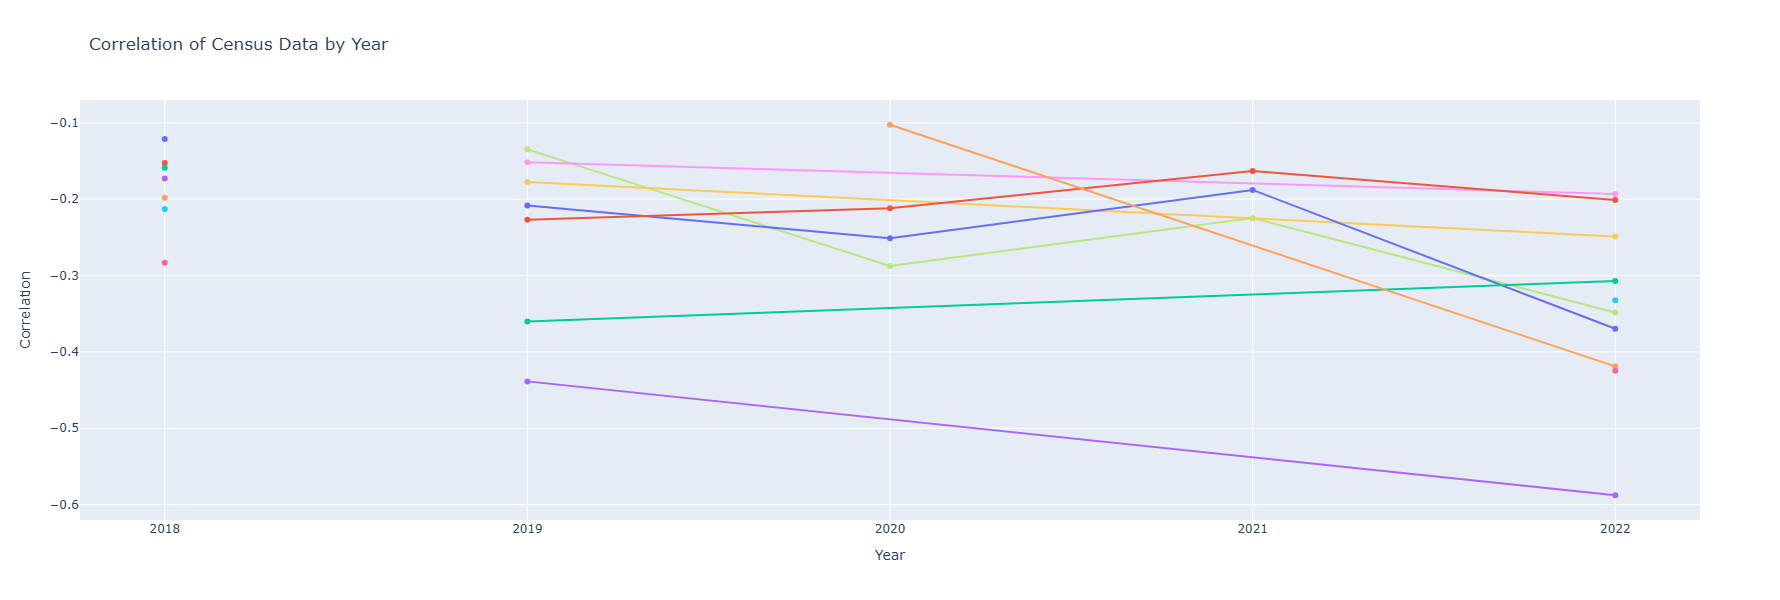

In [80]:
negative_race_corr_df = generate_yearly_correlations_df('race', -0.1, con, positive=False)
plot_corr_year_by_year(negative_race_corr_df)


## Educational Attainment

census_column   
0                                                                                              educational_attainment_estimate_total_population_18_to_24_years_high_school_graduate_includes_equivalency_  \
4                                                                                            educational_attainment_estimate_percent_population_18_to_24_years_high_school_graduate_includes_equivalency_   
14  educational_attainment_estimate_percent_female_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   
5                                                                                               educational_attainment_estimate_male_population_18_to_24_years_high_school_graduate_includes_equivalency_   

    correlation  year  
0     -0.409252  2018  
4     -0.419670  2018  
14    -0.441485  2018  
5     -0.472428  2018

census_column   
7                                                                                                         educational_attainment_estimate_female_age_by_educational_attainment_population_45_to_64_years  \
6                                                                                                      educational_attainment_estimate_female_age_by_educational_attainment_population_25_years_and_over   
0  educational_attainment_estimate_percent_female_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   

   correlation  year  
7    -0.434102  2019  
6    -0.445005  2019  
0    -0.455254  2019

census_column   
4                                                                         educational_attainment_estimate_percent_age_by_educational_attainment_population_25_years_and_over_associates_degree  \
0   educational_attainment_estimate_percent_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_bachelors_degree_or_higher   
16                                        educational_attainment_estimate_percent_female_age_by_educational_attainment_population_25_years_and_over_high_school_graduate_includes_equivalency_   
17                                                                 educational_attainment_estimate_percent_female_age_by_educational_attainment_population_25_years_and_over_associates_degree   
12                                          educational_attainment_estimate_percent_male_age_by_educational_attainment_population_25_years_and_over_high_school_graduate_includes_equivalency_   
2                                                educational_attainment_estimate_percent_age_by_educational_attainment_population_25_years_and_over_high_school_graduate_includes_equivalency_   

    correlation  year  
4     -0.423432  2020  
0     -0.435161  2020  
16    -0.440744  2020  
17    -0.480738  2020  
12    -0.508332  2020  
2     -0.510358  2020

census_column   
8  educational_attainment_estimate_total_median_earnings_in_the_past_12_months_in_2021_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate  \

   correlation  year  
8    -0.535022  2021

census_column   
86                                                                       educational_attainment_estimate_female_age_by_educational_attainment_population_25_years_and_over_graduate_or_professional_degree  \
15                                                                educational_attainment_estimate_total_age_by_educational_attainment_population_18_to_24_years_high_school_graduate_includes_equivalency_   
23                                                                                       educational_attainment_estimate_total_age_by_educational_attainment_population_25_years_and_over_bachelors_degree   
13                                                                                                           educational_attainment_estimate_total_age_by_educational_attainment_population_18_to_24_years   
117                                                                  educational_attainment_estimate_percent_female_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate   
3                                                  educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin_bachelors_degree_or_higher   
10                                                  educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin_bachelors_degree_or_higher   
1                                                      educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_high_school_graduate_or_higher   
95                                                                               educational_attainment_estimate_female_age_by_educational_attainment_population_25_to_34_years_bachelors_degree_or_higher   
84                                                                                      educational_attainment_estimate_female_age_by_educational_attainment_population_25_years_and_over_bachelors_degree   
93                                                                           educational_attainment_estimate_female_age_by_educational_attainment_population_25_to_34_years_high_school_graduate_or_higher   
82                                                                                     educational_attainment_estimate_female_age_by_educational_attainment_population_25_years_and_over_associates_degree   
12   educational_attainment_estimate_percent_female_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   
0                                                                                     educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races   
99                                                                               educational_attainment_estimate_female_age_by_educational_attainment_population_35_to_44_years_bachelors_degree_or_higher   
21                                                                                      educational_attainment_estimate_total_age_by_educational_attainment_population_25_years_and_over_associates_degree   
91                                                                                                          educational_attainment_estimate_female_age_by_educational_attainment_population_25_to_34_years   
89                                                                            educational_attainment_estimate_female_age_by_educational_attainment_population_25_years_and_over_bachelors_degree_or_higher   
8                                                           educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_bachelors_degree_or_higher   
103                                                                  

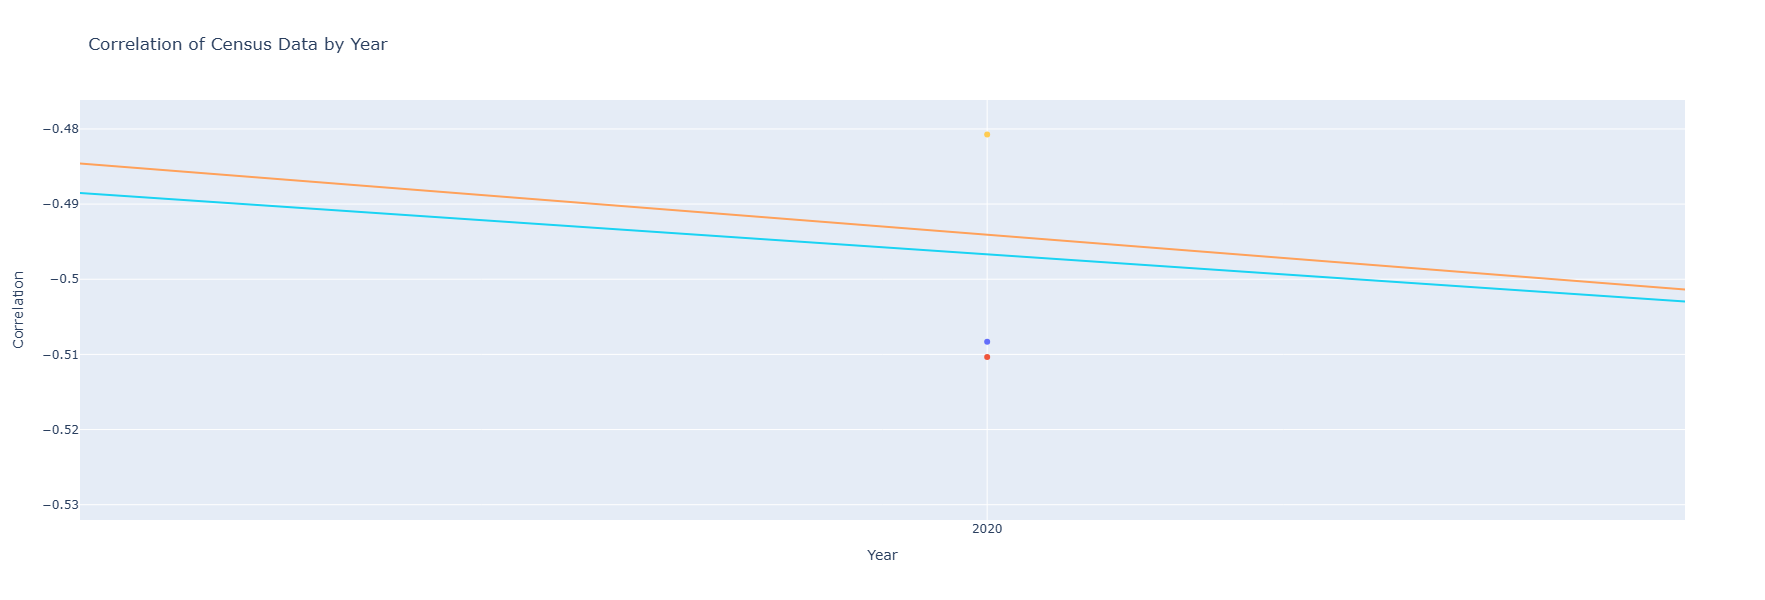

In [90]:
# Negative Correlatino with Educational Attainment
negative_edu_corr_df = generate_yearly_correlations_df('educational_attain', -0.4, con, positive=False)
plot_corr_year_by_year(negative_edu_corr_df)


In [103]:
# let's do some plain old counting for how many types of education we observe.
# Count rows that contain the pattern in 'census_column'
pattern_list = ["9th_to_12th_grade_no_diploma",
                "less_than_high_school_graduate",
                "high_school_graduate_includes_equivalency",
                "high_school_graduate_or_higher", 
                "some_college_no_degree",
                "some_college_or_associates_degree",
                "associates_degree",
                "bachelors_degree_or_higher",
                "65_years_and_over",
                "45_to_64_years"
                ]


for pattern in pattern_list:
#    for year in range(2018, 2023):
    print(f"Pattern: {pattern}\nCount: {negative_edu_corr_df['census_column'].str.contains(pattern).sum()}")
    # # Filter for the year specifically.
    #     df_year_of_interest = negative_edu_corr_df[negative_edu_corr_df['year'] == year]
    #     print(f"Year: {year}\nPattern: {pattern}\nCount: {df_year_of_interest['census_column'].str.contains(pattern).sum()}")


Pattern: 9th_to_12th_grade_no_diploma
Count: 0
Pattern: less_than_high_school_graduate
Count: 6
Pattern: high_school_graduate_includes_equivalency
Count: 8
Pattern: high_school_graduate_or_higher
Count: 13
Pattern: some_college_no_degree
Count: 3
Pattern: some_college_or_associates_degree
Count: 0
Pattern: associates_degree
Count: 4
Pattern: bachelors_degree_or_higher
Count: 13
Pattern: 65_years_and_over
Count: 0
Pattern: 45_to_64_years
Count: 6


census_column   
12  educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2018_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate  \
10                                      educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_bachelors_degree_or_higher   
7                                         educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher   
9                                            educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_bachelors_degree_or_higher   
0                                          educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher   
6                                   educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher   
11                        educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_hispanic_or_latino_origin_high_school_graduate_or_higher   
3                                                                                      educational_attainment_estimate_percent_female_population_18_to_24_years_less_than_high_school_graduate   
5                                                               educational_attainment_estimate_percent_male_population_25_years_and_over_population_35_to_44_years_bachelors_degree_or_higher   

    correlation  year  
12     0.717878  2018  
10     0.583355  2018  
7      0.581016  2018  
9      0.507928  2018  
0      0.470431  2018  
6      0.459845  2018  
11     0.458711  2018  
3      0.424429  2018  
5      0.407325  2018

census_column   
7                  educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_bachelors_degree_or_higher  \
28                                                                   educational_attainment_estimate_percent_female_age_by_educational_attainment_population_18_to_24_years_less_than_high_school_graduate   
4                              educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone_bachelors_degree_or_higher   
6                         educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_bachelors_degree_or_higher   
14                                                    educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_high_school_graduate_or_higher   
1                                                       educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_black_alone_bachelors_degree_or_higher   
13                                                                                   educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races   
26  educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2019_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_high_school_graduate_includes_equivalency_   
8                                                educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher   
3                                      educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone_bachelors_degree_or_higher   
9                                           educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher   
12                                              educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher   
27             educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2019_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_graduate_or_professional_degree   
10                                        educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_high_school_graduate_or_higher   
5                                                       educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_asian_alone_bachelors_degree_or_higher   
11                                                   educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher   
22                                                                 educational_attainment_estimate_percent_male_age_by_educational_attainment_population_25_years_and_over_graduate_or_professional_degree   
0                                                      educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_high_school_graduate_or_higher   
29                                                                       educational_attainment_estimate_percent_female_age_by_educational_attainment_population_45_to_64_years_bachelors_degree_or_higher   
2                                   educational_attainment_estimate_p

census_column   
100  educational_attainment_estimate_male_median_earnings_in_the_past_12_months_in_2020_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_high_school_graduate_includes_equivalency_  \
80                                                                           educational_attainment_estimate_female_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
35                                                                            educational_attainment_estimate_total_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
31                                                                               educational_attainment_estimate_total_age_by_educational_attainment_population_45_to_64_years_bachelors_degree_or_higher   
79                                                                       educational_attainment_estimate_female_age_by_educational_attainment_population_65_years_and_over_high_school_graduate_or_higher   
..                                                                                                                                                                                                    ...   
19                                                             educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_asian_alone_bachelors_degree_or_higher   
64                                                                    educational_attainment_estimate_percent_male_age_by_educational_attainment_population_45_to_64_years_high_school_graduate_or_higher   
43                                                                         educational_attainment_estimate_percent_age_by_educational_attainment_population_45_to_64_years_high_school_graduate_or_higher   
85                                                              educational_attainment_estimate_percent_female_age_by_educational_attainment_population_25_years_and_over_graduate_or_professional_degree   
62                                                                educational_attainment_estimate_percent_male_age_by_educational_attainment_population_25_years_and_over_graduate_or_professional_degree   

     correlation  year  
100     0.819606  2020  
80      0.719647  2020  
35      0.713668  2020  
31      0.684331  2020  
79      0.681328  2020  
..           ...   ...  
19      0.425930  2020  
64      0.418625  2020  
43      0.416783  2020  
85      0.415238  2020  
62      0.404931  2020  

[82 rows x 3 columns]

census_column   
3                                                      educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone  \
5                       educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_high_school_graduate_or_higher   
1                      educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_high_school_graduate_or_higher   
0                                                     educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone   
7                           educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_bachelors_degree_or_higher   
6                     educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone_high_school_graduate_or_higher   
4                                                    educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_native_hawaiian_and_other_pacific_islander_alone   
40            educational_attainment_estimate_male_median_earnings_in_the_past_12_months_in_2021_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_some_college_or_associates_degree   
33                                                                           educational_attainment_estimate_female_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
9   educational_attainment_estimate_percent_female_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   
12                                                                            educational_attainment_estimate_total_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
28                                                                     educational_attainment_estimate_percent_male_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
18                                                                        educational_attainment_estimate_male_age_by_educational_attainment_population_25_years_and_over_graduate_or_professional_degree   
32                                                                       educational_attainment_estimate_female_age_by_educational_attainment_population_65_years_and_over_high_school_graduate_or_higher   
2                           educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone_bachelors_degree_or_higher   
42                             educational_attainment_estimate_male_median_earnings_in_the_past_12_months_in_2021_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_bachelors_degree   
8                                                        educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_bachelors_degree_or_higher   
11                                                                               educational_attainment_estimate_total_age_by_educational_attainment_population_45_to_64_years_bachelors_degree_or_higher   
19                                                                             educational_attainment_estimate_male_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
30                                                                              educatio

census_column   
45          educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_some_college_or_associates_degree  \
47                           educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_bachelors_degree   
40  educational_attainment_estimate_total_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_high_school_graduate_includes_equivalency_   
48            educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_graduate_or_professional_degree   
30                                                                   educational_attainment_estimate_percent_female_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
41             educational_attainment_estimate_total_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_graduate_or_professional_degree   
19                                                                        educational_attainment_estimate_percent_male_age_by_educational_attainment_population_35_to_44_years_bachelors_degree_or_higher   
7                                                                           educational_attainment_estimate_percent_age_by_educational_attainment_population_65_years_and_over_bachelors_degree_or_higher   
1                                                         educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_asian_alone_high_school_graduate_or_higher   
44                                            educational_attainment_estimate_female_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings   
4              educational_attainment_estimate_percent_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_bachelors_degree_or_higher   
17                                                                educational_attainment_estimate_percent_male_age_by_educational_attainment_population_25_years_and_over_graduate_or_professional_degree   
0                                 educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino_bachelors_degree_or_higher   
3                                            educational_attainment_estimate_percent_female_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher   
2                                                   educational_attainment_estimate_percent_race_and_hispanic_or_latino_origin_by_educational_attainment_some_other_race_alone_bachelors_degree_or_higher   
43              educational_attainment_estimate_male_median_earnings_in_the_past_12_months_in_2022_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_graduate_or_professional_degree   

    correlation  year  
45     0.849698  2022  
47     0.647118  2022  
40     0.592849  2022  
48     0.544085  2022  
30     0.524970  2022  
41     0.495512  2022  
19     0.466578  2022  
7      0.463915  2022  
1      0.442433  2022  
44     0.436857  2022  
4      0.433699  2022  
17     0.429583  2022  
0      0.423302  2022  
3      0.412082  2022  
2      0.405245  2022  
43     0.402783  2022

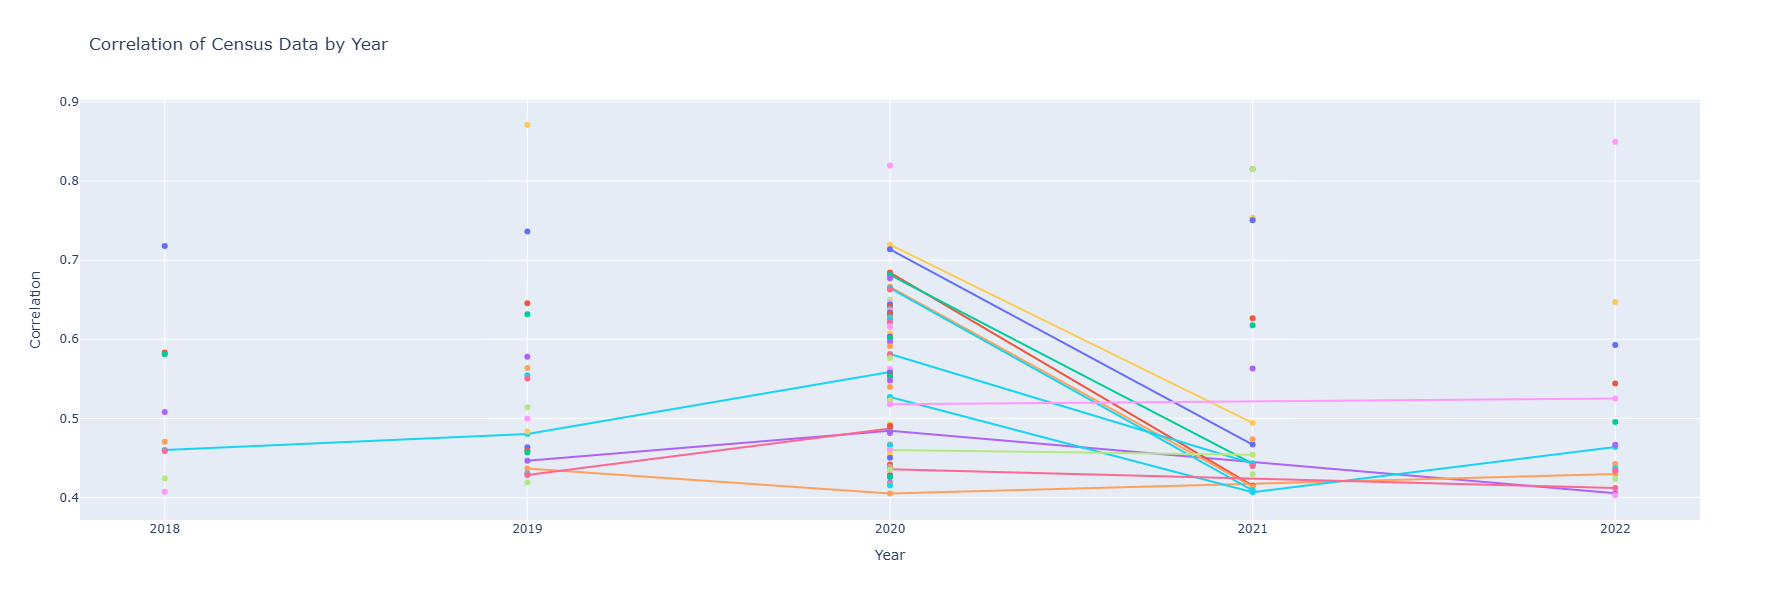

In [105]:
positive_edu_corr_df = generate_yearly_correlations_df('educational_attain', 0.4, con, positive=True)
plot_corr_year_by_year(positive_edu_corr_df)


In [181]:
negative_edu_corr_df = generate_yearly_correlations_df('educational_attain', -0.35, con, positive=False)
plot_corr_year_by_year(negative_edu_corr_df)


census_column   
10                                                                                                            educational_attainment_estimate_female_population_18_to_24_years_bachelors_degree_or_higher  \
24         educational_attainment_estimate_percent_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   
0                                                                                              educational_attainment_estimate_total_population_18_to_24_years_high_school_graduate_includes_equivalency_   
6                                                                                            educational_attainment_estimate_percent_population_18_to_24_years_high_school_graduate_includes_equivalency_   
25  educational_attainment_estimate_percent_female_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   
8                                                                                               educational_attainment_estimate_male_population_18_to_24_years_high_school_graduate_includes_equivalency_   

    correlation  year  
10    -0.351032  2018  
24    -0.371302  2018  
0     -0.409252  2018  
6     -0.419670  2018  
25    -0.441485  2018  
8     -0.472428  2018

census_column   
0                                                                          educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone  \
10                                                                                                                      educational_attainment_estimate_total_age_by_educational_attainment_population_25_to_34_years   
11                                                                                                                      educational_attainment_estimate_total_age_by_educational_attainment_population_35_to_44_years   
31                                                                                                                     educational_attainment_estimate_female_age_by_educational_attainment_population_35_to_44_years   
22                                                                                        educational_attainment_estimate_male_age_by_educational_attainment_population_25_to_34_years_high_school_graduate_or_higher   
13                                                                                             educational_attainment_estimate_percent_age_by_educational_attainment_population_25_years_and_over_less_than_9th_grade   
25                                                                                        educational_attainment_estimate_percent_male_age_by_educational_attainment_population_25_years_and_over_less_than_9th_grade   
1                                           educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone_high_school_graduate_or_higher   
8                                                                                             educational_attainment_estimate_total_age_by_educational_attainment_population_25_years_and_over_some_college_no_degree   
17                                                                            educational_attainment_estimate_male_age_by_educational_attainment_population_18_to_24_years_high_school_graduate_includes_equivalency_   
6                                                                                                                    educational_attainment_estimate_total_age_by_educational_attainment_population_25_years_and_over   
4   educational_attainment_estimate_percent_female_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_high_school_graduate_includes_equivalency_   
20                                                                                                                       educational_attainment_estimate_male_age_by_educational_attainment_population_25_to_34_years   
29                                                                                           educational_attainment_estimate_female_age_by_educational_attainment_population_25_years_and_over_some_college_no_degree   
2                                                                                                     educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_asian_alone   
32                                                                                                                     educational_attainment_estimate_female_age_by_educational_attainment_population_45_to_64_years   
27                                                                                                                  educational_attainment_estimate_female_age_by_educational_attainment_population_25_years_and_over   
3               educational_attainment_estimate_percent_female_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   

    correlation  year  
0     -0.350540  2019  
10    -0.357180  2019  
11  

census_column   
4                                                                  educational_attainment_estimate_total_age_by_educational_attainment_population_25_years_and_over_high_school_graduate_includes_equivalency_  \
19                                                                        educational_attainment_estimate_percent_male_age_by_educational_attainment_population_25_years_and_over_9th_to_12th_grade_no_diploma   
1   educational_attainment_estimate_percent_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_high_school_graduate_includes_equivalency_   
0                                                   educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races_high_school_graduate_or_higher   
5                                                                              educational_attainment_estimate_percent_age_by_educational_attainment_population_25_years_and_over_9th_to_12th_grade_no_diploma   
3              educational_attainment_estimate_percent_male_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_bachelors_degree_or_higher   
9                                                                                         educational_attainment_estimate_percent_age_by_educational_attainment_population_25_years_and_over_associates_degree   
2                   educational_attainment_estimate_percent_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_bachelors_degree_or_higher   
29                                                        educational_attainment_estimate_percent_female_age_by_educational_attainment_population_25_years_and_over_high_school_graduate_includes_equivalency_   
31                                                                                 educational_attainment_estimate_percent_female_age_by_educational_attainment_population_25_years_and_over_associates_degree   
21                                                          educational_attainment_estimate_percent_male_age_by_educational_attainment_population_25_years_and_over_high_school_graduate_includes_equivalency_   
7                                                                educational_attainment_estimate_percent_age_by_educational_attainment_population_25_years_and_over_high_school_graduate_includes_equivalency_   

    correlation  year  
4     -0.353973  2020  
19    -0.361516  2020  
1     -0.362460  2020  
0     -0.363971  2020  
5     -0.370811  2020  
3     -0.376238  2020  
9     -0.423432  2020  
2     -0.435161  2020  
29    -0.440744  2020  
31    -0.480738  2020  
21    -0.508332  2020  
7     -0.510358  2020

census_column   
0   educational_attainment_estimate_percent_male_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_some_college_or_associates_degree  \
10               educational_attainment_estimate_total_median_earnings_in_the_past_12_months_in_2021_inflation_adjusted_dollars__population_25_years_and_over_with_earnings_less_than_high_school_graduate   

    correlation  year  
0     -0.372960  2021  
10    -0.535022  2021

census_column   
91                                                                                                    educational_attainment_estimate_male_age_by_educational_attainment_population_45_to_64_years  \
8                                                       educational_attainment_estimate_female_race_and_hispanic_or_latino_origin_by_educational_attainment_black_alone_bachelors_degree_or_higher   
1                         educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone_high_school_graduate_or_higher   
0                                                        educational_attainment_estimate_total_race_and_hispanic_or_latino_origin_by_educational_attainment_american_indian_or_alaska_native_alone   
9                                                                              educational_attainment_estimate_male_race_and_hispanic_or_latino_origin_by_educational_attainment_two_or_more_races   
..                                                                                                                                                                                             ...   
87                                                                     educational_attainment_estimate_male_age_by_educational_attainment_population_35_to_44_years_high_school_graduate_or_higher   
45                                                                    educational_attainment_estimate_total_age_by_educational_attainment_population_35_to_44_years_high_school_graduate_or_higher   
15  educational_attainment_estimate_percent_poverty_rate_for_the_population_25_years_and_over_for_whom_poverty_status_is_determined_by_educational_attainment_level_less_than_high_school_graduate   
7                      educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_not_hispanic_or_latino_high_school_graduate_or_higher   
6                                             educational_attainment_estimate_percent_male_race_and_hispanic_or_latino_origin_by_educational_attainment_white_alone_high_school_graduate_or_higher   

    correlation  year  
91    -0.354852  2022  
8     -0.354892  2022  
1     -0.359894  2022  
0     -0.362757  2022  
9     -0.363548  2022  
..          ...   ...  
87    -0.651670  2022  
45    -0.668081  2022  
15    -0.677657  2022  
7     -0.725925  2022  
6     -0.737018  2022  

[66 rows x 3 columns]

In [104]:
for pattern in pattern_list:
#    for year in range(2018, 2023):
    print(f"Pattern: {pattern}\nCount: {positive_edu_corr_df['census_column'].str.contains(pattern).sum()}")
    # # Filter for the year specifically.

Pattern: 9th_to_12th_grade_no_diploma
Count: 0
Pattern: less_than_high_school_graduate
Count: 2
Pattern: high_school_graduate_includes_equivalency
Count: 4
Pattern: high_school_graduate_or_higher
Count: 17
Pattern: some_college_no_degree
Count: 0
Pattern: some_college_or_associates_degree
Count: 2
Pattern: associates_degree
Count: 2
Pattern: bachelors_degree_or_higher
Count: 27
Pattern: 65_years_and_over
Count: 12
Pattern: 45_to_64_years
Count: 9


In [177]:
for pattern in pattern_list:
#    for year in range(2018, 2023):
    print(f"Pattern: {pattern}\nCount: {negative_edu_corr_df['census_column'].str.contains(pattern).sum()}")
    # # Filter for the year specifically.

Pattern: 9th_to_12th_grade_no_diploma
Count: 2
Pattern: less_than_high_school_graduate
Count: 9
Pattern: high_school_graduate_includes_equivalency
Count: 23
Pattern: high_school_graduate_or_higher
Count: 29
Pattern: some_college_no_degree
Count: 10
Pattern: some_college_or_associates_degree
Count: 4
Pattern: associates_degree
Count: 11
Pattern: bachelors_degree_or_higher
Count: 27
Pattern: 65_years_and_over
Count: 0
Pattern: 45_to_64_years
Count: 10


## Income

Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

census_column  correlation   
1  income_estimate_nonfamily_households_total_50_000_to_74_999     0.606816  \
0            income_estimate_households_median_income_dollars_     0.403716   

   year  
1  2019  
0  2019

census_column   
4                    income_estimate_married_couple_families_total  \
7       income_estimate_nonfamily_households_total_200_000_or_more   
3                                   income_estimate_families_total   
0                 income_estimate_households_total_200_000_or_more   
10     income_estimate_nonfamily_households_median_income_dollars_   
2                  income_estimate_households_mean_income_dollars_   
1                income_estimate_households_median_income_dollars_   
5                   income_estimate_families_total_200_000_or_more   
8                  income_estimate_families_median_income_dollars_   
12       income_estimate_nonfamily_households_mean_income_dollars_   
11                   income_estimate_families_mean_income_dollars_   
6    income_estimate_married_couple_families_total_200_000_or_more   
9   income_estimate_married_couple_families_median_income_dollars_   

    correlation  year  
4      0.663132  2020  
7      0.609226  2020  
3      0.597968  2020  
0      0.585882  2020  
10     0.559469  2020  
2      0.556420  2020  
1      0.553072  2020  
5      0.545709  2020  
8      0.541539  2020  
12     0.535823  2020  
11     0.528996  2020  
6      0.499612  2020  
9      0.410096  2020

Empty DataFrame
Columns: [census_column, correlation, year]
Index: []

census_column   
3                     income_estimate_nonfamily_households_median_income_dollars_  \
2                      income_estimate_nonfamily_households_total_200_000_or_more   
0                               income_estimate_households_median_income_dollars_   
4  income_estimate_families_percent_allocated_family_income_in_the_past_12_months   
1                               income_estimate_families_total_100_000_to_149_999   

   correlation  year  
3     0.559374  2022  
2     0.496984  2022  
0     0.472398  2022  
4     0.407051  2022  
1     0.401939  2022

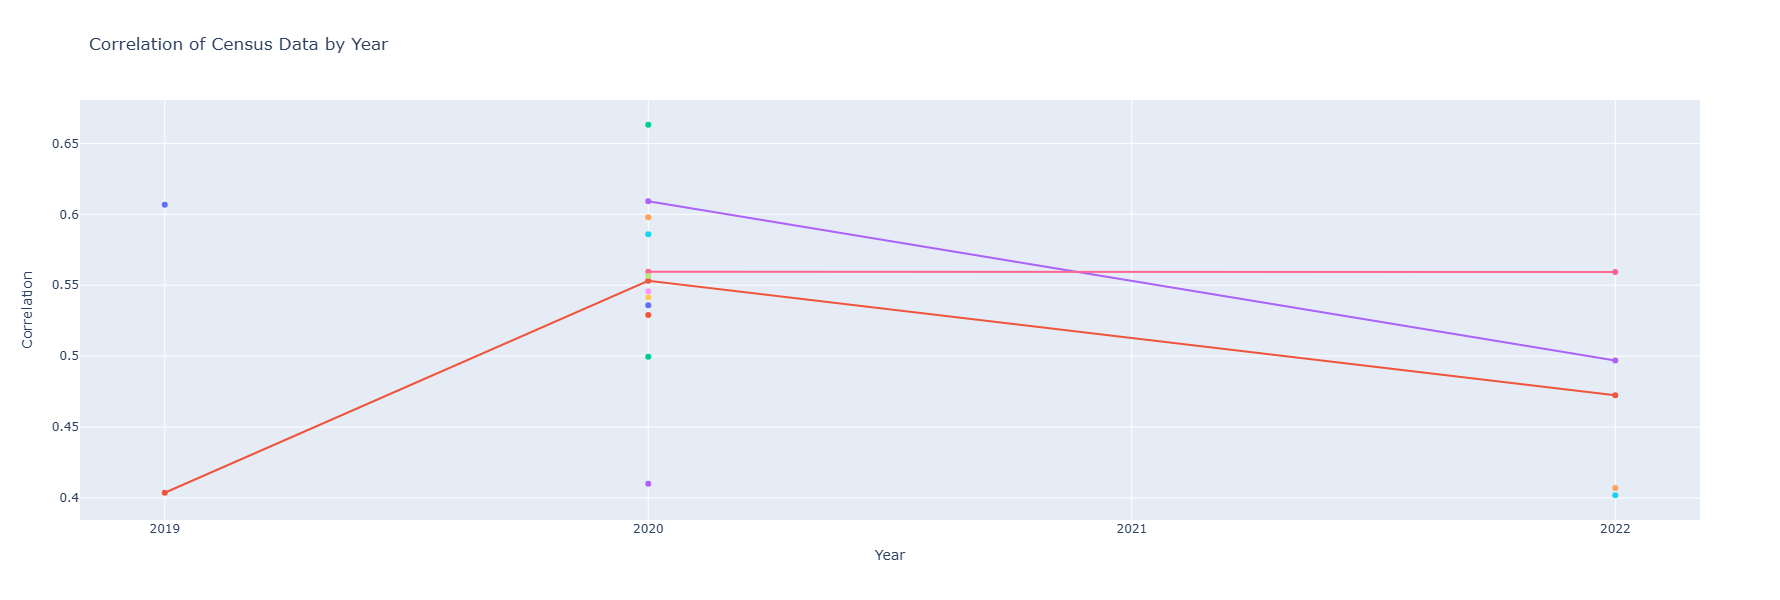

In [106]:
positive_income_corr_df = generate_yearly_correlations_df('income', 0.4, con, positive=True)
plot_corr_year_by_year(positive_income_corr_df)

In [183]:
negative_income_corr_df = generate_yearly_correlations_df('income', -0.3, con, positive=False)
plot_corr_year_by_year(negative_income_corr_df)

census_column  correlation   
0  income_estimate_nonfamily_households_total_less_than_10_000    -0.356834  \

   year  
0  2018

census_column   
4                                    income_estimate_nonfamily_households_total_75_000_to_99_999  \
5                                  income_estimate_nonfamily_households_total_100_000_to_149_999   
1                                              income_estimate_households_total_25_000_to_34_999   
2                                              income_estimate_households_total_75_000_to_99_999   
3                                                     income_estimate_nonfamily_households_total   
0                                                               income_estimate_households_total   
6  income_estimate_nonfamily_households_percent_allocated_nonfamily_income_in_the_past_12_months   

   correlation  year  
4    -0.341833  2019  
5    -0.355579  2019  
1    -0.358859  2019  
2    -0.400493  2019  
3    -0.409286  2019  
0    -0.420648  2019  
6    -0.458090  2019

census_column   
7   income_estimate_married_couple_families_total_25_000_to_34_999  \
1                income_estimate_households_total_10_000_to_14_999   
10     income_estimate_nonfamily_households_total_50_000_to_74_999   
3                income_estimate_households_total_35_000_to_49_999   
5                  income_estimate_families_total_10_000_to_14_999   
0                income_estimate_households_total_less_than_10_000   
8                  income_estimate_families_total_50_000_to_74_999   
9   income_estimate_married_couple_families_total_50_000_to_74_999   
2                income_estimate_households_total_25_000_to_34_999   
6                  income_estimate_families_total_25_000_to_34_999   
4                income_estimate_households_total_50_000_to_74_999   

    correlation  year  
7     -0.307526  2020  
1     -0.322634  2020  
10    -0.337066  2020  
3     -0.361467  2020  
5     -0.376938  2020  
0     -0.379323  2020  
8     -0.386234  2020  
9     -0.401584  2020  
2     -0.426787  2020  
6     -0.482337  2020  
4     -0.525332  2020

census_column   
0                 income_estimate_households_total_15_000_to_24_999  \
3                 income_estimate_households_total_50_000_to_74_999   
4                   income_estimate_families_total_15_000_to_24_999   
1                 income_estimate_households_total_25_000_to_34_999   
2                 income_estimate_households_total_35_000_to_49_999   
6  income_estimate_married_couple_families_total_100_000_to_149_999   
5                 income_estimate_families_total_100_000_to_149_999   

   correlation  year  
0    -0.308566  2021  
3    -0.327087  2021  
4    -0.329878  2021  
1    -0.329973  2021  
2    -0.346130  2021  
6    -0.434025  2021  
5    -0.436556  2021

census_column   
4                      income_estimate_married_couple_families_total  \
11    income_estimate_married_couple_families_total_75_000_to_99_999   
7        income_estimate_nonfamily_households_total_25_000_to_34_999   
6     income_estimate_married_couple_families_total_15_000_to_24_999   
13                 income_estimate_families_total_150_000_to_199_999   
1                  income_estimate_households_total_50_000_to_74_999   
14  income_estimate_married_couple_families_total_150_000_to_199_999   
12       income_estimate_nonfamily_households_total_75_000_to_99_999   
10                   income_estimate_families_total_75_000_to_99_999   
3                                     income_estimate_families_total   
9     income_estimate_married_couple_families_total_35_000_to_49_999   
2                  income_estimate_households_total_75_000_to_99_999   
8                    income_estimate_families_total_35_000_to_49_999   
5                         income_estimate_nonfamily_households_total   
0                                   income_estimate_households_total   

    correlation  year  
4     -0.303124  2022  
11    -0.315967  2022  
7     -0.322317  2022  
6     -0.332106  2022  
13    -0.343735  2022  
1     -0.345412  2022  
14    -0.362968  2022  
12    -0.420100  2022  
10    -0.439989  2022  
3     -0.448662  2022  
9     -0.451499  2022  
2     -0.481584  2022  
8     -0.489959  2022  
5     -0.493291  2022  
0     -0.590356  2022

## Grab Bag 

In [138]:
from IPython.display import IFrame, display, HTML
# Black
census_col_of_interest = 'race_estimate_total__black_or_african_american_alone'
plot_census_choropleth(con, census_col_of_interest ,2020)
img_path = "./images/race_estimate_total__black_or_african_american_alone_choropleth_plot_2022.html"
display(IFrame(src=img_path, width=1200, height=900))

In [139]:
# Asian
census_col_of_interest = 'race_estimate_total__asian_alone'
plot_census_choropleth(con, census_col_of_interest ,2020)
img_path = "./images/race_estimate_total__asian_alone_choropleth_plot_2022.html"
display(IFrame(src=img_path, width=1200, height=900))

In [142]:
# White
census_col_of_interest = 'race_estimate_total__white_alone'
plot_census_choropleth(con, census_col_of_interest ,2020)
img_path = "./images/race_estimate_total__white_alone_choropleth_plot_2022.html"
display(IFrame(src=img_path, width=1200, height=900))

In [143]:
# Native Hawaiian and Pacific Islander
census_col_of_interest = 'race_estimate_total__native_hawaiian_and_other_pacific_islander_alone'
plot_census_choropleth(con, census_col_of_interest ,2020)
img_path = f"./images/{census_col_of_interest}_choropleth_plot_2022.html"
display(IFrame(src=img_path, width=1200, height=900))

In [144]:
# Native Hawaiian and Pacific Islander
census_col_of_interest = 'race_estimate_total__two_or_more_races_'
plot_census_choropleth(con, census_col_of_interest ,2020)
img_path = f"./images/{census_col_of_interest}_choropleth_plot_2022.html"
display(IFrame(src=img_path, width=1200, height=900))

# DB Operations 

## Close DB connection

In [148]:
# Clean up and close db
con.close()

## Show Tables

In [ ]:
# Show tables
print(con.execute("SHOW TABLES").fetch_df())
# Print the result
print(result)
#                   name
# 0  merged_census_table
# 1    merged_corr_table
# 2  merged_sensor_table
# 3   racial_yearly_view

## Drop Table

In [1205]:
# Drop table for cleanup
# Create a proper duckdb table from the view of the merged census dataframe
# con.execute("DROP TABLE merged_census_table")

                  name
0  merged_census_table
1    merged_corr_table
2  merged_sensor_table
3   racial_yearly_view
